# <p style="text-align: center; color: red;"> Predicting Mineralogical Phases of Cement Clinker from Plant-level Data </p> 

# <p style="text-align: left; color: yellow;"> Sheikh Junaid Fayaz -- M3RG Lab -- Indian Institute of Technology, Delhi</p> 
# <p style="text-align: left; color: yellow;"> Date : 23 September 2024</p> 

# Importing Libraries

In [11]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from tqdm import tqdm
from matplotlib.ticker import AutoMinorLocator
import os as os
import pickle
import time
from sklearn.linear_model import Ridge
import numpy as np
import statistics
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ConstantKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor
from tqdm import tqdm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator 
from matplotlib import cm
import matplotlib.ticker as plticker 
import matplotlib.patches as patches
import math
import matplotlib

### Import dependencies for plotting

In [ ]:
# Add the Python path for loading ploting dependencies
sys.path.append(os.path.abspath("../../Ploting_dependencies"))

from new_plot import *          # Import from new_plot.py, #This line is throwing an error #Solved by commenting out some of the keys of rcParams()
from shadow.plot import *       # Import from shadow/plot.py
import subprocess

In [ ]:
print(matplotlib.__version__)

3.5.1


# Defining functions

### Error metric

In [13]:
from sklearn.metrics import r2_score, mean_absolute_error,mean_absolute_percentage_error
def get_score(base='Training', actual=0,predicted=0):
    r2 = r2_score(actual,predicted)
    mae = mean_absolute_error(actual,predicted)
    mape = mean_absolute_percentage_error(actual, predicted)
    return (r2.round(2),mae.round(2),(mape*100).round(2))

### Min, Avg & Max function

In [14]:
def average(min, max):
    mid = (min+max)/2
    if max-min <=1:
        mini = np.round(min,2)
        maxi = np.round(max,2)
        mid = np.round(mid,2)
    if max-min >1:
        mini = np.round(min,1)
        maxi = np.round(max,1)
        mid = np.round(mid,1)
    return(mini, mid, maxi)

### Common member function

In [15]:
def common_member(a, b):
    a_set = set(a)
    b_set = set(b)
 
    if (a_set & b_set):
        return(a_set & b_set)
    else:
        return({})

### Filtering function

Filters dataframe in the 0.1-99.9 percetile range

In [16]:
def filter_df(df):
    print(f'original length = {len(df)}')
    quantile_limit_values = []
    variable = df

    for column in variable:
        q_low = variable[column].quantile(0.0001)   # move dot 2 steps ahead, i.e., quantile(0.001) = 0.1 %
        q_hi  = variable[column].quantile(0.9999)
        quantile_limit_values.append((q_low,q_hi))


    count = 0
    for column in variable:
        q_low, q_hi = quantile_limit_values[count]
        variable = variable[(variable[column] < q_hi) & (variable[column] > q_low)]
        count +=1
        
    filtered = variable
    # filtered.reset_index(inplace=True)
    # filtered.drop(columns=['index'],inplace=True)
    print(f'length filtered = {len(filtered)}')
    return(filtered)
    

### Function for calculating MAPE of model predictions

In [17]:
def MPE(actual, prediction):
    error = []
    for i in range(len(prediction)):
        if actual[i] != 0:
            error.append((abs((actual[i]-prediction[i]))/abs(actual[i])*100))
        else:
            error.append((abs((actual[i]-prediction[i]))/abs(prediction[i])*100))
    x = 0
    for i in error:
        x += i
    x = x/len(prediction)
    mpe = round(x,2)
    return(mpe)

### Converts array to list

In [18]:
def array_to_list(x):
    mad = []
    for i in range(len(x)):
        mad.append(x[i][0])
    return(mad)

### Common member function

In [19]:
def common_member(a, b):
    a_set = set(a)
    b_set = set(b)
 
    if (a_set & b_set):
        return(a_set & b_set)
    else:
        print("No common elements")

### Function for parity plots

In [21]:
# run without Shadow
def parity_train_test(model, name):
    test_actual = y_test[y_test.columns[0]].to_list()
    train_actual = y_train[y_train.columns[0]].to_list()
    if name in ['Linear regression', 'Ridge']:
        test_pred = array_to_list(model.predict(X_test))
        train_pred = array_to_list(model.predict(X_train))
        [r2_train, mae_train, mape_train] = avg_train_results
        r2_test , mae_test, mape_test = get_score('Test',actual=y_test,predicted=model.predict(X_test))
    elif name in ['SVR', 'GPR', 'NN']:   
        test_pred_s = model.predict(X_test_s).reshape(-1,1)
        train_pred_s = model.predict(X_train_s).reshape(-1,1)

        # r2_train, mae_train, mape_train = get_score('Training',actual=y_train,predicted= scaler.inverse_transform(train_pred_s) )
        [r2_train, mae_train, mape_train] = avg_train_results
        r2_test , mae_test, mape_test  = get_score('Test',actual=y_test,predicted=scaler.inverse_transform(test_pred_s) )
        train_pred = array_to_list(scaler.inverse_transform(train_pred_s))
        test_pred = array_to_list(scaler.inverse_transform(test_pred_s)) 
    else:
        test_pred = list(model.predict(X_test))
        train_pred = list(model.predict(X_train))
        # r2_train, mae_train, mape_train = get_score('Training',actual=y_train,predicted=model.predict(X_train))
        [r2_train, mae_train, mape_train] = avg_train_results
        r2_test , mae_test, mape_test   = get_score('Test',actual=y_test,predicted=model.predict(X_test))
    print(f'Test: R^2 = {r2_test}, MAE = {mae_test}, MAPE = {mape_test}%')
    d = 0.4
    matplotlib.rcParams['axes.linewidth'] = 1
    style = 'normal'
    s = 25
    s1 = 15
    w =1
    minimum = 40
    maximum = 75

    fig, ax = plt.subplots(figsize=(5,5))
    _=plt.ylim(minimum, maximum)
    _=plt.xlim(minimum, maximum)
    _= plt.title(name, fontsize= s, fontweight = 'normal')
    _= plt.plot([minimum, maximum],[minimum, maximum], color = 'black', lw = 1.2, ls = (5,(10,3)))
    x1 = np.array([minimum, maximum])
    _= plt.plot(x1, 0.9*x1   , color = 'gray', lw = 1, ls = 'dotted')
    _= plt.plot(x1, 1.1*x1  , color = 'gray', lw = 1, ls = 'dotted')
    _= plt.fill_between(x1, 0.9*x1, 1.1*x1 ,alpha = 0.04, color = 'green'  )

    _= plt.scatter(train_actual,train_pred,color = ['white'] , s=35, linewidth = 1,edgecolors='red', marker = '^' ,label = 'MAPE$_{train}$: '+f'{mape_train:.2f}'+'%')
    _= plt.scatter(train_actual,train_pred,color = ['firebrick'] , s=35,alpha = 0.1, marker ='^',)

    _= plt.scatter(test_actual,test_pred,color = ['white'] , s = 35, linewidth = 1,edgecolors='blue', marker= 'o', label = 'MAPE$_{test}$: '+f'{mape_test:.2f}' +'%')
    _= plt.scatter(test_actual,test_pred,color = ['darkblue'] , s=35,alpha = 0.1, marker = 'o')

    _= plt.text(0.67,0.44,'- 10%',  transform=ax.transAxes,fontsize= s1, fontweight ='normal')
    _= plt.text(0.55,0.83, '+ 10%', transform=ax.transAxes, fontsize= s1, fontweight ='normal')

    X1 = [50, 60, 70]
    _= plt.xticks(X1, X1,rotation = 0, fontweight = style, fontsize = s)
    _= plt.yticks(X1,X1,rotation = 0, fontweight = style, fontsize = s)
    _= ax.tick_params('both', length=10, width=w, which='major')
    _= ax.tick_params('both', length=5, width=w, which='minor')
    _= plt.tick_params(axis="both", which="both", direction = 'in', right = True, left = True, top = True)
    _= plt.xlabel('Measured alite (wt. %)', fontsize= s, fontweight = 'normal')
    _= plt.ylabel('Predicted alite (wt. %)', fontsize= s, fontweight = 'normal')

    _= plt.legend(labelspacing = 0, loc = 'lower right', frameon = True,prop = {'weight' : 'normal', 'size' : 16.5},
                    borderpad=0.2,   # Adjust this to control space between the text and the border
                    handlelength=0.5,  # Adjust this to shorten the space before the legend text
                    handletextpad=0.5 ) # Adjust this to remove space between the legend marker and text)
    # # incet test
    left, bottom, width, height = [0.15, 0.64, 0.2, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])
    p = np.array(test_actual)
    a = np.array(test_pred)
    std=np.std(p - a)
    mean=np.mean(p - a)
    xx=mean-2*std
    yy = 0
    _=y1,x,_ = ax2.hist(p - a, bins = int(1+3.3*np.log(len(p-a))) ,color='white',range = [-4*std, 4*std] )
    rec = patches.Rectangle((xx,yy),4*std, np.max(y1), facecolor ='goldenrod', alpha = 0.25)
    ax2.add_patch(rec)
    _= plt.axvline(x = xx, color = 'goldenrod', lw =0.6, ls = '--')
    _= plt.axvline(x = xx+4*std, color = 'goldenrod', lw =0.6, ls = '--')
    y1,x,_ = ax2.hist(p - a, bins = int(1+3.3*np.log(len(p-a))) ,color='white',range = [-4*std, 4*std] )
    y1,x,_ = ax2.hist(p - a, bins = int(1+3.3*np.log(len(p-a))) ,color='darkblue',range = [-4*std, 4*std], alpha = 0.78)

    ax2.set_ylim(0,np.max(y1))
    ax2.xaxis.set_major_locator(plt.MaxNLocator(3))
    xlabel_ax2 = ax2.get_xticklabels()
    ax2.yaxis.tick_right()
    # ax2.yaxis.set_tick_params(labelsize =10,weight = 'normal')
    _= plt.xticks(fontweight = style, fontsize = s1)
    _= plt.yticks(fontweight = style, fontsize = s1)
    _= ax2.xaxis.set_tick_params(labelsize =s1)  #11.8
    # _= ax2.yaxis.set_tick_params(labelsize =12)
    _= ax2.tick_params('both', length=10, width=w, which='major', direction = 'in')
    _= ax2.tick_params('both', length=5, width=w, which='minor', direction = 'in')
    ax2.yaxis.set_label_position("right")
    _=ax2.set_ylabel(r"$\nu$",fontsize=s1, fontweight = style, labelpad = 0, fontname='DejaVu Sans')
    _=ax2.set_xlabel(r'$\epsilon$',fontsize=s1+2, fontweight = style, labelpad = 0)

    # incet train
    left, bottom, width, height = [0.15, 0.19, 0.2, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])
    p = np.array(train_pred)
    a = np.array(train_actual)
    std=np.std(p - a)
    mean=np.mean(p - a)
    xx=mean-2*std
    yy = 0
    y1,x,_ = ax2.hist(p - a, bins = int(1+3.3*np.log(len(p-a))) ,color='white',range = [-4*std, 4*std] )
    rec = patches.Rectangle((xx,yy),4*std, max(y1), facecolor ='goldenrod', alpha = 0.25)
    ax2.add_patch(rec)
    _= plt.axvline(x = xx, color = 'goldenrod', lw =0.6, ls = '--')
    _= plt.axvline(x = xx+4*std, color = 'goldenrod', lw =0.6, ls = '--')
    _=y1,x,_ = ax2.hist(p - a, bins = int(1+3.3*np.log(len(p-a))) ,color='white',range = [-4*std, 4*std] )
    _=y1,x,_ = ax2.hist(p - a, bins = int(1+3.3*np.log(len(p-a))) ,color='firebrick',range = [-4*std, 4*std], alpha = 1)

    _=ax2.set_ylim(0,max(y1))
    _=ax2.xaxis.set_major_locator(plt.MaxNLocator(3))
    _=xlabel_ax2 = ax2.get_xticklabels()
    _=ax2.yaxis.tick_right()
    # ax2.yaxis.set_tick_params(labelsize =10,weight = 'normal')
    _= plt.xticks(fontweight = style, fontsize = s1)
    _= plt.yticks(fontweight = style, fontsize = s1)
    _= ax2.xaxis.set_tick_params(labelsize =s1)  #11.8
    _= ax2.yaxis.set_tick_params(labelsize =s1)
    _= ax2.tick_params('both', length=10, width=w, which='major')
    _= ax2.tick_params('both', length=5, width=w, which='minor')
    _=ax2.yaxis.set_label_position("right")
    _=ax2.set_ylabel(r"$\nu$",fontsize=s1, fontweight = style, labelpad = 0, fontname='DejaVu Sans')
    # plt.savefig(f'/Users/sheikhjunaidfayaz/Documentxs/saved_items/clinker_phase_prediction_paper/parity_all_inputs/alite/{name}.tiff',format='tiff', bbox_inches = 'tight',dpi=1200)
    _=plt.show()

## Function for NN parity (HPC data)

In [ ]:
def parity_custom(train_actual, train_pred ,test_actual , test_prediction , title):
    fig, ax = plt.subplots()
    mpe = MPE(test_actual, test_prediction)
    minimum1 = round(min(test_actual + test_prediction), 5)
    maximum1 = round(max(test_actual + test_prediction), 5)     

    minimum2 = round(min(train_actual + train_pred), 5)
    maximum2 = round(max(train_actual + train_pred), 5)
    minimum = min(minimum1, minimum2)
    maximum = max(maximum1, maximum2)
    maximum = math.ceil(maximum)
    minimum = math.floor(minimum)

    _= plt.scatter(test_actual,test_prediction,color = ['firebrick'] , s = 13)
    _= plt.plot([minimum, minimum],[minimum, minimum], color = 'white', lw = 0)
    _= plt.plot([minimum, maximum],[minimum, maximum], color = 'black', lw = 1)
    
    _= plt.xticks(rotation = 0, fontweight = 'normal', fontsize = 15)
    _= plt.yticks(fontweight = 'normal', fontsize = 15)
   
    box = ('$|MPE|_{test}$ ='+f' {mpe}')
    _= ax.text( 0.62,0.25,box, transform=ax.transAxes, linespacing=1 ,fontsize=15,verticalalignment='top', fontweight='normal')
    _= plt.xlabel('Measured alite, $C_{3}S$ (%)', fontweight = 'normal', fontsize = 15)
    _= plt.ylabel('Predicted alite, $C_{3}S$ (%)', fontweight = 'normal', fontsize = 15)
    _= plt.title(title, fontweight = 'normal', fontsize = 16)
    _= plt.legend([f'Test  ($R^2$ = 0.9)', f'Train ($R^2$ = 0.91)'],labelspacing = 0, loc = 'lower right', frameon = False,prop = {'weight' : 'normal', 'size' : 15})
    _= ax.tick_params('both', length=10, width=1, which='major')
    _= ax.tick_params('both', length=5, width=1, which='minor')

    # incet
    left, bottom, width, height = [0.15, 0.64, 0.22, 0.22]
    ax2 = fig.add_axes([left, bottom, width, height])
    p = np.array(test_prediction)
    a = np.array(test_actual)
    std=np.std(p - a)
    mean=np.mean(p - a)
    xx=mean-2*std
    yy = 0
    y1,x,_ = ax2.hist(p - a, bins = int(1+3.3*np.log(len(p-a))) ,color='black',range = [-4*std, 4*std] )
    rec = patches.Rectangle((xx,yy),4*std, max(y1), facecolor ='r',edgecolor='r', alpha = 0.2)
    ax2.add_patch(rec)
    ax2.set_ylim(0,max(y1))
    ax2.xaxis.set_major_locator(plt.MaxNLocator(3))
    xlabel_ax2 = ax2.get_xticklabels()
    ax2.yaxis.tick_right()
    _= plt.xticks(fontweight = 'normal')
    _= plt.yticks(fontweight = 'normal')
    _= ax2.xaxis.set_tick_params(labelsize =11.8)
    _= ax2.yaxis.set_tick_params(labelsize =11.8)
    _= ax2.tick_params('both', length=10, width=1, which='major')
    _= ax2.tick_params('both', length=5, width=1, which='minor')
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel('\u03BD',fontsize=15, fontweight = 'normal', labelpad = 0)
    ax2.set_xlabel(r'$\epsilon$',fontsize=18, fontweight = 'normal', labelpad = 0)

# Defining variables

### Naming process parameters

In [22]:
pp_naming_list = [
'Exit temp C1A ($^o C$)',
'Exit temp C1B ($^o C$)',
'Exit temp C2 ($^o C$)',
'Exit temp C3 ($^o C$)',
'Exit temp C4 ($^o C$)',
'Exit temp C5 ($^o C$)',
'PH gas outlet temp($^o C$)',
'O$_2$ in raw gas at PH outlet (%)',
'Temp of KF to PH ($^o C$)',
'KF flow rate to PH (t/h)',
'Flue gas exit temp at calciner \n($^o C$)',
'Flue gas O$_2$ content at calciner outlet\n(%)',
'Solid\'s outlet temp at kiln inlet ($^o C$)',
'Calciner\'s fuel consumption (t/h)',
'O$_2$ in the kiln gas at kiln inlet (%)',
'HM temp of lowest cyclone ($^o C$)',
'Total cooling air ($x10^4$ $Am^3/h)$',  
'III Air temp at CC outlet ($^o C$)',
'Clinker production (t/h)',
'Total flow of gas entering GCT (CFM)',
'Temp of gas entering GCT ($^o C$)',
'Spray water used in GCT $(m^3/h)$',
'GCT outlet temp ($^o C$)',
'Temp of gas entering the main fan ($^o C$)',
'Raw mill el. Consumption (kW)',
'Pre-calciner outlet pressure (mb)',
'Exit pressure C1A (mb)',
'Exit pressure C1B (mb)',
'Exit pressure C2 (mb)',
'Exit pressure C3 (mb)',
'Exit pressure C4 (mb)',
'Exit pressure C5 (mb)',
'Raw mill fan inlet pressure at pt 1\n(mb)',
'Raw mill fan inlet pressure at pt 2\n(mb)'
]

# Direcly reading timestamp matched df (now_2)

In [ ]:
now_2 = pd.read_excel('now_2.xlsx') # timestamp matched PP, KF, HM, CLk without filtering
new = now_2.iloc[:,list(range(0,34))+list(range(59,62))] # this new has only PP and clk phases
new.to_excel('./Emission/combined_old.xlsx', index = False) # Saving new file

new_pp = new.dropna(axis=0, how='any',thresh = None, inplace = False) # remove NaN form the timestamp matched file
new_pp.shape

final = filtered[((filtered['alite']< 71) & (filtered['alite']> 45 )) & ((filtered['belite']< 25) & (filtered['belite']> 5 )) & ((filtered['ferrite']< 17) & (filtered['ferrite']> 8.41 ))]
# domain based filters on clinker phases

# Filtering the combined dataframe

In [7]:
now = filter_df(now_2).dropna(axis=0, how='any',thresh = None, inplace = False) 
# now is with 0.1 to 99.9 filtering and removing NaN

original length = 14778
length filtered = 8680


Domain knowledge based filtering for anomalious values

In [8]:
now = now[(now['na2o'] <= 0.3) & 
           (now['cl'] <= 0.1) & 
           (now['cl1'] <= 0.075) & 
           (now['cao1'] >= 41) & 
           (now['so32'] < 2) & 
           (now['k2o2'] < 3) & 
           (now['cl2'] < 2) & 
           (now['alite2'] < 20) & 
           (now['belite2'] < 7.5) & 
           (now['ferrite2'] < 7)]

now= now[((now['alite'] < 71) & (now['alite'] > 45)) & 
            ((now['belite'] < 25) & (now['belite'] > 5)) & 
            ((now['ferrite'] < 17) & (now['ferrite'] > 8.41))]  # Completely filtered data

# Timestamp matched, unfiltered data

In [ ]:
pp = now_2.iloc[:,:34]
that = now_2.iloc[:,34:62] # that is unfiltered
hrm = that.iloc[:,9:-12]
frm = that.iloc[:,:9]
clinker = that.iloc[:,-12:]

In [ ]:
frm.describe().loc[['min', 'max', 'mean' , 'std']].round(2).T.to_excel('/Users/sheikhjunaidfayaz/Desktop/frm.xlsx')
hrm.describe().loc[['min', 'max', 'mean' , 'std']].round(2).T.to_excel('/Users/sheikhjunaidfayaz/Desktop/hrm.xlsx')
clinker.describe().loc[['min', 'max', 'mean' , 'std']].round(2).T.to_excel('/Users/sheikhjunaidfayaz/Desktop/clinker.xlsx')
pp.describe().loc[['min', 'max', 'mean' , 'std']].round(2).T.to_excel('/Users/sheikhjunaidfayaz/Desktop/pp.xlsx')

# Timestamp matched, filtered data

In [ ]:
pp_filtered = now.iloc[:,:34]
that1 = now.iloc[:,34:]
hrm_filtered = that1.iloc[:,9:-12]
frm_filtered = that1.iloc[:,:9]
clinker_filtered = that1.iloc[:,-12:]

In [ ]:
naming_list_frm = ['$CaO$', '$SiO_2$', '$Al_2O_3$','$Fe_2O_3$', 'MgO', '$SO_3$', '$K_2O$', '$Na_2O$', 'Cl']
naming_list = ['$CaO$', '$SiO_2$', '$Al_2O_3$','$Fe_2O_3$', 'MgO', '$SO_3$', '$K_2O$', '$Na_2O$', 'Cl', '$TiO_2$', 'Alite, $C_3$S',  'Belite, C$_2$S',  'Ferrite, C$_4$AF', 'Quartz', 'Calcite' , 'Free lime']
naming_list_hrm =  ['$SO_3$', '$K_2O$', '$Na_2O$', 'Cl', 'Alite, $C_3$S',  'Belite, C$_2$S',  'Ferrite, C$_4$AF']
naming_list_clk = ['$CaO$', '$SiO_2$', '$Al_2O_3$','$Fe_2O_3$', 'MgO', '$SO_3$', '$K_2O$', '$Na_2O$', 'Cl', 'Alite, $C_3$S',  'Belite, C$_2$S',  'Ferrite, C$_4$AF']

In [ ]:
pp = that1.iloc[:,:34] # pp = pp_filtered
pp['Total cooling air'] = list(pp['Total cooling air'].div(10000))

# Ploting distribution


### Reading data for visualizing alite distribution

In [4]:
db2 = pd.read_csv('db2_clinker.csv')
db2 = db2[db2['material_type'] == 'clinker']

phase = 'alite'
values_raw = db2[phase].to_list()
len(values_raw)

14985

### Setting rcParams for the plot

In [694]:
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

### Visualizing the distribution on a timescale

(-651.0, 15636.0)

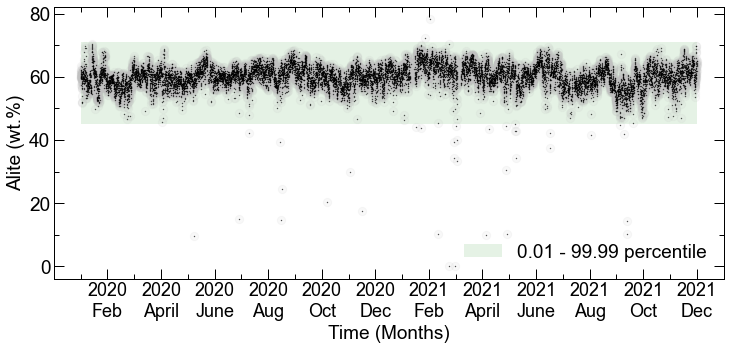

In [695]:
s = 19                                      
matplotlib.rcParams['axes.linewidth'] = 1
w =1

lower_lim = 45
higher_lim = 71
figure, ax = plt.subplots(figsize=(12,5))  #dimgray
# ax.plot([i+1 for i in range(len(values2))],values2, label = 'NO$_{x}$ emission profile', color = 'darkblue' )


ax.xaxis.set_major_locator(ticker.MultipleLocator(91527.56))
ax.set_xlim(- int(len(values_raw)/23),len(values_raw)+ int(len(values_raw)/23))

a, b, c = int(len(values_raw)/23),len(values_raw), int((len(values_raw)/23)*2)
_= ax.set_xticks([i for i in range(a,b,c)], labels = ['2020\nFeb', '2020\nApril', '2020\nJune', '2020\nAug', '2020\nOct', '2020\nDec','2021\nFeb', '2021\nApril', '2021\nJune', '2021\nAug', '2021\nOct', '2021\nDec'], rotation = 0, fontsize= 18, fontweight= 'normal')
_= plt.yticks([0,20,40,60,80],[0,20,40,60,80], rotation = 0, fontsize=s, fontweight= 'normal')
#
_= ax.tick_params(which = 'major', width= 1, length =10,)
_= ax.tick_params(which = 'minor', width= 1, length =5)
_= ax.tick_params(axis='x', direction ='in', which = 'both')
_= ax.tick_params(axis='y', direction ='in', which = 'both')
_= ax.tick_params(axis='y', which='major', right= True)
_= ax.tick_params(axis='y', which='minor', right= True)
_= ax.tick_params(axis='y', which='major', left= True)
_= ax.tick_params(axis='y', which='minor', left= True)
_= ax.tick_params(axis='x', which='major', top = True)
_= ax.tick_params(axis='x', which='minor', top = True)
_= ax.set_ylabel('Alite (wt.%)', fontsize=s, fontweight='normal')
_= ax.set_xlabel('Time (Months)', fontsize=s, fontweight='normal')
_= ax.xaxis.set_minor_locator(AutoMinorLocator(2))
_= ax.yaxis.set_minor_locator(AutoMinorLocator(2))
x_left, y_left, width, height = (0,lower_lim,len(values_raw),(higher_lim-lower_lim))
rect=mpatches.Rectangle((x_left,y_left),width,height, 
                        facecolor = "green",
                        alpha = 0.1,
                        label = f'0.01 - 99.99 percentile')    #({lower_lim}% - {higher_lim}%)
_= plt.gca().add_patch(rect)

ax.scatter([i+1 for i in range(len(values_raw))],values_raw,  color = 'silver', alpha = 0.1,s = 70)  
ax.scatter([i+1 for i in range(len(values_raw))],values_raw,color = 'black',s = 0.1)   #, alpha = 1, edgecolors='black', linewidth =1
_= ax.legend(prop= {'weight':'normal', 'size':s}, loc= 'lower right', frameon= False)
plt.savefig('/Users/sheikhjunaidfayaz/Documents/Papers/Innovandi/Phase_prediction/Figures/alite_dist_1.tiff',format='tiff', dpi=1200)
plt.show()


### Frequency distribution

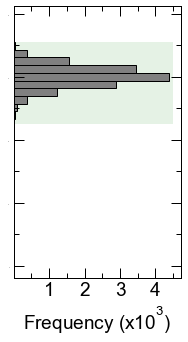

In [696]:
s = 19                                      
matplotlib.rcParams['axes.linewidth'] = 1
w =1

fig, ax = plt.subplots(figsize=(3,5))

_= plt.yticks(fontsize=0, fontweight='normal')
_= plt.xticks([1000, 2000, 3000, 4000],[1,2,3,4],fontsize=s, fontweight='normal')
_= ax.tick_params(which = 'major', width= 1, length = 10)
_= ax.tick_params(which = 'minor', width= 1, length =5)
_= ax.tick_params(axis='x', direction ='in', which = 'both')
_= ax.tick_params(axis='y', direction ='in', which = 'both')
_= ax.tick_params(axis='y', which='major', right= True)
_= ax.tick_params(axis='y', which='minor', right= True)
_= ax.tick_params(axis='y', which='major', left= True)
_= ax.tick_params(axis='y', which='minor', left= True)
_= ax.tick_params(axis='x', which='major', top = True)
_= ax.tick_params(axis='x', which='minor', top = True)

_= ax.xaxis.set_minor_locator(AutoMinorLocator(2))
_= ax.yaxis.set_minor_locator(AutoMinorLocator(2))
_= ax.set_xlabel('Frequency', fontsize = s)
x_left, y_left, width, height = (0,lower_lim,4500,(higher_lim-lower_lim))
rect=mpatches.Rectangle((x_left,y_left),width,height, 
                        facecolor = "green",
                        alpha = 0.1,
                        label = f'({lower_lim}% - {higher_lim}%)')
_= plt.gca().add_patch(rect)
_= ax.hist(values_raw, orientation = 'horizontal', color = 'gray',bins= int(1+3.3*np.log(len(values_raw)) ), ec='k')
_= ax.set_xlabel('Frequency (x10$^3$)', fontsize = s, fontweight= 'normal')
plt.savefig('/Users/sheikhjunaidfayaz/Documents/Papers/Innovandi/Phase_prediction/Figures/alite_dist_2.tiff',format='tiff', dpi=1200)
plt.show()

### Frequency distribution for filtered data

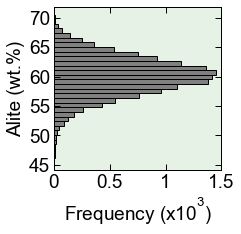

In [697]:
values1_filtered = [i for i in values_raw if i >=45 and  i <=71 ]
sz = 19                                      
matplotlib.rcParams['axes.linewidth'] = 1
w =1

fig, ax = plt.subplots(figsize=(3,3))
_=plt.xlim(0,1500)
_= ax.hist(values1_filtered, orientation = 'horizontal', color = 'gray',bins= int(1+3.3*np.log(len(values1_filtered)) ), ec= 'k')
_= plt.yticks(fontsize=15, fontweight='normal')
_= plt.xticks([0,500,1000,1500],[0,0.5,1,1.5],fontsize=s, fontweight='normal')
_= plt.yticks([45,50,55,60,65,70],[45,50,55,60,65,70],fontsize=sz, fontweight='normal')
_= ax.tick_params(which = 'major', width= 1, length =6)
_= ax.tick_params(which = 'minor', width= 1, length =0)
_= ax.tick_params(axis='x', direction ='in', which = 'both')
_= ax.tick_params(axis='y', direction ='in', which = 'both')
_= ax.tick_params(axis='y', which='major', right= True)
_= ax.tick_params(axis='y', which='minor', right= True)
_= ax.tick_params(axis='y', which='major', left= True)
_= ax.tick_params(axis='y', which='minor', left= True)
_= ax.tick_params(axis='x', which='major', top = True)
_= ax.tick_params(axis='x', which='minor', top = True)
_= plt.xticks(fontsize=sz, fontweight='normal', rotation = 0)
_= ax.set_xlabel('Frequency', fontsize = sz)
_= plt.yticks(fontsize=sz)
_= ax.patch.set_facecolor('green')
_= ax.patch.set_alpha(0.1)
_= ax.set_ylabel('Alite (wt.%)', fontsize=sz, fontweight='normal')
_= ax.set_xlabel('Frequency (x10$^3$)', fontsize = sz, fontweight= 'normal')
plt.savefig('/Users/sheikhjunaidfayaz/Documents/Papers/Innovandi/Phase_prediction/Figures/alite_dist_3.tiff',format='tiff', dpi=1200)
plt.show()

# Read files here

In [ ]:
db2 = pd.read_csv('./Data/db2_clinker.csv')

hot_meal = db2[db2['material_type'] == 'hot_meal']
kiln_feed = db2[db2['material_type'] == 'kiln_feed']
clk = db2[db2['material_type'] == 'clinker']

hot_meal.drop(columns= ['sample_date', 'sample_id_plant','material_type' ], inplace = True)
kiln_feed.drop(columns= ['sample_date', 'sample_id_plant','material_type' ], inplace = True)
clk.drop(columns= ['sample_date', 'sample_id_plant','material_type' ], inplace = True)

# Data visualization

### Corelation matrix

In [ ]:
df = X.copy(deep = True)
corr_df = df.corr(method = 'pearson')
fig, ax = plt.subplots(figsize=(30,30))
mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)
sns.heatmap(corr_df, mask=mask_ut,annot = True,xticklabels = False, yticklabels = False,  cmap=sns.diverging_palette(230, 20, as_cmap=True))

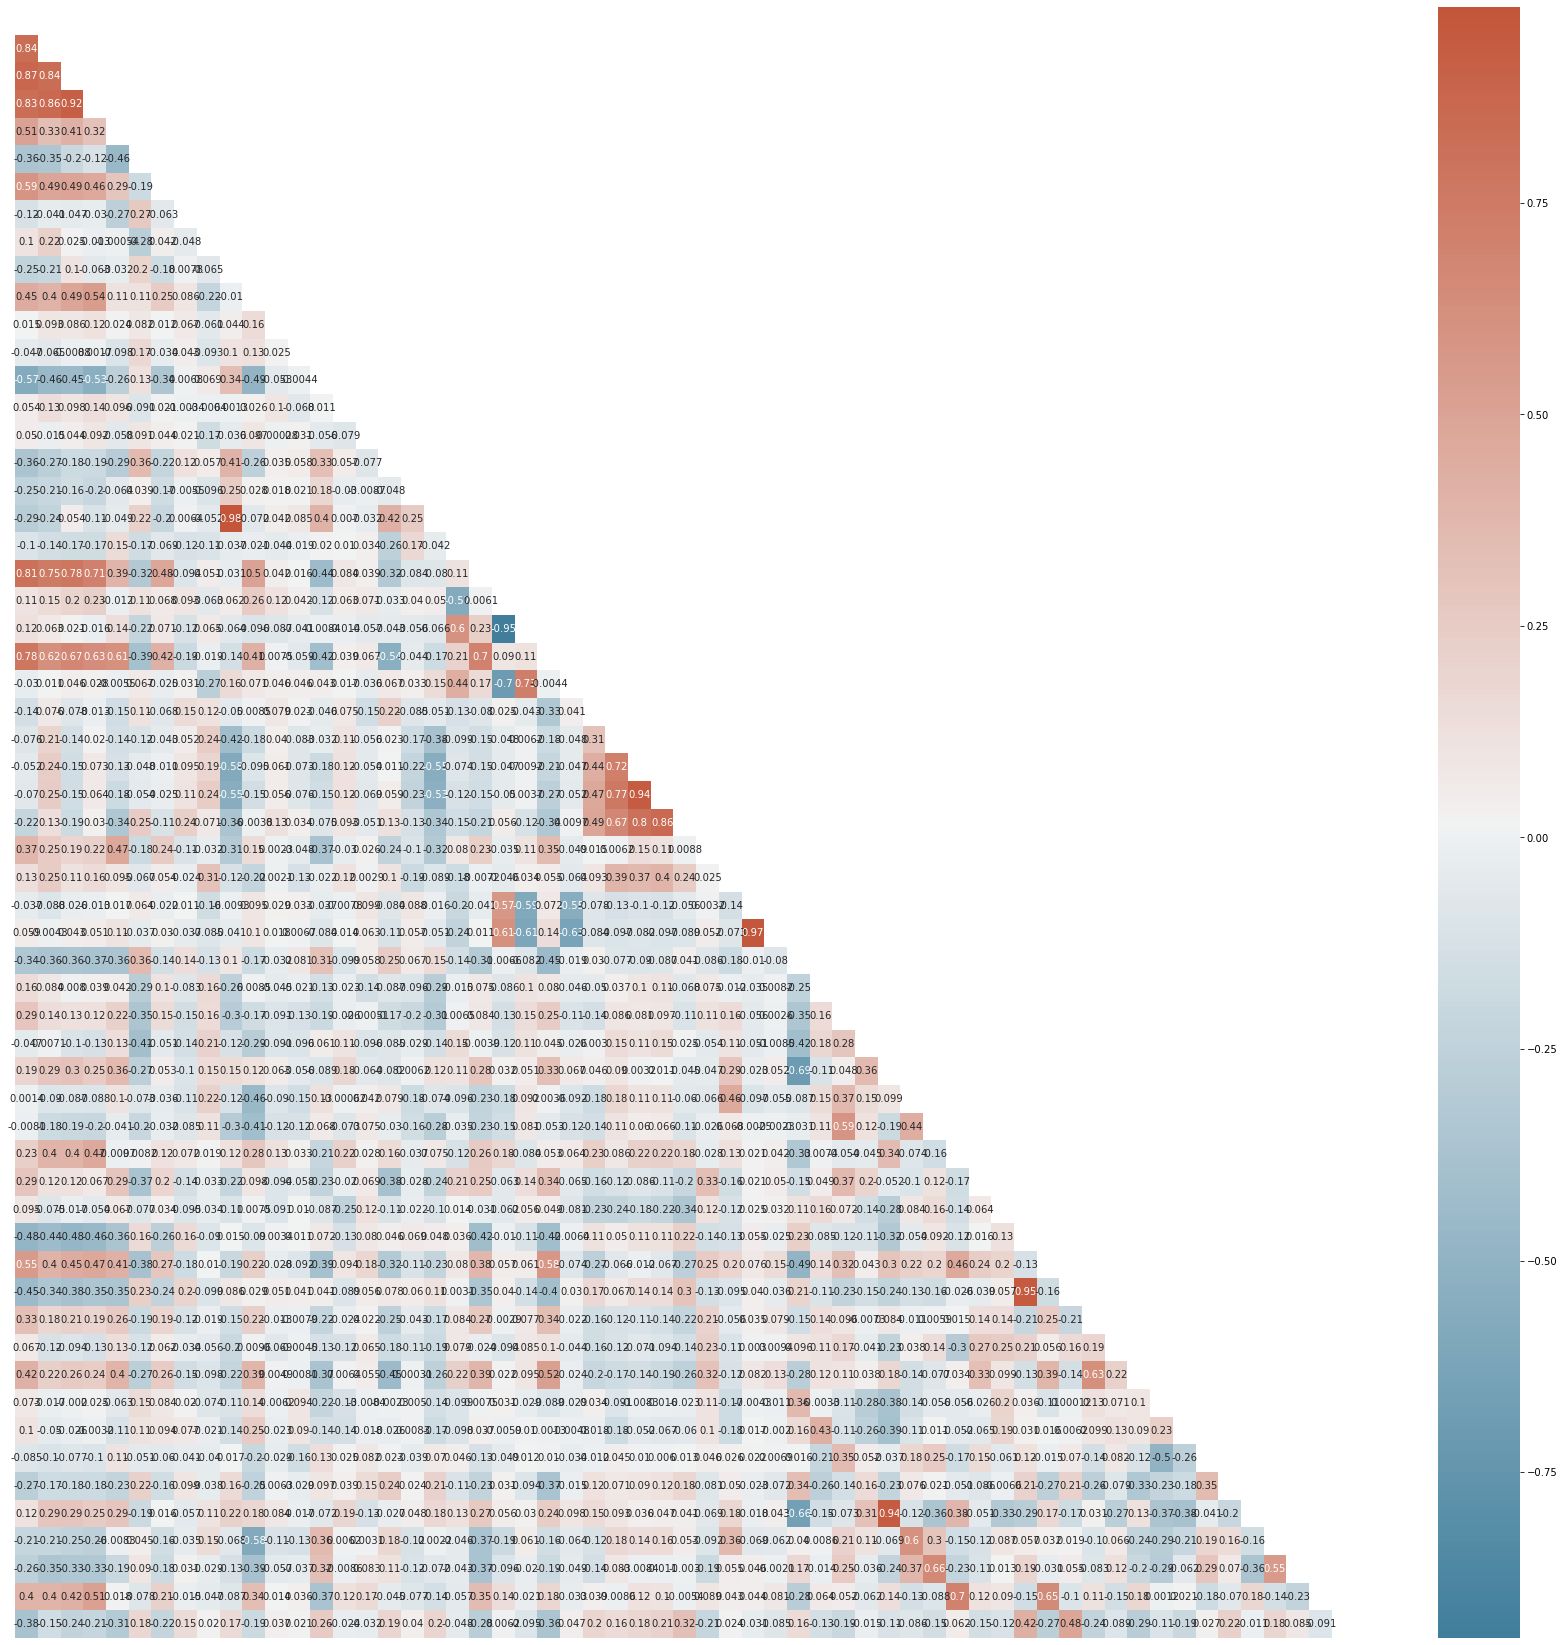

# Visualizing the train and test set



The filtered parent set is partioned into train and test set

In [716]:
df = that1[['alite', 'belite','ferrite']]  # df has the output phases
X_train, X_test, y_train, y_test= train_test_split(that1,df,test_size=0.20,random_state=100) # earlier 100, # this needs df and that1

train = y_train['alite'].to_list()  # for visualizing alite
test = y_test['alite'].to_list()
raw = df['alite'].to_list()

# train = y_train['belite'].to_list()  # for visualizing belite
# test = y_test['belite'].to_list()
# raw = df['belite'].to_list()

# phase = 'ferrite'                    # for visualizing ferrite
# train = y_train[phase].to_list()
# test = y_test[phase].to_list()
# raw = df[phase].to_list()

mean = np.round(df[phase].describe()['mean'], 1)
min =  np.round(df[phase].describe()['min'], 1)
max =  np.round(df[phase].describe()['max'], 1)
std =  np.round(df[phase].describe()['std'], 1)


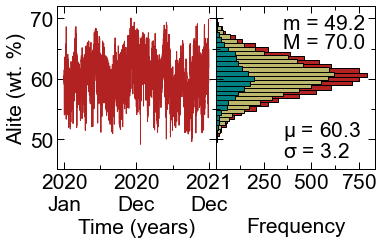

In [707]:
matplotlib.rcParams['axes.linewidth'] = 1
s = 21
fig, ax = plt.subplots(1,2,figsize=(5.7,3),squeeze = False, sharey='col' )
plt.subplots_adjust(wspace=0)

_= ax[0,0].set_ylim(45,72)
_= ax[0,0].set_yticks([50,60,70],[50,60,70],fontsize = s, fontweight = 'normal')
_=ax[0,0].set_xlabel('Time (years)', fontweight = 'normal', fontsize = s)
_=ax[0,0].set_xticks([0,len(raw)/2 ,len(raw)], labels = ['2020\nJan','2020\nDec' ,'2021\nDec'], fontsize = s, fontweight= 'normal')
_=ax[0,0].plot(np.arange(0,len(raw)), raw, linewidth=1, color= 'firebrick')
_= ax[0,0].tick_params(which = 'major', width= 1, length =7)
_= ax[0,0].tick_params(which = 'minor', width= 1, length =4)
_= ax[0,0].tick_params(axis='x', direction ='in', which = 'both')
_= ax[0,0].tick_params(axis='y', direction ='in', which = 'both')
_= ax[0,0].tick_params(axis='y', which='major', right= True)
_= ax[0,0].tick_params(axis='y', which='minor', right= True)
_= ax[0,0].tick_params(axis='y', which='major', left= True)
_= ax[0,0].tick_params(axis='y', which='minor', left= True)
_= ax[0,0].tick_params(axis='x', which='major', top = True)
_= ax[0,0].tick_params(axis='x', which='minor', top = True)
_= ax[0,0].set_ylabel('Alite (wt. %)', fontsize=s, fontweight='normal')
# _= plt.ylim(10.5,17.5)
_= plt.xticks([250,500,750],fontsize = s, fontweight = 'normal')
_= plt.yticks(fontsize = 0, fontweight = 'normal')
_= ax[0,1].set_xlabel('Frequency', fontsize=s, fontweight='normal', labelpad = 25)
_= ax[0,1].set_ylim(45,72)
# _= ax.set_xlabel('$Ferrite, C_{4}AF$ (%)', fontsize=s, fontweight='normal')
_= ax[0,1].tick_params(which = 'major', width= 1, length =7)
_= ax[0,1].tick_params(which = 'minor', width= 1, length =4)
_= ax[0,1].tick_params(axis='x', direction ='in', which = 'both')
_= ax[0,1].tick_params(axis='y', direction ='in', which = 'both')
_= ax[0,1].tick_params(axis='y', which='major', right= True)
_= ax[0,1].tick_params(axis='y', which='minor', right= True)
_= ax[0,1].tick_params(axis='y', which='major', left= True)
_= ax[0,1].tick_params(axis='y', which='minor', left= True)
_= ax[0,1].tick_params(axis='x', which='major', top = True)
_= ax[0,1].tick_params(axis='x', which='minor', top = True)

_ = plt.hist(raw, bins = int(1+3.3*np.log(len(raw))), ec= 'k', color = 'firebrick', density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
_ = plt.hist(train, bins = int(1+3.3*np.log(len(train))), ec= 'k', color = 'darkkhaki', density = False, label = 'train set', alpha = 1, orientation= 'horizontal')
_ = plt.hist(test, bins = int(1+3.3*np.log(len(test))), ec= 'k', color = 'teal', density = False, label = 'test set', alpha = 1, orientation= 'horizontal')

_= plt.text(350,47, f'$\mu$ = {mean}\n$\sigma$ = {std}', linespacing=1 ,fontsize=s, fontweight='normal') #verticalalignment='bottom'
_= plt.text(350,65, f'm = {min}\nM = {max}', linespacing=1 ,fontsize=s, fontweight='normal')
plt.savefig('/Users/sheikhjunaidfayaz/Documents/Papers/Innovandi/Phase_prediction/Figures/alite_stat.tiff',format='tiff', dpi=1200)
_= plt.show()

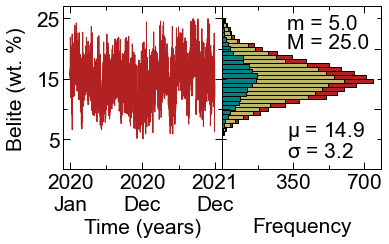

In [715]:
matplotlib.rcParams['axes.linewidth'] = 1
s = 21
fig, ax = plt.subplots(1,2,figsize=(5.7,3),squeeze = False, sharey='col' )
plt.subplots_adjust(wspace=0)

_= ax[0,0].set_ylim(0,27)
_= ax[0,0].set_yticks([5,15,25],[5,15,25],fontsize = s, fontweight = 'normal')
_=ax[0,0].set_xlabel('Time (years)', fontweight = 'normal', fontsize = s)
_=ax[0,0].set_xticks([0,len(raw)/2 ,len(raw)], labels = ['2020\nJan','2020\nDec' ,'2021\nDec'], fontsize = s, fontweight= 'normal')
_=ax[0,0].plot(np.arange(0,len(raw)), raw, linewidth=1, color= 'firebrick')
_= ax[0,0].tick_params(which = 'major', width= 1, length =7)
_= ax[0,0].tick_params(which = 'minor', width= 1, length =4)
_= ax[0,0].tick_params(axis='x', direction ='in', which = 'both')
_= ax[0,0].tick_params(axis='y', direction ='in', which = 'both')
_= ax[0,0].tick_params(axis='y', which='major', right= True)
_= ax[0,0].tick_params(axis='y', which='minor', right= True)
_= ax[0,0].tick_params(axis='y', which='major', left= True)
_= ax[0,0].tick_params(axis='y', which='minor', left= True)
_= ax[0,0].tick_params(axis='x', which='major', top = True)
_= ax[0,0].tick_params(axis='x', which='minor', top = True)
_= ax[0,0].set_ylabel('Belite (wt. %)', fontsize=s, fontweight='normal',labelpad = 10)
# _= plt.text(250,4.4, f'Mean,$\mu$ = {mean}\nStd dev,$\sigma$ = {std}', linespacing=1 ,fontsize=s, fontweight='normal') #verticalalignment='bottom'
# _= plt.text(250,20.5, f'Min = {min}\nMax = {max}', linespacing=1 ,fontsize=s, fontweight='normal')

_= ax[0,1].set_ylim(0,27)
_= plt.xticks([350, 700],fontsize = s, fontweight = 'normal')
_= plt.yticks(fontsize = 0, fontweight = 'normal')
_= ax[0,1].set_xlabel('Frequency', fontsize=s, fontweight='normal' ,labelpad = 25)
# _= ax.set_xlabel('$Ferrite, C_{4}AF$ (%)', fontsize=s, fontweight='normal')
_= ax[0,1].tick_params(which = 'major', width= 1, length =7)
_= ax[0,1].tick_params(which = 'minor', width= 1, length =4)
_= ax[0,1].tick_params(axis='x', direction ='in', which = 'both')
_= ax[0,1].tick_params(axis='y', direction ='in', which = 'both')
_= ax[0,1].tick_params(axis='y', which='major', right= True)
_= ax[0,1].tick_params(axis='y', which='minor', right= True)
_= ax[0,1].tick_params(axis='y', which='major', left= True)
_= ax[0,1].tick_params(axis='y', which='minor', left= True)
_= ax[0,1].tick_params(axis='x', which='major', top = True)
_= ax[0,1].tick_params(axis='x', which='minor', top = True)

_ = plt.hist(raw, bins = int(1+3.3*np.log(len(raw))), ec= 'k', color = 'firebrick', density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
_ = plt.hist(train, bins = int(1+3.3*np.log(len(train))), ec= 'k', color = 'darkkhaki', density = False, label = 'train set', alpha = 1, orientation= 'horizontal')
_ = plt.hist(test, bins = int(1+3.3*np.log(len(test))), ec= 'k', color = 'teal', density = False, label = 'test set', alpha = 1, orientation= 'horizontal')
# _= plt.text(250,4.4, f'Mean,$\mu$ = {mean}\nStd dev,$\sigma$ = {std}', linespacing=1 ,fontsize=s, fontweight='normal') #verticalalignment='bottom'
# _= plt.text(250,20.5, f'Min = {min}\nMax = {max}', linespacing=1 ,fontsize=s, fontweight='normal')
# _= ax.legend(prop= {'weight':'normal', 'size':12}, frameon= False,loc= 'upper left' )  #bbox_to_anchor=(1.02, 1.02)
_= plt.text(320,2, f'$\mu$ = {mean}\n$\sigma$ = {std}', linespacing=1 ,fontsize=s, fontweight='normal') #verticalalignment='bottom'
_= plt.text(320,20, f'm = {min}\nM = {max}', linespacing=1 ,fontsize=s, fontweight='normal')
plt.savefig('/Users/sheikhjunaidfayaz/Documents/Papers/Innovandi/Phase_prediction/Figures/belite_stat.tiff',format='tiff', dpi=1200)
plt.show()
                                            

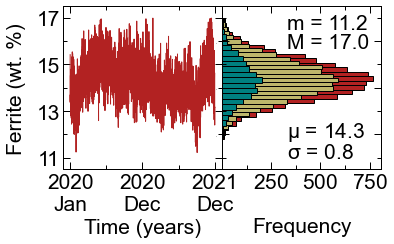

In [737]:
matplotlib.rcParams['axes.linewidth'] = 1
s = 21
fig, ax = plt.subplots(1,2,figsize=(5.7,3),squeeze = False, sharey='col' )
plt.subplots_adjust(wspace=0)

_= ax[0,0].set_ylim(10.5,17.5)
_= ax[0,0].set_yticks([11,13,15,17],[11,13,15,17],fontsize = s, fontweight = 'normal')
_=ax[0,0].set_xlabel('Time (years)', fontweight = 'normal', fontsize = s)
_=ax[0,0].set_xticks([0,len(raw)/2 ,len(raw)], labels = ['2020\nJan','2020\nDec' ,'2021\nDec'], fontsize = s, fontweight= 'normal')
_=ax[0,0].plot(np.arange(0,len(raw)), raw, linewidth=1, color= 'firebrick')
_= ax[0,0].tick_params(which = 'major', width= 1, length =7)
_= ax[0,0].tick_params(which = 'minor', width= 1, length =4)
_= ax[0,0].tick_params(axis='x', direction ='in', which = 'both')
_= ax[0,0].tick_params(axis='y', direction ='in', which = 'both')
_= ax[0,0].tick_params(axis='y', which='major', right= True)
_= ax[0,0].tick_params(axis='y', which='minor', right= True)
_= ax[0,0].tick_params(axis='y', which='major', left= True)
_= ax[0,0].tick_params(axis='y', which='minor', left= True)
_= ax[0,0].tick_params(axis='x', which='major', top = True)
_= ax[0,0].tick_params(axis='x', which='minor', top = True)
_= ax[0,0].set_ylabel('Ferrite (wt. %)', fontsize=s, fontweight='normal',labelpad = 10)
# _= plt.text(250,4.4, f'Mean,$\mu$ = {mean}\nStd dev,$\sigma$ = {std}', linespacing=1 ,fontsize=s, fontweight='normal') #verticalalignment='bottom'
# _= plt.text(250,20.5, f'Min = {min}\nMax = {max}', linespacing=1 ,fontsize=s, fontweight='normal')

_= ax[0,1].set_ylim(10.5,17.5)
_= plt.xticks([250,500,750],fontsize = s, fontweight = 'normal')
_= plt.yticks(fontsize = 0, fontweight = 'normal')
_= ax[0,1].set_xlabel('Frequency', fontsize=s, fontweight='normal', labelpad = 25)
# _= ax.set_xlabel('$Ferrite, C_{4}AF$ (%)', fontsize=s, fontweight='normal')
_= ax[0,1].tick_params(which = 'major', width= 1, length =7)
_= ax[0,1].tick_params(which = 'minor', width= 1, length =4)
_= ax[0,1].tick_params(axis='x', direction ='in', which = 'both')
_= ax[0,1].tick_params(axis='y', direction ='in', which = 'both')
_= ax[0,1].tick_params(axis='y', which='major', right= True)
_= ax[0,1].tick_params(axis='y', which='minor', right= True)
_= ax[0,1].tick_params(axis='y', which='major', left= True)
_= ax[0,1].tick_params(axis='y', which='minor', left= True)
_= ax[0,1].tick_params(axis='x', which='major', top = True)
_= ax[0,1].tick_params(axis='x', which='minor', top = True)

_ = plt.hist(raw, bins = int(1+3.3*np.log(len(raw))), ec= 'k', color = 'firebrick', density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
_ = plt.hist(train, bins = int(1+3.3*np.log(len(train))), ec= 'k', color = 'darkkhaki', density = False, label = 'train set', alpha = 1, orientation= 'horizontal')
_ = plt.hist(test, bins = int(1+3.3*np.log(len(test))), ec= 'k', color = 'teal', density = False, label = 'test set', alpha = 1, orientation= 'horizontal')
# _= plt.text(250,4.4, f'Mean,$\mu$ = {mean}\nStd dev,$\sigma$ = {std}', linespacing=1 ,fontsize=s, fontweight='normal') #verticalalignment='bottom'
# _= plt.text(250,20.5, f'Min = {min}\nMax = {max}', linespacing=1 ,fontsize=s, fontweight='normal')
# _= ax.legend(prop= {'weight':'normal', 'size':12}, frameon= False,loc= 'upper left' )  #bbox_to_anchor=(1.02, 1.02)
_= plt.text(330,11, f'$\mu$ = {mean}\n$\sigma$ = {std}', linespacing=1 ,fontsize=s, fontweight='normal') #verticalalignment='bottom'
_= plt.text(330,15.7, f'm = {min}\nM = {max}', linespacing=1 ,fontsize=s, fontweight='normal')
plt.savefig('/Users/sheikhjunaidfayaz/Documents/Papers/Innovandi/Phase_prediction/Figures/ferrite_stat.tiff',format='tiff', dpi=1200)                                         
_=plt.show()

# Raw versus filtered data

# Visualizing raw vs filtered process parameters

Define color combination for ploting

In [ ]:
foreground = 'darkgoldenrod'
background= 'teal'

Define y-axis labels for ploting process variables

In [ ]:
pp_units_list = [s.split('\n')[-1] for s in pp_naming_list]
# pp_naming_list = [item.replace('\n', ' ') for item in pp_naming_list] # Keeping units in the same line
pp_notation_list = [f'P$_{{{i}}}$' for i in range(1, 35)]
pp_naming_list = [a+ ' ' + b for a,b in zip(pp_notation_list,pp_units_list)]

Ploting process variables

0


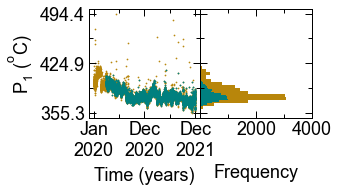

1


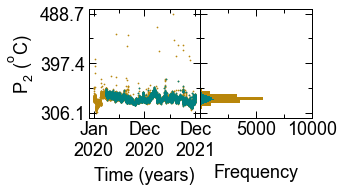

2


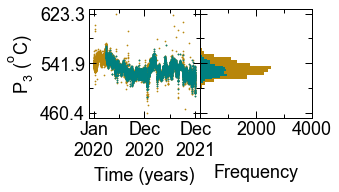

3


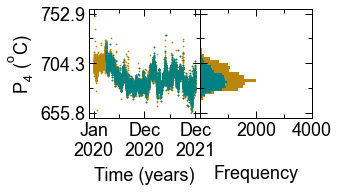

4


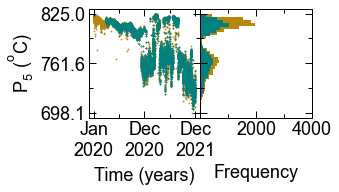

5


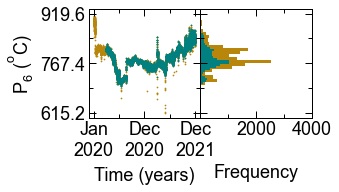

6


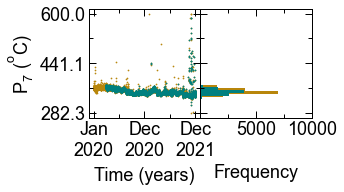

7


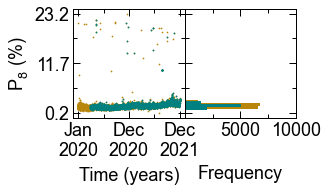

8


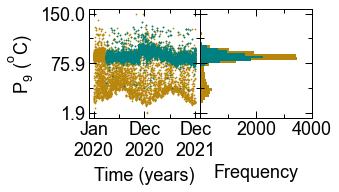

9


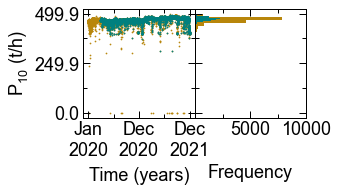

10


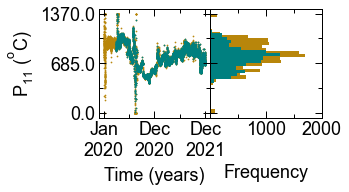

11


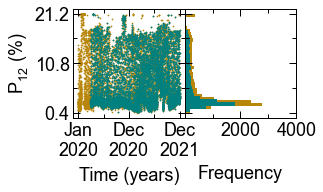

12


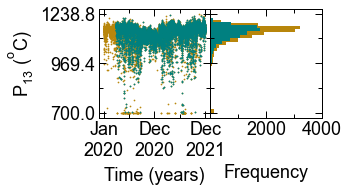

13


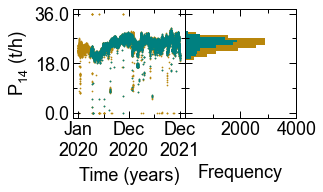

14


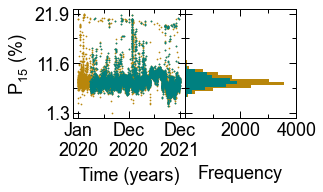

15


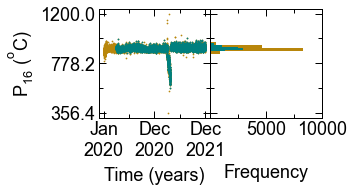

16


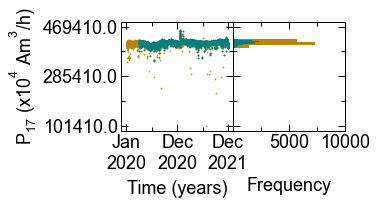

17


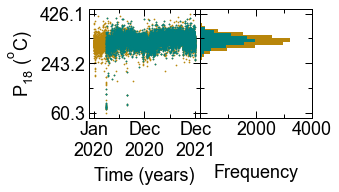

18


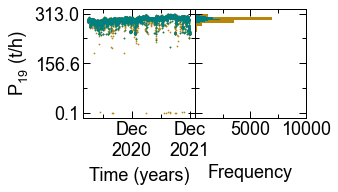

19


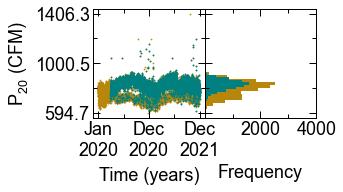

20


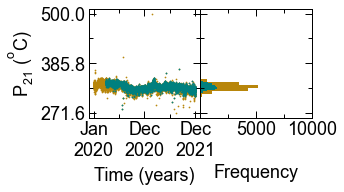

21


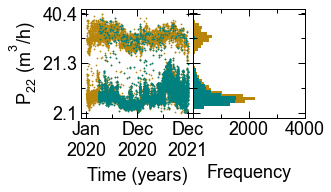

22


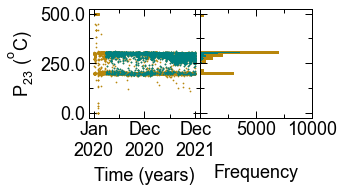

23


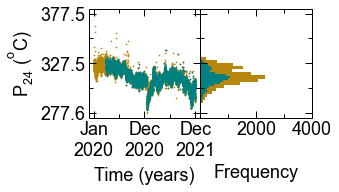

24


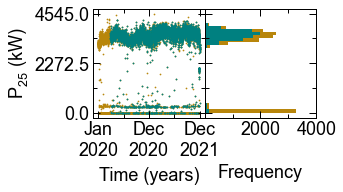

25


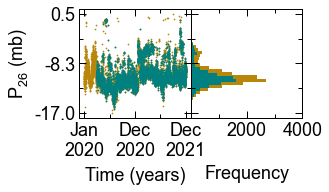

26


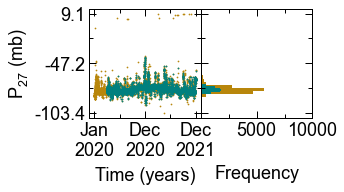

27


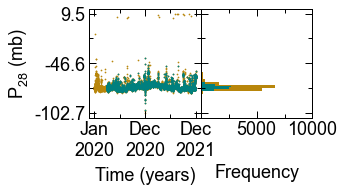

28


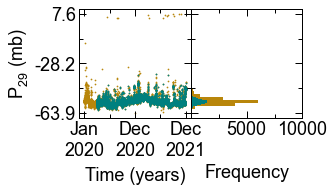

29


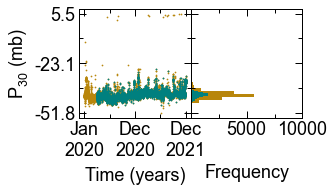

30


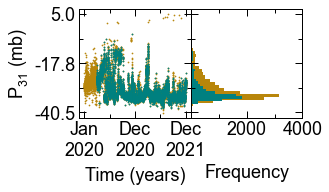

31


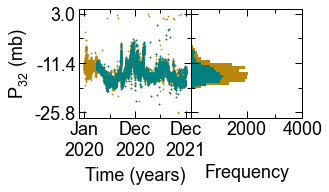

32


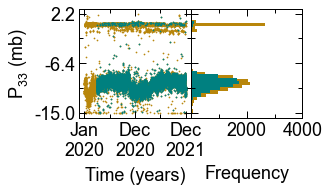

33


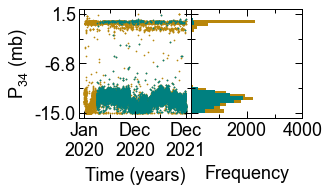

In [186]:
matplotlib.rcParams['axes.linewidth'] = 1
variable = pp.copy(deep= True)
filter_var = pp_filtered.copy(deep= True)
filter_var.reset_index(inplace = True)
x_vals = list(filter_var['index'].values)
filter_var.drop(columns=['index'], inplace = True)
s = 18
n = 0
for column in variable:
    print(n)
    # if column == 'Flue gas O2 content (calciner outlet)':
    #     continue
    fig, ax = plt.subplots(1,2,figsize=(4,2),squeeze = False, sharey='col' )
    plt.subplots_adjust(wspace=0)
    raw = variable[column].values
    # raw = [x for x in raw if not np.isnan(x)]  # removing Nan. Becs they are not plotted
    filtered_raw = filter_var[column].values
    [a, b] = list(variable.describe()[column][['min', 'max']])
    mini,mid, maxi = average(a, b)
    _= ax[0,0].set_yticks([mini,mid, maxi],[mini,mid, maxi],fontsize = s, fontweight = 'normal') 
    _=ax[0,0].set_xlabel('Time (years)', fontweight = 'normal', fontsize = s,labelpad = 7)
    _=ax[0,0].set_xticks([0,len(raw)/2 ,len(raw)], labels = ['Jan\n2020','Dec\n2020' ,'Dec\n2021'], fontsize = s, fontweight= 'normal')
    # _=ax[0,0].plot(np.arange(0,len(raw)), raw, linewidth=1, color= foreground)
    # _=ax[0,0].plot(x_vals, filtered_raw, linewidth=1, color= background)
    _=ax[0,0].scatter(np.arange(0,len(raw)), raw, s=0.5, color= foreground)
    _=ax[0,0].scatter(x_vals, filtered_raw, s=0.5, color= background)

    _= ax[0,0].tick_params(which = 'major', width= 1, length =7)
    _= ax[0,0].tick_params(which = 'minor', width= 1, length =4)
    _= ax[0,0].tick_params(axis='x', direction ='in', which = 'both')
    _= ax[0,0].tick_params(axis='y', direction ='in', which = 'both')
    _= ax[0,0].tick_params(axis='y', which='major', right= True)
    _= ax[0,0].tick_params(axis='y', which='minor', right= True)
    _= ax[0,0].tick_params(axis='y', which='major', left= True)
    _= ax[0,0].tick_params(axis='y', which='minor', left= True)
    _= ax[0,0].tick_params(axis='x', which='major', top = True)
    _= ax[0,0].tick_params(axis='x', which='minor', top = True)
    _= ax[0,0].set_ylabel(pp_naming_list[n], fontsize=s, fontweight='normal') #,labelpad = s


    _= ax[0,1].set_yticks([mini,mid, maxi],[mini,mid, maxi],fontsize = 0, fontweight = 'normal') 
    _= ax[0,1].set_xlabel('Frequency', fontsize=s, fontweight='normal' ,labelpad = 25)
    _= ax[0,1].tick_params(which = 'major', width= 1, length =7)
    _= ax[0,1].tick_params(which = 'minor', width= 1, length =4)
    _= ax[0,1].tick_params(axis='x', direction ='in', which = 'both')
    _= ax[0,1].tick_params(axis='y', direction ='in', which = 'both')
    _= ax[0,1].tick_params(axis='y', which='major', right= True)
    _= ax[0,1].tick_params(axis='y', which='minor', right= True)
    _= ax[0,1].tick_params(axis='y', which='major', left= True)
    _= ax[0,1].tick_params(axis='y', which='minor', left= True)
    _= ax[0,1].tick_params(axis='x', which='major', top = True)
    _= ax[0,1].tick_params(axis='x', which='minor', top = True)
    _ = plt.hist(raw, bins = int(1+3.3*np.log(len(raw))), ec= 'none', color = foreground, density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
    _ = plt.hist(filtered_raw, bins = int(1+3.3*np.log(len(filtered_raw))), ec= 'none', color = background, density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
    maxi = int(np.max(ax[0,1].get_xticks()))
    midi = int(np.max(ax[0,1].get_xticks())/2)
    _= ax[0,1].set_xticks([midi, maxi],[midi, maxi],fontsize = s, fontweight = 'normal') 
    # _= ax[0,1].text(0.32,0.65, f'$\mu$ = {mean}\n$\sigma$ = {SD}',transform=ax[0,1].transAxes ,linespacing=1 ,fontsize=s-1, fontweight='normal') #verticalalignment='bottom'
    plt.savefig(f'/Users/sheikhjunaidfayaz/Documents/saved_items/clinker_phase_prediction_paper/distributions/pp/{n}.tiff',format='tiff', dpi=1200)
    n+=1
    plt.show()
                                            

# Visualizing raw vs filtered hot meal

0


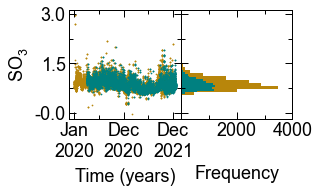

1


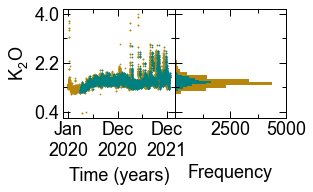

2


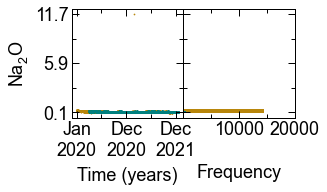

3


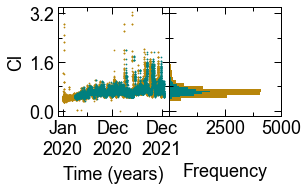

4


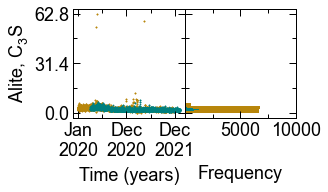

5


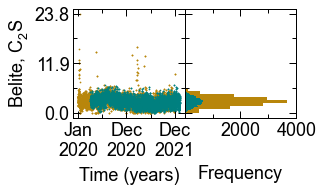

6


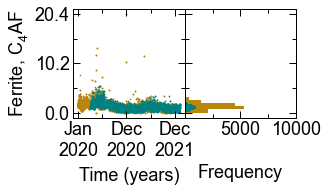

In [189]:
matplotlib.rcParams['axes.linewidth'] = 1
variable = hrm.copy(deep= True)
filter_var = hrm_filtered.copy(deep= True)
filter_var.reset_index(inplace = True)
x_vals = list(filter_var['index'].values)
filter_var.drop(columns=['index'], inplace = True)
s = 18
n = 0
for column in variable:
    print(n)
    # if column == 'Flue gas O2 content (calciner outlet)':
    #     continue
    fig, ax = plt.subplots(1,2,figsize=(4,2),squeeze = False, sharey='col' )
    plt.subplots_adjust(wspace=0)
    raw = variable[column].values
    raw = [x for x in raw if not np.isnan(x)]  # removing Nan. Becs they are not plotted
    filtered_raw = filter_var[column].values
    [a, b] = list(variable.describe()[column][['min', 'max']])
    mini,mid, maxi = average(a, b)
    _= ax[0,0].set_yticks([mini,mid, maxi],[mini,mid, maxi],fontsize = s, fontweight = 'normal') 
    _=ax[0,0].set_xlabel('Time (years)', fontweight = 'normal', fontsize = s,labelpad = 7)
    _=ax[0,0].set_xticks([0,len(raw)/2 ,len(raw)], labels = ['Jan\n2020','Dec\n2020' ,'Dec\n2021'], fontsize = s, fontweight= 'normal')
    # _=ax[0,0].plot(np.arange(0,len(raw)), raw, linewidth=1, color= foreground)
    # _=ax[0,0].plot(x_vals, filtered_raw, linewidth=1, color= background)
    _=ax[0,0].scatter(np.arange(0,len(raw)), raw, s=0.5, color= foreground)
    _=ax[0,0].scatter(x_vals, filtered_raw, s=0.5, color= background)

    _= ax[0,0].tick_params(which = 'major', width= 1, length =7)
    _= ax[0,0].tick_params(which = 'minor', width= 1, length =4)
    _= ax[0,0].tick_params(axis='x', direction ='in', which = 'both')
    _= ax[0,0].tick_params(axis='y', direction ='in', which = 'both')
    _= ax[0,0].tick_params(axis='y', which='major', right= True)
    _= ax[0,0].tick_params(axis='y', which='minor', right= True)
    _= ax[0,0].tick_params(axis='y', which='major', left= True)
    _= ax[0,0].tick_params(axis='y', which='minor', left= True)
    _= ax[0,0].tick_params(axis='x', which='major', top = True)
    _= ax[0,0].tick_params(axis='x', which='minor', top = True)
    _= ax[0,0].set_ylabel(naming_list_hrm[n], fontsize=s, fontweight='normal') #,labelpad = s

    _= ax[0,1].set_yticks([mini,mid, maxi],[mini,mid, maxi],fontsize = 0, fontweight = 'normal') 
    _= ax[0,1].set_xlabel('Frequency', fontsize=s, fontweight='normal' ,labelpad = 25)
    _= ax[0,1].tick_params(which = 'major', width= 1, length =7)
    _= ax[0,1].tick_params(which = 'minor', width= 1, length =4)
    _= ax[0,1].tick_params(axis='x', direction ='in', which = 'both')
    _= ax[0,1].tick_params(axis='y', direction ='in', which = 'both')
    _= ax[0,1].tick_params(axis='y', which='major', right= True)
    _= ax[0,1].tick_params(axis='y', which='minor', right= True)
    _= ax[0,1].tick_params(axis='y', which='major', left= True)
    _= ax[0,1].tick_params(axis='y', which='minor', left= True)
    _= ax[0,1].tick_params(axis='x', which='major', top = True)
    _= ax[0,1].tick_params(axis='x', which='minor', top = True)
    _ = plt.hist(raw, bins = int(1+3.3*np.log(len(raw))), ec= 'none', color = foreground, density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
    _ = plt.hist(filtered_raw, bins = int(1+3.3*np.log(len(filtered_raw))), ec= 'none', color = background, density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
    maxi = int(np.max(ax[0,1].get_xticks()))
    midi = int(np.max(ax[0,1].get_xticks())/2)
    _= ax[0,1].set_xticks([midi, maxi],[midi, maxi],fontsize = s, fontweight = 'normal') 
    # _= ax[0,1].text(0.32,0.65, f'$\mu$ = {mean}\n$\sigma$ = {SD}',transform=ax[0,1].transAxes ,linespacing=1 ,fontsize=s-1, fontweight='normal') #verticalalignment='bottom'
    plt.savefig(f'/Users/sheikhjunaidfayaz/Documents/saved_items/clinker_phase_prediction_paper/distributions/hrm/{n}.tiff',format='tiff', dpi=1200)
    n+=1
    plt.show()
                                            

# Visualizing raw vs filtered kiln feed

0


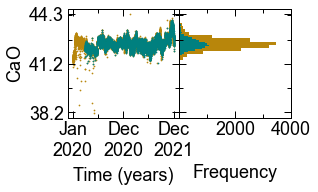

1


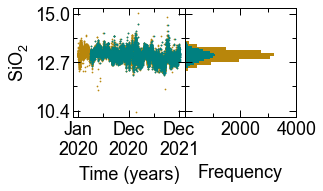

2


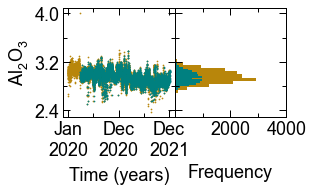

3


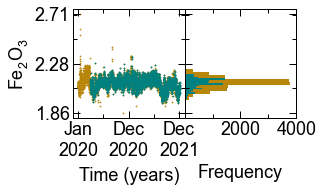

4


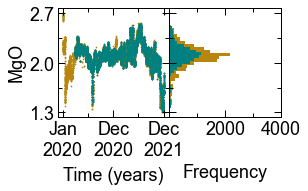

5


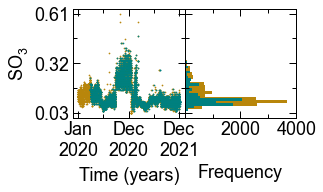

6


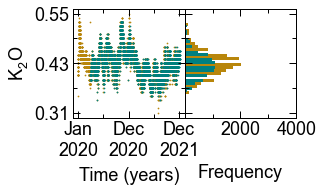

7


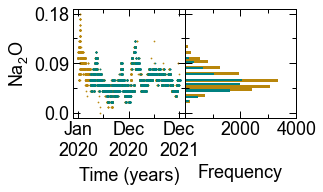

8


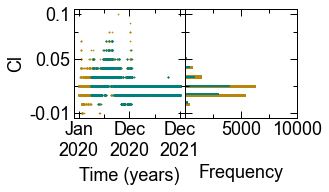

In [190]:
matplotlib.rcParams['axes.linewidth'] = 1
variable = frm.copy(deep= True)
filter_var = frm_filtered.copy(deep= True)
filter_var.reset_index(inplace = True)
x_vals = list(filter_var['index'].values)
filter_var.drop(columns=['index'], inplace = True)
s = 18
n = 0
for column in variable:
    print(n)
    # if column == 'Flue gas O2 content (calciner outlet)':
    #     continue
    fig, ax = plt.subplots(1,2,figsize=(4,2),squeeze = False, sharey='col' )
    plt.subplots_adjust(wspace=0)
    raw = variable[column].values
    raw = [x for x in raw if not np.isnan(x)]  # removing Nan. Becs they are not plotted
    filtered_raw = filter_var[column].values
    [a, b] = list(variable.describe()[column][['min', 'max']])
    mini,mid, maxi = average(a, b)

    _= ax[0,0].set_yticks([mini,mid, maxi],[mini,mid, maxi],fontsize = s, fontweight = 'normal') 
    _=ax[0,0].set_xlabel('Time (years)', fontweight = 'normal', fontsize = s,labelpad = 7)
    _=ax[0,0].set_xticks([0,len(raw)/2 ,len(raw)], labels = ['Jan\n2020','Dec\n2020' ,'Dec\n2021'], fontsize = s, fontweight= 'normal')
    # _=ax[0,0].plot(np.arange(0,len(raw)), raw, linewidth=1, color= foreground)
    # _=ax[0,0].plot(x_vals, filtered_raw, linewidth=1, color= background)
    _=ax[0,0].scatter(np.arange(0,len(raw)), raw, s=0.5, color= foreground)
    _=ax[0,0].scatter(x_vals, filtered_raw, s=0.5, color= background)

    _= ax[0,0].tick_params(which = 'major', width= 1, length =7)
    _= ax[0,0].tick_params(which = 'minor', width= 1, length =4)
    _= ax[0,0].tick_params(axis='x', direction ='in', which = 'both')
    _= ax[0,0].tick_params(axis='y', direction ='in', which = 'both')
    _= ax[0,0].tick_params(axis='y', which='major', right= True)
    _= ax[0,0].tick_params(axis='y', which='minor', right= True)
    _= ax[0,0].tick_params(axis='y', which='major', left= True)
    _= ax[0,0].tick_params(axis='y', which='minor', left= True)
    _= ax[0,0].tick_params(axis='x', which='major', top = True)
    _= ax[0,0].tick_params(axis='x', which='minor', top = True)
    _= ax[0,0].set_ylabel(naming_list_frm[n], fontsize=s, fontweight='normal') #,labelpad = s

    _= ax[0,1].set_yticks([mini,mid, maxi],[mini,mid, maxi],fontsize = 0, fontweight = 'normal') 
    _= ax[0,1].set_xlabel('Frequency', fontsize=s, fontweight='normal' ,labelpad = 25)
    _= ax[0,1].tick_params(which = 'major', width= 1, length =7)
    _= ax[0,1].tick_params(which = 'minor', width= 1, length =4)
    _= ax[0,1].tick_params(axis='x', direction ='in', which = 'both')
    _= ax[0,1].tick_params(axis='y', direction ='in', which = 'both')
    _= ax[0,1].tick_params(axis='y', which='major', right= True)
    _= ax[0,1].tick_params(axis='y', which='minor', right= True)
    _= ax[0,1].tick_params(axis='y', which='major', left= True)
    _= ax[0,1].tick_params(axis='y', which='minor', left= True)
    _= ax[0,1].tick_params(axis='x', which='major', top = True)
    _= ax[0,1].tick_params(axis='x', which='minor', top = True)
    _ = plt.hist(raw, bins = int(1+3.3*np.log(len(raw))), ec= 'none', color = foreground, density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
    _ = plt.hist(filtered_raw, bins = int(1+3.3*np.log(len(filtered_raw))), ec= 'none', color = background, density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
    maxi = int(np.max(ax[0,1].get_xticks()))
    midi = int(np.max(ax[0,1].get_xticks())/2)
    _= ax[0,1].set_xticks([midi, maxi],[midi, maxi],fontsize = s, fontweight = 'normal') 
    # _= ax[0,1].text(0.32,0.65, f'$\mu$ = {mean}\n$\sigma$ = {SD}',transform=ax[0,1].transAxes ,linespacing=1 ,fontsize=s-1, fontweight='normal') #verticalalignment='bottom'
    plt.savefig(f'/Users/sheikhjunaidfayaz/Documents/saved_items/clinker_phase_prediction_paper/distributions/frm/{n}.tiff',format='tiff', dpi=1200)
    n+=1
    plt.show()

# Visualizing raw vs filtered clinker composition

0


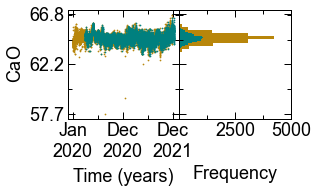

1


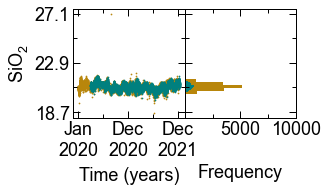

2


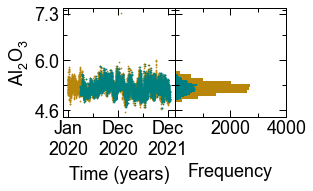

3


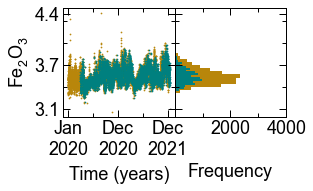

4


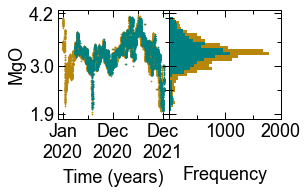

5


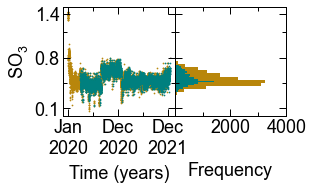

6


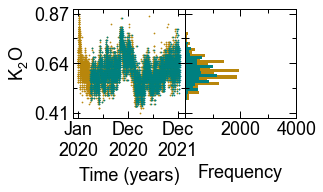

7


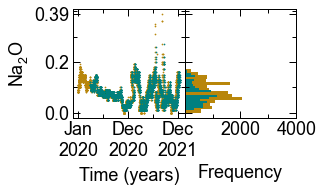

8


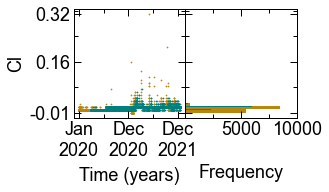

9


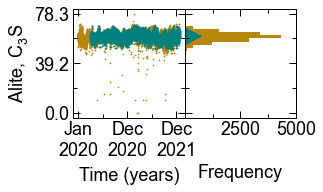

10


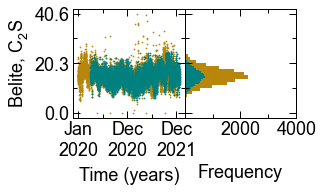

11


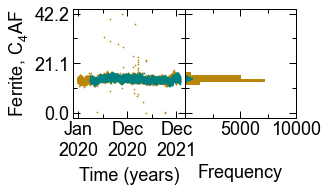

In [191]:
matplotlib.rcParams['axes.linewidth'] = 1
variable = clinker.copy(deep= True)
filter_var = clinker_filtered.copy(deep= True)
filter_var.reset_index(inplace = True)
x_vals = list(filter_var['index'].values)
filter_var.drop(columns=['index'], inplace = True)
s = 18
n = 0
for column in variable:
    print(n)
    # if column == 'Flue gas O2 content (calciner outlet)':
    #     continue
    fig, ax = plt.subplots(1,2,figsize=(4,2),squeeze = False, sharey='col' )
    plt.subplots_adjust(wspace=0)
    raw = variable[column].values
    raw = [x for x in raw if not np.isnan(x)]  # removing Nan. Becs they are not plotted
    filtered_raw = filter_var[column].values
    [a, b] = list(variable.describe()[column][['min', 'max']])
    mini,mid, maxi = average(a, b)
    _= ax[0,0].set_yticks([mini,mid, maxi],[mini,mid, maxi],fontsize = s, fontweight = 'normal') 
    _=ax[0,0].set_xlabel('Time (years)', fontweight = 'normal', fontsize = s,labelpad = 7)
    _=ax[0,0].set_xticks([0,len(raw)/2 ,len(raw)], labels = ['Jan\n2020','Dec\n2020' ,'Dec\n2021'], fontsize = s, fontweight= 'normal')
    # _=ax[0,0].plot(np.arange(0,len(raw)), raw, linewidth=1, color= foreground)
    # _=ax[0,0].plot(x_vals, filtered_raw, linewidth=1, color= background)
    _=ax[0,0].scatter(np.arange(0,len(raw)), raw, s=0.5, color= foreground)
    _=ax[0,0].scatter(x_vals, filtered_raw, s=0.5, color= background)

    _= ax[0,0].tick_params(which = 'major', width= 1, length =7)
    _= ax[0,0].tick_params(which = 'minor', width= 1, length =4)
    _= ax[0,0].tick_params(axis='x', direction ='in', which = 'both')
    _= ax[0,0].tick_params(axis='y', direction ='in', which = 'both')
    _= ax[0,0].tick_params(axis='y', which='major', right= True)
    _= ax[0,0].tick_params(axis='y', which='minor', right= True)
    _= ax[0,0].tick_params(axis='y', which='major', left= True)
    _= ax[0,0].tick_params(axis='y', which='minor', left= True)
    _= ax[0,0].tick_params(axis='x', which='major', top = True)
    _= ax[0,0].tick_params(axis='x', which='minor', top = True)
    _= ax[0,0].set_ylabel(naming_list_clk[n], fontsize=s, fontweight='normal') #,labelpad = s

    _= ax[0,1].set_yticks([mini,mid, maxi],[mini,mid, maxi],fontsize = 0, fontweight = 'normal') 
    _= ax[0,1].set_xlabel('Frequency', fontsize=s, fontweight='normal' ,labelpad = 25)
    _= ax[0,1].tick_params(which = 'major', width= 1, length =7)
    _= ax[0,1].tick_params(which = 'minor', width= 1, length =4)
    _= ax[0,1].tick_params(axis='x', direction ='in', which = 'both')
    _= ax[0,1].tick_params(axis='y', direction ='in', which = 'both')
    _= ax[0,1].tick_params(axis='y', which='major', right= True)
    _= ax[0,1].tick_params(axis='y', which='minor', right= True)
    _= ax[0,1].tick_params(axis='y', which='major', left= True)
    _= ax[0,1].tick_params(axis='y', which='minor', left= True)
    _= ax[0,1].tick_params(axis='x', which='major', top = True)
    _= ax[0,1].tick_params(axis='x', which='minor', top = True)
    _ = plt.hist(raw, bins = int(1+3.3*np.log(len(raw))), ec= 'none', color = foreground, density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
    _ = plt.hist(filtered_raw, bins = int(1+3.3*np.log(len(filtered_raw))), ec= 'none', color = background, density = False , label = 'cleaned data', alpha = 1, orientation= 'horizontal')
    maxi = int(np.max(ax[0,1].get_xticks()))
    midi = int(np.max(ax[0,1].get_xticks())/2)
    _= ax[0,1].set_xticks([midi, maxi],[midi, maxi],fontsize = s, fontweight = 'normal') 
    # _= ax[0,1].text(0.32,0.65, f'$\mu$ = {mean}\n$\sigma$ = {SD}',transform=ax[0,1].transAxes ,linespacing=1 ,fontsize=s-1, fontweight='normal') #verticalalignment='bottom'
    plt.savefig(f'/Users/sheikhjunaidfayaz/Documents/saved_items/clinker_phase_prediction_paper/distributions/clinker/{n}.tiff',format='tiff', dpi=1200)
    n+=1
    plt.show()

# Timestamp matching

# Reading clk, frm, hrm data from plant data

In [2]:
clinker = pd.read_excel('df0_df2_clk_combined.xlsx', 'clinker') # has clk, frm and hrm data: all

Separating databases

In [5]:
clk = clinker[clinker['material_type'] == 'clinker']
frm = clinker[clinker['material_type'] == 'kiln_feed']
hrm = clinker[clinker['material_type'] == 'hot_meal']

Remove unwanted cols

In [ ]:
# remove all unwanted cols except encoding in clk, frm and hrm

clk.drop(columns= ['sample_date', 'sample_id_plant','material_type', 'Unnamed: 22', 'with frm', 'with hrm' ], inplace = True)
clk.drop(columns= ['even odd' ], inplace = True)

frm.drop(columns= ['sample_date', 'sample_id_plant','material_type' ], inplace = True)
hrm.drop(columns= ['sample_date', 'sample_id_plant','material_type' ], inplace = True)
frm.drop(columns= ['with frm', 'with hrm' ], inplace = True)

hrm.drop(columns= ['with frm', 'with hrm' ], inplace = True)
frm.drop(columns= ['even odd' ], inplace = True)
hrm.drop(columns= ['even odd' ], inplace = True)

Preparing encoding and timestamp matching

In [ ]:
clk_encoding = clk['encoding'].to_list()
frm_encoding = frm['encoding'].to_list()
hrm_encoding = hrm['encoding'].to_list()

In [ ]:
frm.rename(columns={'encoding':'with frm'}, inplace = True)
hrm.rename(columns={'encoding':'with hrm'}, inplace = True)

In [ ]:
pairs = []
count = 0
for i in clk_encoding[1:]:
    count += 1
    candidate = list(range(i-10,i))
    frm_code = common_member(candidate, frm_encoding)
    hrm_code = common_member(candidate, hrm_encoding)
    if (len(hrm_code) ==0 or len(frm_code) ==0):
        pass
    else:
        pairs.append((i,max(frm_code), max(hrm_code)))

In [ ]:
a = []
b= []
c= []
for i in pairs:
    a.append(i[0])
    b.append(i[1])
    c.append(i[2])

In [ ]:
codey = pd.DataFrame({'encoding' : a,
              'with frm' : b,
              'with hrm' : c },
              columns = ['encoding','with frm',  'with hrm'])

In [ ]:
clinker = pd.merge(codey, clk, on = 'encoding') # codey =[encoding, with frm, with hrm] & clk = [encoding, clk data]
# merge clk and codely on encoding column
clinker_frm = pd.merge(clinker, frm, on ='with frm')
clk_frm_hrm = pd.merge(clinker_frm, hrm, on = 'with hrm')

Saving & reading timestamp_matched frm, hrm, clk data

In [ ]:
clinkr_frm_hrm.to_excel('now_1.xlsx', index = False) # read later while model training

clinkr_frm_hrm.to_excel('clinker_frm_hrm_combined_serially.xlsx')
clinkr_frm_hrm = pd.read_excel('clinker_frm_hrm_combined_serially.xlsx')

# Mapping_df to merge encoding with dates(timestamps)

In [ ]:
dates = pd.read_csv('db2_clinker.csv').loc[:,['encoding', 'sample_date']].head(37937)['sample_date'].to_list()
mapping_df = pd.read_csv('db2_clinker.csv').loc[:,['encoding', 'sample_date']].head(37937)
new_dates = []
for i in dates:
    new_dates.append(i[:10])
mapping_df['dates'] = new_dates   # mapping df has mapping for all the encoding to dates.

# Merge: mapping_df + clinkr_frm_hrm = totaly

In [ ]:
totaly = pd.merge(clinkr_frm_hrm, mapping_df)
totaly.rename(columns = {'sample_date':'timestamp'}, inplace = True)
totaly   # totaly has timestamps, frm, hrm, clk and mapping_df (encoding data to match with PP data)

Reading process data

In [ ]:
pp = pd.read_csv('./HC_old_data/db0_kiln.csv') # reading pp data
pp1 = pp.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,19,21,22,24,25,27,28,29,30,31,32,36,38,39,40,41,42,43,44,46, 47]] #7,48,49,50,51,52,53, 54,55,56,57
pp1 # Selecting relevant PPs from pp to form pp1

Merge: PP + totaly = now_2

In [ ]:
new = pd.merge(pp1, totaly, on = 'timestamp').iloc[:,1:] # Merge pp and totaly
len(new) # this new is read as now_2 in the code.
new.to_excel('now_2.xlsx', index = False)

14798

# Model training

# Training models with different input combinations

# frm and hrm

In [1445]:
now_1 = pd.read_excel('now_1.xlsx')
now_x = now_1.iloc[:,9:]
now_x = now_x[['cao1', 'sio21', 'al2o31', 'fe2o31',
       'mgo1', 'so31', 'k2o1', 'na2o1', 'cl1', 'so32', 'k2o2', 'na2o2', 'cl2',
       'alite2', 'belite2', 'ferrite2', 'alite', 'belite', 'ferrite']]

In [1447]:
now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

X = final_alite.iloc[:,:-1]
y = final_alite.iloc[:,-1:]

# X = final_belite.iloc[:,:-1]
# y = final_belite.iloc[:,-1:]

# X = final_ferrite.iloc[:,:-1]
# y = final_ferrite.iloc[:,-1:]

X
y

now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.10,random_state=100)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
y_train_s  = scaler.fit_transform(y_train)
y_test_s  = scaler.transform(y_test)


original length = 14964
length filtered = 13499
original length = 14964
length filtered = 13498
original length = 14964
length filtered = 13501


13474

13405

13459

cao1  sio21  al2o31  fe2o31  mgo1  so31  k2o1  na2o1   cl1  so32  \
0      41.43  13.03    3.08    2.07  2.63  0.12  0.40   0.10  0.02  0.93   
1      41.38  13.24    3.11    2.09  2.64  0.14  0.40   0.10  0.02  0.93   
2      41.49  12.93    3.11    2.07  2.59  0.12  0.40   0.10  0.02  0.92   
3      41.37  13.15    3.10    2.08  2.62  0.14  0.40   0.10  0.02  0.92   
4      41.80  13.60    2.67    2.09  2.65  0.12  0.35   0.10  0.01  0.96   
...      ...    ...     ...     ...   ...   ...   ...    ...   ...   ...   
13494  42.09  13.01    3.04    2.10  1.83  0.09  0.46   0.06  0.02  0.85   
13495  42.32  13.14    3.05    2.12  1.83  0.09  0.46   0.06  0.02  0.85   
13496  42.31  13.31    3.04    2.09  1.82  0.10  0.45   0.06  0.02  0.90   
13497  42.38  13.04    3.06    2.08  1.85  0.09  0.46   0.07  0.02  0.90   
13498  42.39  13.07    3.04    2.11  1.85  0.10  0.46   0.06  0.02  0.83   

       k2o2  na2o2   cl2  alite2  belite2  ferrite2  
0      1.35   0.24  0.44    2.75     2.69      1.75  
1      1.35   0.24  0.44    2.75     2.69      1.75  
2      1.37   0.24  0.44    1.97     3.51      1.71  
3      1.37   0.24  0.44    1.97     3.51      1.71  
4      1.39   0.24  0.47    2.91     1.84      1.70  
...     ...    ...   ...     ...      ...       ...  
13494  1.75   0.18  0.91    2.21     3.86      1.55  
13495  1.75   0.18  0.91    2.21     3.86      1.55  
13496  1.73   0.18  0.82    1.90     3.42      1.16  
13497  1.73   0.18  0.82    1.90     3.42      1.16  
13498  1.83   0.19  0.95    2.15     3.23      1.71  

[13474 rows x 16 columns]

alite
0      59.35
1      59.85
2      60.23
3      59.72
4      57.52
...      ...
13494  63.66
13495  63.34
13496  64.24
13497  64.31
13498  61.88

[13474 rows x 1 columns]

original length = 14964
length filtered = 13499
original length = 14964
length filtered = 13498
original length = 14964
length filtered = 13501


13474

13405

13459

SVR(gamma='auto')

0.62

0.53

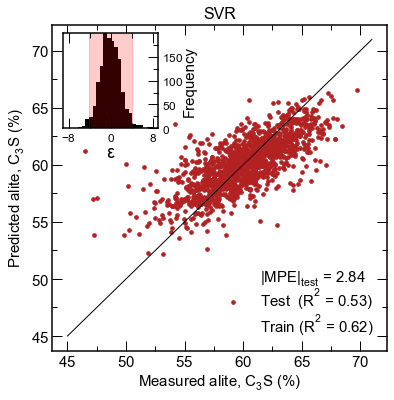

In [1448]:
# ................SVR

model = SVR(kernel = 'rbf', gamma = 'auto')
model.fit(X_train_s, y_train_s.ravel()) #used ravel() because SVR takes a 1D array as input and not a vector
                                                #so flattened the (m,1) vector to (m,)
test_pred_s =model.predict(X_test_s).reshape(-1,1)
train_pred_s =model.predict(X_train_s).reshape(-1,1)

r2_train = get_score('Training',actual=y_train,predicted=scaler.inverse_transform(train_pred_s))
r2_test= get_score('Test',actual=y_test,predicted=scaler.inverse_transform(test_pred_s))
r2_train 
r2_test


train_actual = y_train[y_train.columns[0]].to_list()
test_actual = y_test[y_test.columns[0]].to_list()
test_prediction = array_to_list(scaler.inverse_transform(test_pred_s))
train_pred =      array_to_list(scaler.inverse_transform(train_pred_s))
parity_custom(train_actual, train_pred ,test_actual , test_prediction , titles[5])

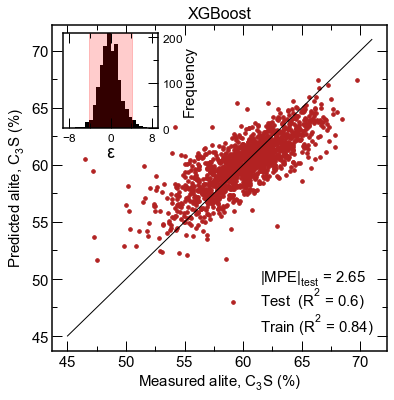

In [1451]:
# ......................XGBoost
model = XGBRegressor(

random_state = 5, subsample=0.99, reg_lambda=5,
reg_alpha=1, n_estimators=300,
min_child_weight=5, max_depth=8,
learning_rate=0.05, colsample_bytree=1, n_jobs=-1

).fit(X_train,y_train)
parity(model, X,y,  'XGBoost')

# From FRM

In [1453]:
now_x = now_1.iloc[:,9:21]
now_x = now_x[['cao1', 'sio21', 'al2o31', 'fe2o31',
 'mgo1', 'so31', 'k2o1', 'na2o1', 'cl1','alite', 'belite', 'ferrite']]

now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

X = final_alite.iloc[:,:-1]
y = final_alite.iloc[:,-1:]

# X = final_belite.iloc[:,:-1]
# y = final_belite.iloc[:,-1:]

# X = final_ferrite.iloc[:,:-1]
# y = final_ferrite.iloc[:,-1:]

X
y
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.10,random_state=100)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
y_train_s  = scaler.fit_transform(y_train)
y_test_s  = scaler.transform(y_test)

original length = 14964
length filtered = 14287
original length = 14964
length filtered = 14284
original length = 14964
length filtered = 14287


14255

14185

14241

cao1  sio21  al2o31  fe2o31  mgo1  so31  k2o1  na2o1   cl1
0      41.43  13.03    3.08    2.07  2.63  0.12  0.40   0.10  0.02
1      41.38  13.24    3.11    2.09  2.64  0.14  0.40   0.10  0.02
2      41.49  12.93    3.11    2.07  2.59  0.12  0.40   0.10  0.02
3      41.37  13.15    3.10    2.08  2.62  0.14  0.40   0.10  0.02
4      41.80  13.60    2.67    2.09  2.65  0.12  0.35   0.10  0.01
...      ...    ...     ...     ...   ...   ...   ...    ...   ...
14282  42.09  13.01    3.04    2.10  1.83  0.09  0.46   0.06  0.02
14283  42.32  13.14    3.05    2.12  1.83  0.09  0.46   0.06  0.02
14284  42.31  13.31    3.04    2.09  1.82  0.10  0.45   0.06  0.02
14285  42.38  13.04    3.06    2.08  1.85  0.09  0.46   0.07  0.02
14286  42.39  13.07    3.04    2.11  1.85  0.10  0.46   0.06  0.02

[14255 rows x 9 columns]

alite
0      59.35
1      59.85
2      60.23
3      59.72
4      57.52
...      ...
14282  63.66
14283  63.34
14284  64.24
14285  64.31
14286  61.88

[14255 rows x 1 columns]

SVR(gamma='auto')

0.38

0.33

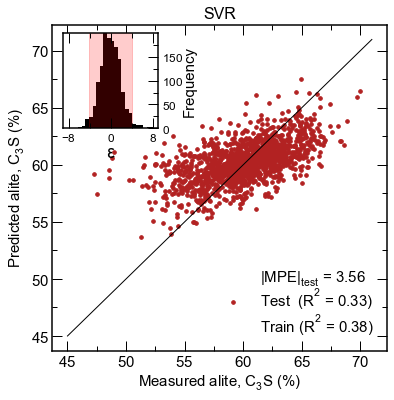

In [1454]:
# ................SVR

model = SVR(kernel = 'rbf', gamma = 'auto')
model.fit(X_train_s, y_train_s.ravel()) #used ravel() because SVR takes a 1D array as input and not a vector
                                                #so flattened the (m,1) vector to (m,)
test_pred_s =model.predict(X_test_s).reshape(-1,1)
train_pred_s =model.predict(X_train_s).reshape(-1,1)

r2_train = get_score('Training',actual=y_train,predicted=scaler.inverse_transform(train_pred_s))
r2_test= get_score('Test',actual=y_test,predicted=scaler.inverse_transform(test_pred_s))
r2_train 
r2_test


train_actual = y_train[y_train.columns[0]].to_list()
test_actual = y_test[y_test.columns[0]].to_list()
test_prediction = array_to_list(scaler.inverse_transform(test_pred_s))
train_pred =      array_to_list(scaler.inverse_transform(train_pred_s))
parity_custom(train_actual, train_pred ,test_actual , test_prediction , titles[5])

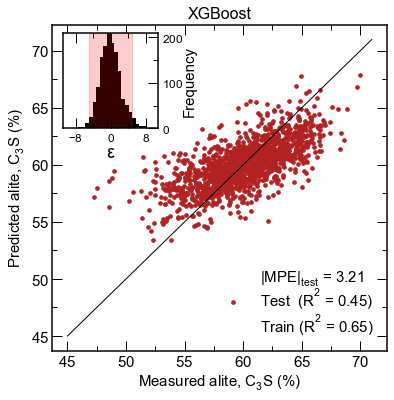

In [1456]:
# ......................XGBoost
model = XGBRegressor(

random_state = 5, subsample=0.99, reg_lambda=5,
reg_alpha=1, n_estimators=300,
min_child_weight=5, max_depth=8,
learning_rate=0.05, colsample_bytree=1, n_jobs=-1

).fit(X_train,y_train)
parity(model, X,y,  'XGBoost')

# HRM

In [1461]:
now_x = now_1.iloc[:,list(range(9,12)) + list(range(21,28))]
now_x = now_x[['so32', 'k2o2', 'na2o2', 'cl2', 'alite2',
       'belite2', 'ferrite2','alite', 'belite', 'ferrite']]

In [1465]:
now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

X = final_alite.iloc[:,:-1]
y = final_alite.iloc[:,-1:]

# X = final_belite.iloc[:,:-1]
# y = final_belite.iloc[:,-1:]

# X = final_ferrite.iloc[:,:-1]
# y = final_ferrite.iloc[:,-1:]

X
y

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.10,random_state=100)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
y_train_s  = scaler.fit_transform(y_train)
y_test_s  = scaler.transform(y_test)


original length = 14964
length filtered = 13632
original length = 14964
length filtered = 13631
original length = 14964
length filtered = 13634


13607

13535

13591

so32  k2o2  na2o2   cl2  alite2  belite2  ferrite2
0      0.93  1.35   0.24  0.44    2.75     2.69      1.75
1      0.93  1.35   0.24  0.44    2.75     2.69      1.75
2      0.92  1.37   0.24  0.44    1.97     3.51      1.71
3      0.92  1.37   0.24  0.44    1.97     3.51      1.71
4      0.96  1.39   0.24  0.47    2.91     1.84      1.70
...     ...   ...    ...   ...     ...      ...       ...
13627  0.85  1.75   0.18  0.91    2.21     3.86      1.55
13628  0.85  1.75   0.18  0.91    2.21     3.86      1.55
13629  0.90  1.73   0.18  0.82    1.90     3.42      1.16
13630  0.90  1.73   0.18  0.82    1.90     3.42      1.16
13631  0.83  1.83   0.19  0.95    2.15     3.23      1.71

[13607 rows x 7 columns]

alite
0      59.35
1      59.85
2      60.23
3      59.72
4      57.52
...      ...
13627  63.66
13628  63.34
13629  64.24
13630  64.31
13631  61.88

[13607 rows x 1 columns]

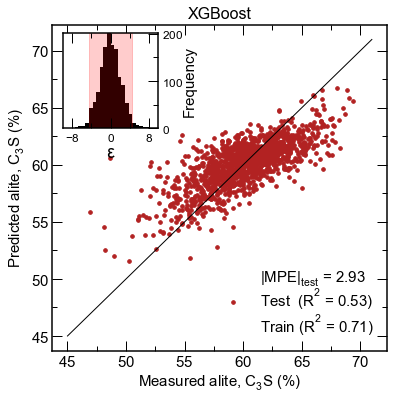

In [1470]:
model = XGBRegressor(

random_state = 5, subsample=0.99, reg_lambda=5,
reg_alpha=1, n_estimators=350,
min_child_weight=5, max_depth=8,
learning_rate=0.05, colsample_bytree=1, n_jobs=-1

).fit(X_train,y_train)
parity(model, X,y,  'XGBoost')

# HRM and clinker oxide

In [1472]:
now_x = now_1.iloc[:,list(range(21,28))+ list(range(0,12))]

now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

X = final_alite.iloc[:,:-1]
y = final_alite.iloc[:,-1:]

# X = final_belite.iloc[:,:-1]
# y = final_belite.iloc[:,-1:]

# X = final_ferrite.iloc[:,:-1]
# y = final_ferrite.iloc[:,-1:]

X
y
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.10,random_state=100)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
y_train_s  = scaler.fit_transform(y_train)
y_test_s  = scaler.transform(y_test)



original length = 14964
length filtered = 13333
original length = 14964
length filtered = 13333
original length = 14964
length filtered = 13336


13314

13240

13296

so32  k2o2  na2o2   cl2  alite2  belite2  ferrite2    cao   sio2  \
0      0.93  1.35   0.24  0.44    2.75     2.69      1.75  64.46  20.77   
1      0.93  1.35   0.24  0.44    2.75     2.69      1.75  64.29  20.78   
2      0.92  1.37   0.24  0.44    1.97     3.51      1.71  64.46  20.71   
3      0.92  1.37   0.24  0.44    1.97     3.51      1.71  64.23  20.81   
4      0.96  1.39   0.24  0.47    2.91     1.84      1.70  64.27  20.88   
...     ...   ...    ...   ...     ...      ...       ...    ...    ...   
13328  0.85  1.75   0.18  0.91    2.21     3.86      1.55  64.96  21.07   
13329  0.85  1.75   0.18  0.91    2.21     3.86      1.55  65.29  21.03   
13330  0.90  1.73   0.18  0.82    1.90     3.42      1.16  65.46  21.03   
13331  0.90  1.73   0.18  0.82    1.90     3.42      1.16  65.43  21.10   
13332  0.83  1.83   0.19  0.95    2.15     3.23      1.71  65.20  20.96   

       al2o3  fe2o3   mgo   so3   k2o  na2o    cl  
0       5.46   3.43  3.92  1.34  0.55  0.08  0.00  
1       5.43   3.46  3.90  1.41  0.62  0.09  0.00  
2       5.48   3.42  3.90  1.37  0.59  0.08  0.00  
3       5.50   3.41  3.90  1.40  0.63  0.09  0.00  
4       5.49   3.44  3.95  1.34  0.57  0.08  0.00  
...      ...    ...   ...   ...   ...   ...   ...  
13328   4.93   3.47  2.97  0.73  0.70  0.15  0.01  
13329   4.92   3.45  2.99  0.61  0.63  0.13  0.01  
13330   4.88   3.45  2.97  0.58  0.56  0.13  0.01  
13331   4.98   3.44  3.02  0.62  0.63  0.14  0.01  
13332   4.89   3.43  3.02  0.66  0.68  0.14  0.02  

[13314 rows x 16 columns]

alite
0      59.35
1      59.85
2      60.23
3      59.72
4      57.52
...      ...
13328  63.66
13329  63.34
13330  64.24
13331  64.31
13332  61.88

[13314 rows x 1 columns]

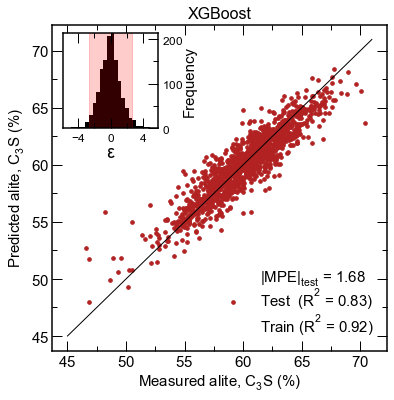

In [1482]:
model = XGBRegressor(

random_state = 5, subsample=0.99, reg_lambda=5,
reg_alpha=1, n_estimators=250,
min_child_weight=2, max_depth=8,
learning_rate=0.05, colsample_bytree=1, n_jobs=-1

).fit(X_train,y_train)
parity(model, X,y,  'XGBoost')

# From FRM and clinker oxide


In [1484]:
frm_clk = now_1.iloc[:,:-7][['cao1', 'sio21', 'al2o31', 'fe2o31','mgo1', 'so31', 'k2o1', 'na2o1', 'cl1','cao', 'sio2', 'al2o3', 'fe2o3', 'mgo', 'so3', 'k2o', 'na2o', 'cl',
'alite', 'belite', 'ferrite']]

In [1485]:
now_alite= frm_clk.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = frm_clk.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = frm_clk.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)
final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

original length = 14964
length filtered = 13965
original length = 14964
length filtered = 13963
original length = 14964
length filtered = 13966


13941

13869

13924

In [1487]:
X = final_alite.iloc[:,:-1]
y = final_alite.iloc[:,-1:]

# X = final_belite.iloc[:,:-1]
# y = final_belite.iloc[:,-1:]

# X = final_ferrite.iloc[:,:-1]
# y = final_ferrite.iloc[:,-1:]

X
y

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.10,random_state=100)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
y_train_s  = scaler.fit_transform(y_train)
y_test_s  = scaler.transform(y_test)

cao1  sio21  al2o31  fe2o31  mgo1  so31  k2o1  na2o1   cl1    cao  \
0      41.43  13.03    3.08    2.07  2.63  0.12  0.40   0.10  0.02  64.46   
1      41.38  13.24    3.11    2.09  2.64  0.14  0.40   0.10  0.02  64.29   
2      41.49  12.93    3.11    2.07  2.59  0.12  0.40   0.10  0.02  64.46   
3      41.37  13.15    3.10    2.08  2.62  0.14  0.40   0.10  0.02  64.23   
4      41.80  13.60    2.67    2.09  2.65  0.12  0.35   0.10  0.01  64.27   
...      ...    ...     ...     ...   ...   ...   ...    ...   ...    ...   
13960  42.09  13.01    3.04    2.10  1.83  0.09  0.46   0.06  0.02  64.96   
13961  42.32  13.14    3.05    2.12  1.83  0.09  0.46   0.06  0.02  65.29   
13962  42.31  13.31    3.04    2.09  1.82  0.10  0.45   0.06  0.02  65.46   
13963  42.38  13.04    3.06    2.08  1.85  0.09  0.46   0.07  0.02  65.43   
13964  42.39  13.07    3.04    2.11  1.85  0.10  0.46   0.06  0.02  65.20   

        sio2  al2o3  fe2o3   mgo   so3   k2o  na2o    cl  
0      20.77   5.46   3.43  3.92  1.34  0.55  0.08  0.00  
1      20.78   5.43   3.46  3.90  1.41  0.62  0.09  0.00  
2      20.71   5.48   3.42  3.90  1.37  0.59  0.08  0.00  
3      20.81   5.50   3.41  3.90  1.40  0.63  0.09  0.00  
4      20.88   5.49   3.44  3.95  1.34  0.57  0.08  0.00  
...      ...    ...    ...   ...   ...   ...   ...   ...  
13960  21.07   4.93   3.47  2.97  0.73  0.70  0.15  0.01  
13961  21.03   4.92   3.45  2.99  0.61  0.63  0.13  0.01  
13962  21.03   4.88   3.45  2.97  0.58  0.56  0.13  0.01  
13963  21.10   4.98   3.44  3.02  0.62  0.63  0.14  0.01  
13964  20.96   4.89   3.43  3.02  0.66  0.68  0.14  0.02  

[13941 rows x 18 columns]

alite
0      59.35
1      59.85
2      60.23
3      59.72
4      57.52
...      ...
13960  63.66
13961  63.34
13962  64.24
13963  64.31
13964  61.88

[13941 rows x 1 columns]

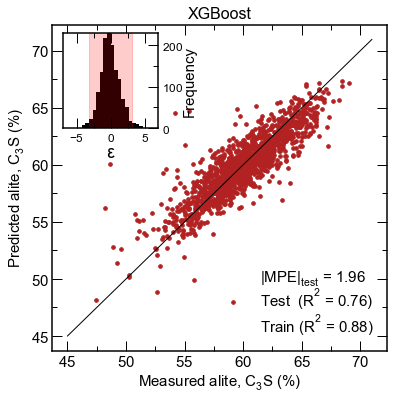

In [1492]:

# ......................XGBoost
model = XGBRegressor(

random_state = 5, subsample=0.99, reg_lambda=5,
reg_alpha=1, n_estimators=280,
min_child_weight=0, max_depth=7,
learning_rate=0.05, colsample_bytree=1, n_jobs=-1

).fit(X_train,y_train)
parity(model, X,y,  'XGBoost')

# PP and HRM

In [1493]:
now_x = now_2.iloc[:, list(range(34)) + list(range(43,50))+ list(range(59,62))]
now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

X = final_alite.iloc[:,:-1]
y = final_alite.iloc[:,-1:]

# X = final_belite.iloc[:,:-1]
# y = final_belite.iloc[:,-1:]

# X = final_ferrite.iloc[:,:-1]
# y = final_ferrite.iloc[:,-1:]

X
y
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.10,random_state=100)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
y_train_s  = scaler.fit_transform(y_train)
y_test_s  = scaler.transform(y_test)


original length = 14778
length filtered = 9041
original length = 14778
length filtered = 9040
original length = 14778
length filtered = 9041


9026

8984

9011

Exit temperature from each preheater cyclone (Stage 1A)  \
0                                                405.57         
1                                                404.58         
2                                                406.09         
3                                                406.30         
4                                                403.12         
...                                                 ...         
9036                                             385.74         
9037                                             386.02         
9038                                             386.09         
9039                                             386.49         
9040                                             383.68         

      Exit temperature from each preheater cyclone (Stage 1B)  \
0                                                348.84         
1                                                347.22         
2                                                348.99         
3                                                348.99         
4                                                346.61         
...                                                 ...         
9036                                             337.85         
9037                                             337.96         
9038                                             338.02         
9039                                             338.54         
9040                                             336.08         

      Exit temperature from each preheater cyclone (Stage 2)  \
0                                                567.74        
1                                                565.60        
2                                                567.60        
3                                                569.39        
4                                                566.27        
...                                                 ...        
9036                                             530.31        
9037                                             531.07        
9038                                             532.79        
9039                                             536.04        
9040                                             527.11        

      Exit temperature from each preheater cyclone (Stage 3)  \
0                                                722.57        
1                                                720.66        
2                                                722.96        
3                                                724.35        
4                                                720.27        
...                                                 ...        
9036                                             695.18        
9037                                             695.05        
9038                                             696.74        
9039                                             695.53        
9040                                             690.02        

      Exit temperature from each preheater cyclone (Stage 4)  \
0                                                819.44        
1                                                814.53        
2                                                818.62        
3                                                819.44        
4                                                814.81        
...                                                 ...        
9036                                             726.47        
9037                                             721.16        
9038                                             734.38        
9039                                             726.08        
9040                                             726.32        

      Exit temperature from each preheater cyclone (Stage 5)  \
0                                                811.86        
1        

alite
0     59.64
1     61.45
2     60.96
3     59.07
4     60.56
...     ...
9036  64.89
9037  63.66
9038  63.34
9039  64.24
9040  61.88

[9026 rows x 1 columns]

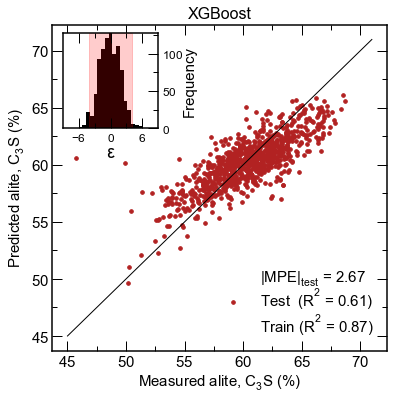

In [1499]:

# ......................XGBoost
model = XGBRegressor(

random_state = 5, subsample=0.99, reg_lambda=5,
reg_alpha=2, n_estimators=250,
min_child_weight=0, max_depth=7,
learning_rate=0.05, colsample_bytree=1, n_jobs=-1

).fit(X_train,y_train)
parity(model, X,y,  'XGBoost')

# From PP and FRM

In [1508]:
now_x = now_2.iloc[:, list(range(43)) + list(range(59, 62))]
now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

X = final_alite.iloc[:,:-1]
y = final_alite.iloc[:,-1:]

# X = final_belite.iloc[:,:-1]
# y = final_belite.iloc[:,-1:]

# X = final_ferrite.iloc[:,:-1]
# y = final_ferrite.iloc[:,-1:]

X
y

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.10,random_state=100)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
y_train_s  = scaler.fit_transform(y_train)
y_test_s  = scaler.transform(y_test)



original length = 14778
length filtered = 9469
original length = 14778
length filtered = 9467
original length = 14778
length filtered = 9467


9451

9411

9435

Exit temperature from each preheater cyclone (Stage 1A)  \
0                                                405.57         
1                                                404.58         
2                                                406.09         
3                                                406.30         
4                                                403.12         
...                                                 ...         
9464                                             385.74         
9465                                             386.02         
9466                                             386.09         
9467                                             386.49         
9468                                             383.68         

      Exit temperature from each preheater cyclone (Stage 1B)  \
0                                                348.84         
1                                                347.22         
2                                                348.99         
3                                                348.99         
4                                                346.61         
...                                                 ...         
9464                                             337.85         
9465                                             337.96         
9466                                             338.02         
9467                                             338.54         
9468                                             336.08         

      Exit temperature from each preheater cyclone (Stage 2)  \
0                                                567.74        
1                                                565.60        
2                                                567.60        
3                                                569.39        
4                                                566.27        
...                                                 ...        
9464                                             530.31        
9465                                             531.07        
9466                                             532.79        
9467                                             536.04        
9468                                             527.11        

      Exit temperature from each preheater cyclone (Stage 3)  \
0                                                722.57        
1                                                720.66        
2                                                722.96        
3                                                724.35        
4                                                720.27        
...                                                 ...        
9464                                             695.18        
9465                                             695.05        
9466                                             696.74        
9467                                             695.53        
9468                                             690.02        

      Exit temperature from each preheater cyclone (Stage 4)  \
0                                                819.44        
1                                                814.53        
2                                                818.62        
3                                                819.44        
4                                                814.81        
...                                                 ...        
9464                                             726.47        
9465                                             721.16        
9466                                             734.38        
9467                                             726.08        
9468                                             726.32        

      Exit temperature from each preheater cyclone (Stage 5)  \
0                                                811.86        
1        

alite
0     59.64
1     61.45
2     60.96
3     59.07
4     60.56
...     ...
9464  64.89
9465  63.66
9466  63.34
9467  64.24
9468  61.88

[9451 rows x 1 columns]

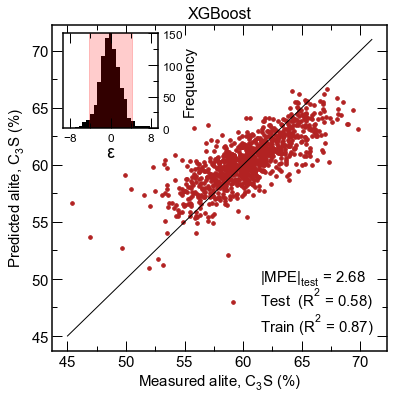

In [1512]:
model = XGBRegressor(

random_state = 5, subsample=0.99, reg_lambda=5,
reg_alpha=1, n_estimators=280,
min_child_weight=2, max_depth=7,
learning_rate=0.05, colsample_bytree=1, n_jobs=-1

).fit(X_train,y_train)
parity(model, X,y,  'XGBoost')

# pp, frm and hrm


In [274]:
all = pd.merge(new, now_1, on = 'encoding')  # now_1= clk, frm & hrm

In [ ]:
all.to_excel('now_2.xlsx', index = False)

In [32]:
now_now_2 = pd.read_excel('now_2.xlsx')

In [ ]:
now_x = now_2.iloc[:,list(range(0,50)) + list(range(59,62))]

now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

X = final_alite.iloc[:,:-1]
y = final_alite.iloc[:,-1:]

# X = final_belite.iloc[:,:-1]
# y = final_belite.iloc[:,-1:]

# X = final_ferrite.iloc[:,:-1]
# y = final_ferrite.iloc[:,-1:]

X
y

now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.10,random_state=100)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
y_train_s  = scaler.fit_transform(y_train)
y_test_s  = scaler.transform(y_test)


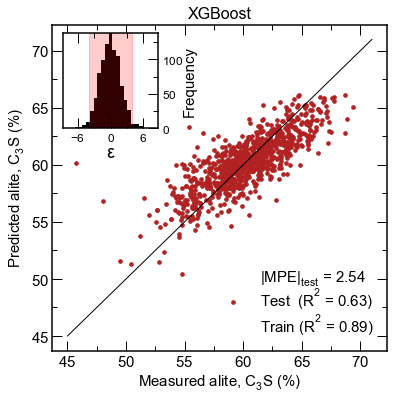

In [1523]:

# ......................XGBoost
model = XGBRegressor(

random_state = 5, subsample=0.99, reg_lambda=5,
reg_alpha=1, n_estimators=250,
min_child_weight=5, max_depth=7,
learning_rate=0.05, colsample_bytree=1, n_jobs=-1

).fit(X_train,y_train)
parity(model, X,y,  'XGBoost')

# From oxies only


In [568]:
now_2 = pd.read_excel('now_2.xlsx')
now_x = now_2.iloc[:,-12:] 
now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)
final = final_alite[(final_alite['na2o'] <= 0.3) & (final_alite['cl'] <= 0.1)]
X = final.iloc[:,:-1]
y = final.iloc[:,-1:]

# X = final_belite.iloc[:,:-1]
# y = final_belite.iloc[:,-1:]

# X = final_ferrite.iloc[:,:-1]
# y = final_ferrite.iloc[:,-1:]
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.10,random_state=100)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
y_train_s  = scaler.fit_transform(y_train)
y_test_s  = scaler.transform(y_test)

original length = 14778
length filtered = 13833
original length = 14778
length filtered = 13831
original length = 14778
length filtered = 13834


13810

13736

13792

In [44]:
now_2 = pd.read_excel('now_2.xlsx')
now_x = now_2.iloc[:,-12:] 

filtered_alite = filter_df(now_x)
# filtered_belite = filter_df(now_belite)
# filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

# final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
# len(final_belite)

# final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)
final = final_alite[(final_alite['na2o'] <= 0.3) & (final_alite['cl'] <= 0.1)]
X = final.iloc[:,:-1]
y = final.iloc[:,-1:]

# X = final_belite.iloc[:,:-1]
# y = final_belite.iloc[:,-1:]

# X = final_ferrite.iloc[:,:-1]
# y = final_ferrite.iloc[:,-1:]
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.10,random_state=100)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
y_train_s  = scaler.fit_transform(y_train)
y_test_s  = scaler.transform(y_test)

original length = 14778
length filtered = 13828


13810

13792

# XGBoost for oxide only input model

In [586]:
# ......................XGBoost
model = XGBRegressor(

random_state = 5, subsample=0.9, reg_lambda=8,
reg_alpha=1, n_estimators=340,
min_child_weight=0, max_depth=8,
learning_rate=0.05, colsample_bytree=1, n_jobs=-1

).fit(X_train,y_train)
# parity(model, X,y,  'XGBoost')
get_score('Training',actual=y_train,predicted=model.predict(X_train))
get_score('Test',actual=y_test,predicted=model.predict(X_test))
MPE(y_test[y_test.columns[0]].to_list(),list(model.predict(X_test)))

Training 0.89 0.787 1.157


0.89

Test 0.77 1.177 2.479


0.77

1.98

# From PP and clinker oxides


In [1532]:
now_x = now_2.iloc[:,list(range(0,34))+list(range(50,59))+list(range(59,62))]
now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

X = final_alite.iloc[:,:-1]
y = final_alite.iloc[:,-1:]

# X = final_belite.iloc[:,:-1]
# y = final_belite.iloc[:,-1:]

# X = final_ferrite.iloc[:,:-1]
# y = final_ferrite.iloc[:,-1:]

X
y

now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.10,random_state=100)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
y_train_s  = scaler.fit_transform(y_train)
y_test_s  = scaler.transform(y_test)


original length = 14778
length filtered = 9248
original length = 14778
length filtered = 9247
original length = 14778
length filtered = 9247


9234

9191

9217

Exit temperature from each preheater cyclone (Stage 1A)  \
0                                                405.57         
1                                                404.58         
2                                                406.09         
3                                                406.30         
4                                                406.08         
...                                                 ...         
9243                                             385.74         
9244                                             386.02         
9245                                             386.09         
9246                                             386.49         
9247                                             383.68         

      Exit temperature from each preheater cyclone (Stage 1B)  \
0                                                348.84         
1                                                347.22         
2                                                348.99         
3                                                348.99         
4                                                348.84         
...                                                 ...         
9243                                             337.85         
9244                                             337.96         
9245                                             338.02         
9246                                             338.54         
9247                                             336.08         

      Exit temperature from each preheater cyclone (Stage 2)  \
0                                                567.74        
1                                                565.60        
2                                                567.60        
3                                                569.39        
4                                                569.46        
...                                                 ...        
9243                                             530.31        
9244                                             531.07        
9245                                             532.79        
9246                                             536.04        
9247                                             527.11        

      Exit temperature from each preheater cyclone (Stage 3)  \
0                                                722.57        
1                                                720.66        
2                                                722.96        
3                                                724.35        
4                                                724.39        
...                                                 ...        
9243                                             695.18        
9244                                             695.05        
9245                                             696.74        
9246                                             695.53        
9247                                             690.02        

      Exit temperature from each preheater cyclone (Stage 4)  \
0                                                819.44        
1                                                814.53        
2                                                818.62        
3                                                819.44        
4                                                817.42        
...                                                 ...        
9243                                             726.47        
9244                                             721.16        
9245                                             734.38        
9246                                             726.08        
9247                                             726.32        

      Exit temperature from each preheater cyclone (Stage 5)  \
0                                                811.86        
1        

alite
0     59.64
1     61.45
2     60.96
3     59.07
4     59.27
...     ...
9243  64.89
9244  63.66
9245  63.34
9246  64.24
9247  61.88

[9234 rows x 1 columns]

original length = 14778
length filtered = 9248
original length = 14778
length filtered = 9247
original length = 14778
length filtered = 9247


9234

9191

9217

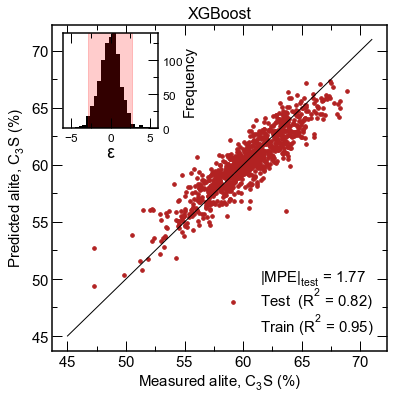

In [1535]:
# ......................XGBoost
model = XGBRegressor(

random_state = 5, subsample=0.99, reg_lambda=7,
reg_alpha=1, n_estimators=300,
min_child_weight=5, max_depth=8,
learning_rate=0.05, colsample_bytree=1, n_jobs=-1

).fit(X_train,y_train)
parity(model, X,y,  'XGBoost')

# FRM and clinker oxide

In [1551]:
now_x= now_1.iloc[:,list(range(0,21))]
now_x = now_x[['cao', 'sio2', 'al2o3', 'fe2o3', 'mgo', 'so3', 'k2o', 'na2o', 'cl',
    'cao1', 'sio21', 'al2o31', 'fe2o31',
       'mgo1', 'so31', 'k2o1', 'na2o1', 'cl1','alite', 'belite', 'ferrite',]]

In [1552]:
now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

X = final_alite.iloc[:,:-1]
y = final_alite.iloc[:,-1:]

# X = final_belite.iloc[:,:-1]
# y = final_belite.iloc[:,-1:]

# X = final_ferrite.iloc[:,:-1]
# y = final_ferrite.iloc[:,-1:]

X
y

now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.10,random_state=100)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
y_train_s  = scaler.fit_transform(y_train)
y_test_s  = scaler.transform(y_test)




original length = 14964
length filtered = 13965
original length = 14964
length filtered = 13963
original length = 14964
length filtered = 13966


13941

13869

13924

cao   sio2  al2o3  fe2o3   mgo   so3   k2o  na2o    cl   cao1  sio21  \
0      64.46  20.77   5.46   3.43  3.92  1.34  0.55  0.08  0.00  41.43  13.03   
1      64.29  20.78   5.43   3.46  3.90  1.41  0.62  0.09  0.00  41.38  13.24   
2      64.46  20.71   5.48   3.42  3.90  1.37  0.59  0.08  0.00  41.49  12.93   
3      64.23  20.81   5.50   3.41  3.90  1.40  0.63  0.09  0.00  41.37  13.15   
4      64.27  20.88   5.49   3.44  3.95  1.34  0.57  0.08  0.00  41.80  13.60   
...      ...    ...    ...    ...   ...   ...   ...   ...   ...    ...    ...   
13960  64.96  21.07   4.93   3.47  2.97  0.73  0.70  0.15  0.01  42.09  13.01   
13961  65.29  21.03   4.92   3.45  2.99  0.61  0.63  0.13  0.01  42.32  13.14   
13962  65.46  21.03   4.88   3.45  2.97  0.58  0.56  0.13  0.01  42.31  13.31   
13963  65.43  21.10   4.98   3.44  3.02  0.62  0.63  0.14  0.01  42.38  13.04   
13964  65.20  20.96   4.89   3.43  3.02  0.66  0.68  0.14  0.02  42.39  13.07   

       al2o31  fe2o31  mgo1  so31  k2o1  na2o1   cl1  
0        3.08    2.07  2.63  0.12  0.40   0.10  0.02  
1        3.11    2.09  2.64  0.14  0.40   0.10  0.02  
2        3.11    2.07  2.59  0.12  0.40   0.10  0.02  
3        3.10    2.08  2.62  0.14  0.40   0.10  0.02  
4        2.67    2.09  2.65  0.12  0.35   0.10  0.01  
...       ...     ...   ...   ...   ...    ...   ...  
13960    3.04    2.10  1.83  0.09  0.46   0.06  0.02  
13961    3.05    2.12  1.83  0.09  0.46   0.06  0.02  
13962    3.04    2.09  1.82  0.10  0.45   0.06  0.02  
13963    3.06    2.08  1.85  0.09  0.46   0.07  0.02  
13964    3.04    2.11  1.85  0.10  0.46   0.06  0.02  

[13941 rows x 18 columns]

alite
0      59.35
1      59.85
2      60.23
3      59.72
4      57.52
...      ...
13960  63.66
13961  63.34
13962  64.24
13963  64.31
13964  61.88

[13941 rows x 1 columns]

original length = 14964
length filtered = 13965
original length = 14964
length filtered = 13963
original length = 14964
length filtered = 13966


13941

13869

13924

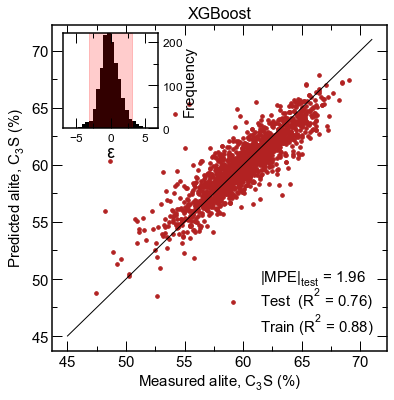

In [1554]:
# ......................XGBoost
model = XGBRegressor(

random_state = 5, subsample=0.99, reg_lambda=5,
reg_alpha=1, n_estimators=280,
min_child_weight=5, max_depth=7,
learning_rate=0.05, colsample_bytree=1, n_jobs=-1

).fit(X_train,y_train)
parity(model, X,y,  'XGBoost')

# HRM and clinker oxide

In [1555]:
now_x = now_1.iloc[:,list(range(0,12)) + list(range(21,28))]
now_x = now_x[['cao', 'sio2', 'al2o3', 'fe2o3', 'mgo', 'so3', 'k2o', 'na2o', 'cl',
        'so32', 'k2o2', 'na2o2', 'cl2', 'alite2',
       'belite2', 'ferrite2','alite', 'belite', 'ferrite',]]

now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

X = final_alite.iloc[:,:-1]
y = final_alite.iloc[:,-1:]

# X = final_belite.iloc[:,:-1]
# y = final_belite.iloc[:,-1:]

# X = final_ferrite.iloc[:,:-1]
# y = final_ferrite.iloc[:,-1:]

X
y

now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.10,random_state=100)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
y_train_s  = scaler.fit_transform(y_train)
y_test_s  = scaler.transform(y_test)




original length = 14964
length filtered = 13333
original length = 14964
length filtered = 13333
original length = 14964
length filtered = 13336


13314

13240

13296

cao   sio2  al2o3  fe2o3   mgo   so3   k2o  na2o    cl  so32  k2o2  \
0      64.46  20.77   5.46   3.43  3.92  1.34  0.55  0.08  0.00  0.93  1.35   
1      64.29  20.78   5.43   3.46  3.90  1.41  0.62  0.09  0.00  0.93  1.35   
2      64.46  20.71   5.48   3.42  3.90  1.37  0.59  0.08  0.00  0.92  1.37   
3      64.23  20.81   5.50   3.41  3.90  1.40  0.63  0.09  0.00  0.92  1.37   
4      64.27  20.88   5.49   3.44  3.95  1.34  0.57  0.08  0.00  0.96  1.39   
...      ...    ...    ...    ...   ...   ...   ...   ...   ...   ...   ...   
13328  64.96  21.07   4.93   3.47  2.97  0.73  0.70  0.15  0.01  0.85  1.75   
13329  65.29  21.03   4.92   3.45  2.99  0.61  0.63  0.13  0.01  0.85  1.75   
13330  65.46  21.03   4.88   3.45  2.97  0.58  0.56  0.13  0.01  0.90  1.73   
13331  65.43  21.10   4.98   3.44  3.02  0.62  0.63  0.14  0.01  0.90  1.73   
13332  65.20  20.96   4.89   3.43  3.02  0.66  0.68  0.14  0.02  0.83  1.83   

       na2o2   cl2  alite2  belite2  ferrite2  
0       0.24  0.44    2.75     2.69      1.75  
1       0.24  0.44    2.75     2.69      1.75  
2       0.24  0.44    1.97     3.51      1.71  
3       0.24  0.44    1.97     3.51      1.71  
4       0.24  0.47    2.91     1.84      1.70  
...      ...   ...     ...      ...       ...  
13328   0.18  0.91    2.21     3.86      1.55  
13329   0.18  0.91    2.21     3.86      1.55  
13330   0.18  0.82    1.90     3.42      1.16  
13331   0.18  0.82    1.90     3.42      1.16  
13332   0.19  0.95    2.15     3.23      1.71  

[13314 rows x 16 columns]

alite
0      59.35
1      59.85
2      60.23
3      59.72
4      57.52
...      ...
13328  63.66
13329  63.34
13330  64.24
13331  64.31
13332  61.88

[13314 rows x 1 columns]

original length = 14964
length filtered = 13333
original length = 14964
length filtered = 13333
original length = 14964
length filtered = 13336


13314

13240

13296

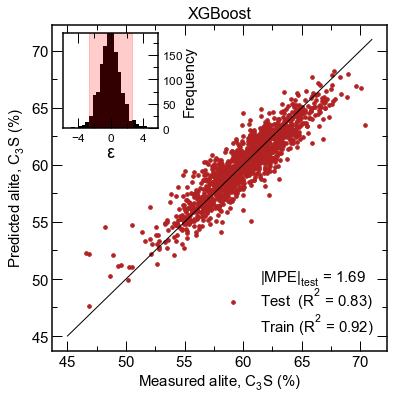

In [1558]:
# ......................XGBoost
model = XGBRegressor(

random_state = 5, subsample=0.99, reg_lambda=5,
reg_alpha=1, n_estimators=280,
min_child_weight=5, max_depth=8,
learning_rate=0.05, colsample_bytree=1, n_jobs=-1

).fit(X_train,y_train)
parity(model, X,y,  'XGBoost')

# From FRM, HRM & clinkr oxides

In [ ]:
now_x = now_1.copy(deep = True)
now_x = now_x[['cao', 'sio2', 'al2o3', 'fe2o3', 'mgo', 'so3', 'k2o', 'na2o', 'cl',
        'cao1', 'sio21', 'al2o31', 'fe2o31',
       'mgo1', 'so31', 'k2o1', 'na2o1', 'cl1', 'so32', 'k2o2', 'na2o2', 'cl2',
       'alite2', 'belite2', 'ferrite2','alite', 'belite', 'ferrite',]]

now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

X = final_alite.iloc[:,:-1]
y = final_alite.iloc[:,-1:]

# X = final_belite.iloc[:,:-1]
# y = final_belite.iloc[:,-1:]

# X = final_ferrite.iloc[:,:-1]
# y = final_ferrite.iloc[:,-1:]

X
y

now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.10,random_state=100)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
y_train_s  = scaler.fit_transform(y_train)
y_test_s  = scaler.transform(y_test)


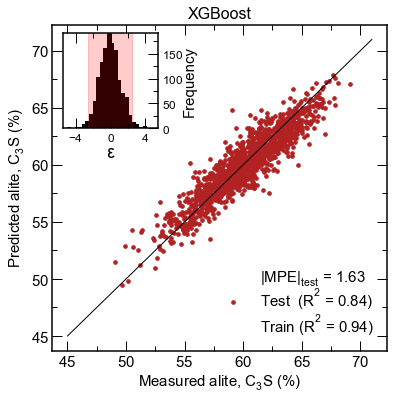

In [1563]:

# ......................XGBoost
model = XGBRegressor(

random_state = 5, subsample=0.99, reg_lambda=5,
reg_alpha=1, n_estimators=300,
min_child_weight=5, max_depth=8,
learning_rate=0.05, colsample_bytree=1, n_jobs=-1

).fit(X_train,y_train)
parity(model, X,y,  'XGBoost')

# PP, HRM , clk

In [1564]:
now_x = now_2.iloc[:,list(range(0,34)) + list(range(43,62))]
now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

X = final_alite.iloc[:,:-1]
y = final_alite.iloc[:,-1:]

# X = final_belite.iloc[:,:-1]
# y = final_belite.iloc[:,-1:]

# X = final_ferrite.iloc[:,:-1]
# y = final_ferrite.iloc[:,-1:]

X
y

now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.10,random_state=100)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
y_train_s  = scaler.fit_transform(y_train)
y_test_s  = scaler.transform(y_test)


original length = 14778
length filtered = 8756
original length = 14778
length filtered = 8756
original length = 14778
length filtered = 8757


8745

8701

8730

Exit temperature from each preheater cyclone (Stage 1A)  \
0                                                405.57         
1                                                404.58         
2                                                406.09         
3                                                406.30         
4                                                406.08         
...                                                 ...         
8751                                             385.74         
8752                                             386.02         
8753                                             386.09         
8754                                             386.49         
8755                                             383.68         

      Exit temperature from each preheater cyclone (Stage 1B)  \
0                                                348.84         
1                                                347.22         
2                                                348.99         
3                                                348.99         
4                                                348.84         
...                                                 ...         
8751                                             337.85         
8752                                             337.96         
8753                                             338.02         
8754                                             338.54         
8755                                             336.08         

      Exit temperature from each preheater cyclone (Stage 2)  \
0                                                567.74        
1                                                565.60        
2                                                567.60        
3                                                569.39        
4                                                569.46        
...                                                 ...        
8751                                             530.31        
8752                                             531.07        
8753                                             532.79        
8754                                             536.04        
8755                                             527.11        

      Exit temperature from each preheater cyclone (Stage 3)  \
0                                                722.57        
1                                                720.66        
2                                                722.96        
3                                                724.35        
4                                                724.39        
...                                                 ...        
8751                                             695.18        
8752                                             695.05        
8753                                             696.74        
8754                                             695.53        
8755                                             690.02        

      Exit temperature from each preheater cyclone (Stage 4)  \
0                                                819.44        
1                                                814.53        
2                                                818.62        
3                                                819.44        
4                                                817.42        
...                                                 ...        
8751                                             726.47        
8752                                             721.16        
8753                                             734.38        
8754                                             726.08        
8755                                             726.32        

      Exit temperature from each preheater cyclone (Stage 5)  \
0                                                811.86        
1        

alite
0     59.64
1     61.45
2     60.96
3     59.07
4     59.27
...     ...
8751  64.89
8752  63.66
8753  63.34
8754  64.24
8755  61.88

[8745 rows x 1 columns]

original length = 14778
length filtered = 8756
original length = 14778
length filtered = 8756
original length = 14778
length filtered = 8757


8745

8701

8730

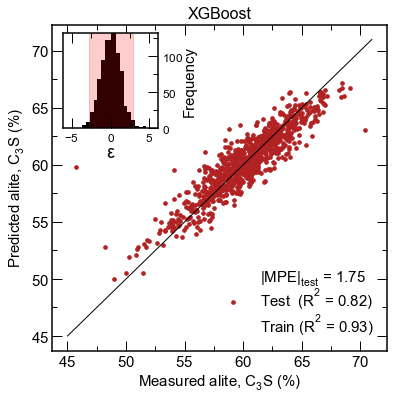

In [1574]:

# ......................XGBoost
model = XGBRegressor(

random_state = 5, subsample=0.99, reg_lambda=7,
reg_alpha=1, n_estimators=220,
min_child_weight=5, max_depth=7,
learning_rate=0.05, colsample_bytree=1, n_jobs=-1

).fit(X_train,y_train)
parity(model, X,y,  'XGBoost')

# PP ,FRM , Oxides

In [1575]:
now_x = now_2.iloc[:,list(range(0,43))+ list(range(50, 62))]
now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
len(final_ferrite)

X = final_alite.iloc[:,:-1]
y = final_alite.iloc[:,-1:]

# X = final_belite.iloc[:,:-1]
# y = final_belite.iloc[:,-1:]

# X = final_ferrite.iloc[:,:-1]
# y = final_ferrite.iloc[:,-1:]

X
y

now_alite = now_x.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_x.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_x.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
# len(final_alite)

final_belite =filtered_belite[ ((filtered_belite ['belite']< 25) & (filtered_belite['belite']> 5 ))]
# len(final_belite)

final_ferrite = filtered_ferrite[((filtered_ferrite['ferrite']< 17) & (filtered_ferrite['ferrite']> 8.41 ))]
# len(final_ferrite)

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.10,random_state=100)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
y_train_s  = scaler.fit_transform(y_train)
y_test_s  = scaler.transform(y_test)


original length = 14778
length filtered = 9163
original length = 14778
length filtered = 9162
original length = 14778
length filtered = 9162


9150

9108

9134

Exit temperature from each preheater cyclone (Stage 1A)  \
0                                                405.57         
1                                                404.58         
2                                                406.09         
3                                                406.30         
4                                                406.08         
...                                                 ...         
9158                                             385.74         
9159                                             386.02         
9160                                             386.09         
9161                                             386.49         
9162                                             383.68         

      Exit temperature from each preheater cyclone (Stage 1B)  \
0                                                348.84         
1                                                347.22         
2                                                348.99         
3                                                348.99         
4                                                348.84         
...                                                 ...         
9158                                             337.85         
9159                                             337.96         
9160                                             338.02         
9161                                             338.54         
9162                                             336.08         

      Exit temperature from each preheater cyclone (Stage 2)  \
0                                                567.74        
1                                                565.60        
2                                                567.60        
3                                                569.39        
4                                                569.46        
...                                                 ...        
9158                                             530.31        
9159                                             531.07        
9160                                             532.79        
9161                                             536.04        
9162                                             527.11        

      Exit temperature from each preheater cyclone (Stage 3)  \
0                                                722.57        
1                                                720.66        
2                                                722.96        
3                                                724.35        
4                                                724.39        
...                                                 ...        
9158                                             695.18        
9159                                             695.05        
9160                                             696.74        
9161                                             695.53        
9162                                             690.02        

      Exit temperature from each preheater cyclone (Stage 4)  \
0                                                819.44        
1                                                814.53        
2                                                818.62        
3                                                819.44        
4                                                817.42        
...                                                 ...        
9158                                             726.47        
9159                                             721.16        
9160                                             734.38        
9161                                             726.08        
9162                                             726.32        

      Exit temperature from each preheater cyclone (Stage 5)  \
0                                                811.86        
1        

alite
0     59.64
1     61.45
2     60.96
3     59.07
4     59.27
...     ...
9158  64.89
9159  63.66
9160  63.34
9161  64.24
9162  61.88

[9150 rows x 1 columns]

original length = 14778
length filtered = 9163
original length = 14778
length filtered = 9162
original length = 14778
length filtered = 9162


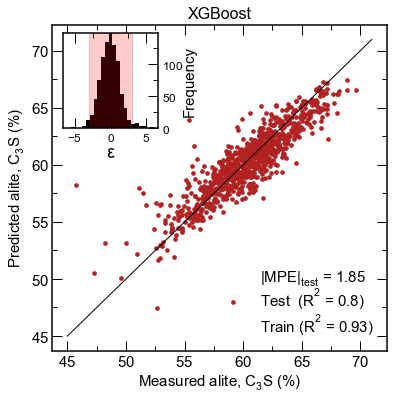

In [1578]:

# ......................XGBoost
model = XGBRegressor(

random_state = 5, subsample=0.99, reg_lambda=5,
reg_alpha=1, n_estimators=250,
min_child_weight=5, max_depth=7,
learning_rate=0.05, colsample_bytree=1, n_jobs=-1

).fit(X_train,y_train)
parity(model, X,y,  'XGBoost')

# Other models

In [1383]:
titles = ['Linear regression', 'Laso', 'Ridge', 'Elastic net', 'Random forest', 'SVR', 'GPR']

In [1384]:
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.10,random_state=100)
scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
y_train_s  = scaler.fit_transform(y_train)
y_test_s  = scaler.transform(y_test)

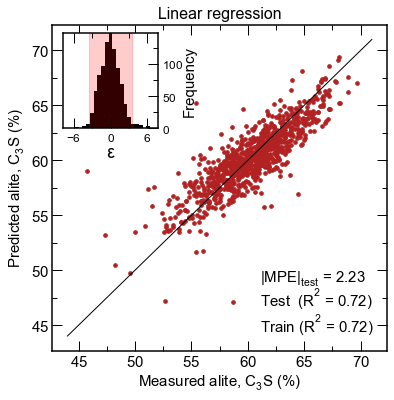

In [1385]:
model=LinearRegression().fit(X_train,y_train)
parity(model, X,y, titles[0])

Lasso(alpha=1e-05)

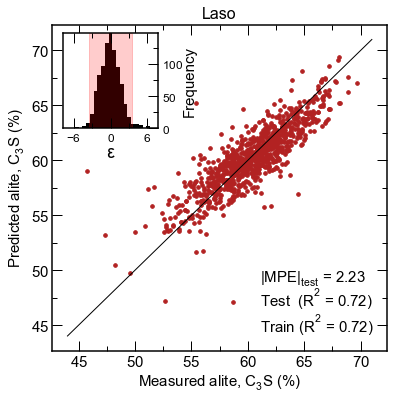

In [1386]:
model=Lasso(alpha=0.00001)
model.fit(X_train,y_train)
parity(model, X,y, titles[1])


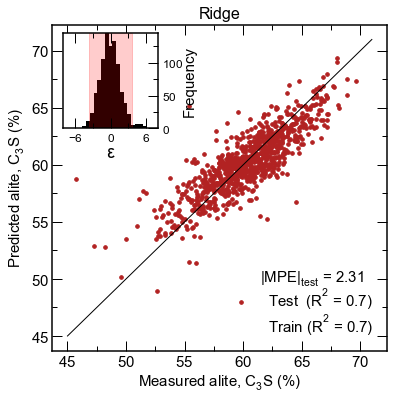

In [1387]:
model = Ridge(alpha=0.0001)
model=Ridge().fit(X_train,y_train)
parity(model, X,y, titles[2])


ElasticNet(alpha=0.0001)

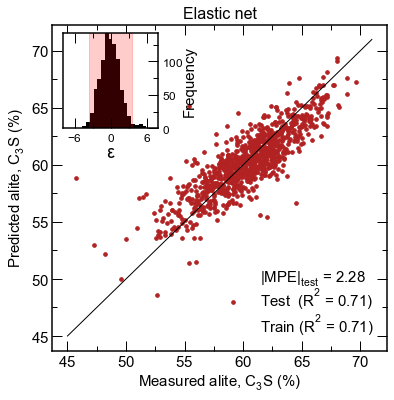

In [1388]:
model=ElasticNet(alpha=0.0001)
model.fit(X_train,y_train)
parity(model, X,y, titles[3])

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.89

0.71

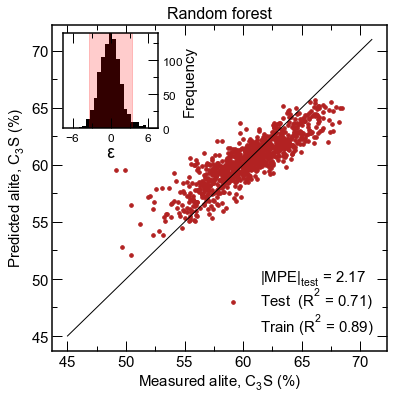

In [1389]:
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.10,random_state=100020) # earlier 100
Rfreg=RandomForestRegressor(n_estimators=100,random_state=5, max_depth =12 ,n_jobs =-1 ,ccp_alpha=0,max_features = 'sqrt', bootstrap=True)
model=Rfreg.fit(X_train,y_train)
get_score('Training',actual=y_train,predicted=model.predict(X_train))
get_score('Test',actual=y_test,predicted=model.predict(X_test))
parity(model, X,y, titles[4])

## SVR

SVR(gamma='auto')

0.88

0.79

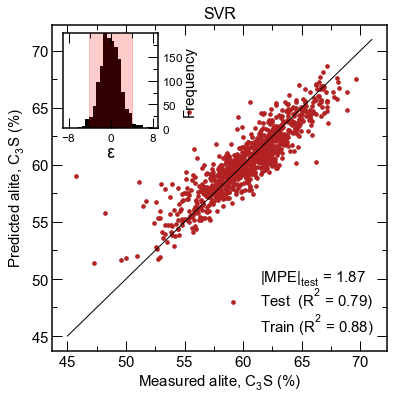

In [1396]:
model = SVR(kernel = 'rbf', gamma = 'auto')
model.fit(X_train_s, y_train_s.ravel()) #used ravel() because SVR takes a 1D array as input and not a vector
                                                #so flattened the (m,1) vector to (m,)
test_pred_s =model.predict(X_test_s).reshape(-1,1)
train_pred_s =model.predict(X_train_s).reshape(-1,1)

r2_train = get_score('Training',actual=y_train,predicted=scaler.inverse_transform(train_pred_s))
r2_test= get_score('Test',actual=y_test,predicted=scaler.inverse_transform(test_pred_s))
r2_train 
r2_test


train_actual = y_train[y_train.columns[0]].to_list()
test_actual = y_test[y_test.columns[0]].to_list()
test_prediction = array_to_list(scaler.inverse_transform(test_pred_s))
train_pred =      array_to_list(scaler.inverse_transform(train_pred_s))
parity_custom(train_actual, train_pred ,test_actual , test_prediction , titles[5])

In [ ]:
regressor = SVR()
hyperparameter_grid_svr = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    }
# run randomized search
n_iter_search_svr = 8
random_search = RandomizedSearchCV(estimator=regressor, param_distributions=hyperparameter_grid_svr,
                                   n_iter=n_iter_search_svr, cv=4, scoring='neg_mean_absolute_error')

start = time.time()
random_search.fit(X_train_s, y_train_s.ravel())
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search_svr))

best_regressor_svr = random_search.best_estimator_
print(best_regressor_svr)
print('best parameters:' , random_search.best_params_)

SVR(gamma='auto')
best parameters: {'kernel': 'rbf', 'gamma': 'auto'}


# XGBoost

In [ ]:
titles = ['Alite ($C_3$S)',  'Belite (C$_2$S)',  'Ferrite (C$_4$AF)'  ]

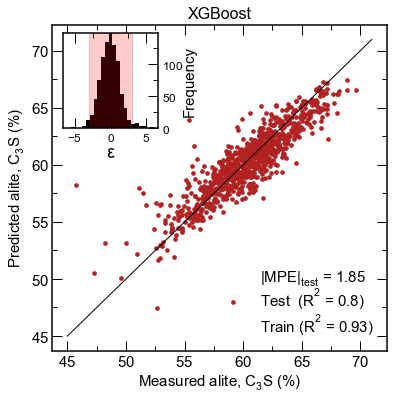

In [1407]:
model = XGBRegressor(

random_state = 5, subsample=0.99, reg_lambda=5,
reg_alpha=1, n_estimators=250,
min_child_weight=5, max_depth=7,
learning_rate=0.05, colsample_bytree=1, n_jobs=-1

).fit(X_train,y_train)
parity(model, X,y,  'XGBoost')

# PP, frm, hrm, oxides (All inputs)

### Reading data

In [35]:
now_2 = pd.read_excel('now_2.xlsx')
now_alite = now_2.drop(columns =  ['belite', 'ferrite'],inplace = False)
now_belite = now_2.drop(columns =  ['alite', 'ferrite'],inplace = False)
now_ferrite = now_2.drop(columns = ['alite', 'belite'],inplace = False)

filtered_alite = filter_df(now_alite)
filtered_belite = filter_df(now_belite)
filtered_ferrite = filter_df(now_ferrite)

final_alite = filtered_alite[((filtered_alite['alite']< 71) & (filtered_alite['alite']> 45 ))] # original
print(f'before outlier {len(final_alite)}')

final = final_alite[(final_alite['na2o'] <= 0.3) & (final_alite['cl'] <= 0.1) & (final_alite['cl1'] <= 0.075 )&( final_alite['cao1'] >=41 )& (final_alite['so32'] < 2) & (final_alite['k2o2'] < 3) & (final_alite['cl2'] < 2) & (final_alite['alite2'] < 20) & (final_alite['belite2'] < 7.5) & (final_alite['ferrite2'] < 7)]
print(f'outlier removed {len(final)}')

X = final.iloc[:,:-1]
y = final.iloc[:,-1:]
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.10,random_state=100)
# scaler = StandardScaler()
# X_train_s = scaler.fit_transform(X_train)
# X_test_s = scaler.transform(X_test)
# y_train_s  = scaler.fit_transform(y_train)
# y_test_s  = scaler.transform(y_test)

original length = 14778
length filtered = 8681
original length = 14778
length filtered = 8681
original length = 14778
length filtered = 8682
before outlier 8670
outlier removed 8645


Exit temperature from each preheater cyclone (Stage 1A)  \
1789                                              405.57         
1791                                              404.58         
1792                                              406.09         
1793                                              406.30         
1795                                              406.08         
...                                                  ...         
14772                                             385.74         
14773                                             386.02         
14774                                             386.09         
14775                                             386.49         
14777                                             383.68         

       Exit temperature from each preheater cyclone (Stage 1B)  \
1789                                              348.84         
1791                                              347.22         
1792                                              348.99         
1793                                              348.99         
1795                                              348.84         
...                                                  ...         
14772                                             337.85         
14773                                             337.96         
14774                                             338.02         
14775                                             338.54         
14777                                             336.08         

       Exit temperature from each preheater cyclone (Stage 2)  \
1789                                              567.74        
1791                                              565.60        
1792                                              567.60        
1793                                              569.39        
1795                                              569.46        
...                                                  ...        
14772                                             530.31        
14773                                             531.07        
14774                                             532.79        
14775                                             536.04        
14777                                             527.11        

       Exit temperature from each preheater cyclone (Stage 3)  \
1789                                              722.57        
1791                                              720.66        
1792                                              722.96        
1793                                              724.35        
1795                                              724.39        
...                                                  ...        
14772                                             695.18        
14773                                             695.05        
14774                                             696.74        
14775                                             695.53        
14777                                             690.02        

       Exit temperature from each preheater cyclone (Stage 4)  \
1789                                              819.44        
1791                                              814.53        
1792                                              818.62        
1793                                              819.44        
1795                                              817.42        
...                                                  ...        
14772                                             726.47        
14773                                             721.16        
14774                                             734.38        
14775                                             726.08        
14777                                             726.32        

       Exit temperature from each preheater cyclone (Stage 5)  \
1789         

alite
1789   59.64
1791   61.45
1792   60.96
1793   59.07
1795   59.27
...      ...
14772  64.89
14773  63.66
14774  63.34
14775  64.24
14777  61.88

[8645 rows x 1 columns]

In [255]:
phase = 'alite'

### Evaluating different ML architectures

# LR

In [226]:
regressor = LinearRegression()
hyperparameter_grid= {} 


# run randomized search
n_iter_search = 140
random_search = RandomizedSearchCV(estimator=regressor, param_distributions=hyperparameter_grid,
                                   n_iter=n_iter_search , cv=4, scoring ='neg_mean_absolute_percentage_error' , verbose = 3)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search_svr))

best_regressor = random_search.best_estimator_
print(best_regressor )
print('best parameters:' , random_search.best_params_)

The total space of parameters 1 is smaller than n_iter=140. Running 1 iterations. For exhaustive searches, use GridSearchCV.


Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END .................................., score=-0.020 total time=   0.1s
[CV 2/4] END .................................., score=-0.019 total time=   0.0s
[CV 3/4] END .................................., score=-0.019 total time=   0.0s
[CV 4/4] END .................................., score=-0.020 total time=   0.0s


RandomizedSearchCV(cv=4, estimator=LinearRegression(), n_iter=140,
                   param_distributions={},
                   scoring='neg_mean_absolute_percentage_error', verbose=3)

RandomizedSearchCV took 0.27 seconds for 140 candidates parameter settings.
LinearRegression()
best parameters: {}


In [228]:
best_model = random_search.best_estimator_
with open(f'./saved_models/{phase}/all_inputs/model_{titles[0]}.pkl', 'wb') as f:   # save best model
    pickle.dump(best_model,f)
from sklearn.model_selection import KFold

kf = KFold(n_splits=4)
train_fold_results = []
val_fold_results = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    best_model.fit(X_train_fold, y_train_fold)
    y_val_pred = best_model.predict(X_val_fold)
    y_train_pred = best_model.predict(X_train_fold)

    train_fold_r2 = r2_score(y_train_fold, y_train_pred)
    train_fold_mae = mean_absolute_error(y_train_fold, y_train_pred)
    train_fold_mape = np.round((mean_absolute_percentage_error(y_train_fold,y_train_pred ))*100,2)

    val_fold_r2 = r2_score(y_val_fold, y_val_pred)
    val_fold_mae = mean_absolute_error(y_val_fold, y_val_pred)
    val_fold_mape = np.round((mean_absolute_percentage_error(y_val_fold,y_val_pred ))*100,2)

    train_fold_results.append((train_fold_r2, train_fold_mae, train_fold_mape))
    val_fold_results.append((val_fold_r2, val_fold_mae, val_fold_mape))
avg_train_results = [round(x,2) for x in list(np.mean(np.array(train_fold_results), axis=0))]  # Average values of R2, MAE and MAPE on train folds
avg_val_results =  [round(x,2) for x in list(np.mean(np.array(val_fold_results), axis=0))]    # Average values of R2, MAE and MAPE on val folds
print(f"Avg Training:  R^2 = {avg_train_results[0]}, MAE = {avg_train_results[1]}, MAPE = {avg_train_results[2]}%")
print(f"Avg Val:  R^2 = {avg_val_results[0]}, MAE = {avg_val_results[1]}, MAPE = {avg_val_results[2]}%")

LinearRegression()

LinearRegression()

LinearRegression()

LinearRegression()

Avg Training:  R^2 = 0.79, MAE = 1.16, MAPE = 1.94%
Avg Val:  R^2 = 0.78, MAE = 1.17, MAPE = 1.96%


Test: R^2 = 0.76, MAE = 1.18, MAPE = 1.97%


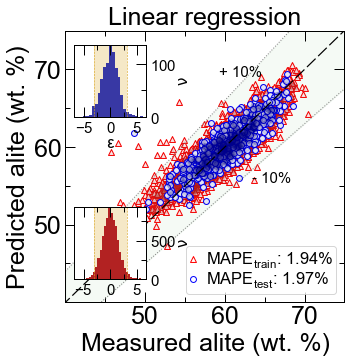

In [299]:
#load best model
avg_train_results = [0.79, 1.16, 1.94]
best_model = pickle.load(open(f'./saved_models/{phase}/all_inputs/model_{titles[0]}.pkl','rb')) 
parity_train_test(best_model, titles[0])

# Lasso

In [235]:
regressor = Lasso()
hyperparameter_grid= {'alpha': [0.00001, 0.0001,0.001, 0.1, 1]} 


# run randomized search
n_iter_search = 140
random_search = RandomizedSearchCV(estimator=regressor, param_distributions=hyperparameter_grid,
                                   n_iter=n_iter_search , cv=4, scoring ='neg_mean_absolute_percentage_error' , verbose = 3)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search_svr))

best_regressor = random_search.best_estimator_
print(best_regressor )
print('best parameters:' , random_search.best_params_)

The total space of parameters 5 is smaller than n_iter=140. Running 5 iterations. For exhaustive searches, use GridSearchCV.


Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV 1/4] END ......................alpha=1e-05;, score=-0.020 total time=   0.4s
[CV 2/4] END ......................alpha=1e-05;, score=-0.019 total time=   0.4s
[CV 3/4] END ......................alpha=1e-05;, score=-0.019 total time=   0.3s
[CV 4/4] END ......................alpha=1e-05;, score=-0.020 total time=   0.3s
[CV 1/4] END .....................alpha=0.0001;, score=-0.020 total time=   0.3s
[CV 2/4] END .....................alpha=0.0001;, score=-0.019 total time=   0.3s
[CV 3/4] END .....................alpha=0.0001;, score=-0.019 total time=   0.2s
[CV 4/4] END .....................alpha=0.0001;, score=-0.020 total time=   0.3s
[CV 1/4] END ......................alpha=0.001;, score=-0.020 total time=   0.3s
[CV 2/4] END ......................alpha=0.001;, score=-0.020 total time=   0.2s
[CV 3/4] END ......................alpha=0.001;, score=-0.020 total time=   0.3s
[CV 4/4] END ......................alpha=0.001;, 

RandomizedSearchCV(cv=4, estimator=Lasso(), n_iter=140,
                   param_distributions={'alpha': [1e-05, 0.0001, 0.001, 0.1,
                                                  1]},
                   scoring='neg_mean_absolute_percentage_error', verbose=3)

RandomizedSearchCV took 4.31 seconds for 140 candidates parameter settings.
Lasso(alpha=1e-05)
best parameters: {'alpha': 1e-05}


In [236]:
best_model = random_search.best_estimator_
from sklearn.model_selection import KFold

with open(f'./saved_models/{phase}/all_inputs/model_{titles[1]}.pkl', 'wb') as f:   # save best model
    pickle.dump(best_model,f)

kf = KFold(n_splits=4)
train_fold_results = []
val_fold_results = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    best_model.fit(X_train_fold, y_train_fold)
    y_val_pred = best_model.predict(X_val_fold)
    y_train_pred = best_model.predict(X_train_fold)

    train_fold_r2 = r2_score(y_train_fold, y_train_pred)
    train_fold_mae = mean_absolute_error(y_train_fold, y_train_pred)
    train_fold_mape = np.round((mean_absolute_percentage_error(y_train_fold,y_train_pred ))*100,2)

    val_fold_r2 = r2_score(y_val_fold, y_val_pred)
    val_fold_mae = mean_absolute_error(y_val_fold, y_val_pred)
    val_fold_mape = np.round((mean_absolute_percentage_error(y_val_fold,y_val_pred ))*100,2)

    train_fold_results.append((train_fold_r2, train_fold_mae, train_fold_mape))
    val_fold_results.append((val_fold_r2, val_fold_mae, val_fold_mape))
avg_train_results = [round(x,2) for x in list(np.mean(np.array(train_fold_results), axis=0))]  # Average values of R2, MAE and MAPE on train folds
avg_val_results =  [round(x,2) for x in list(np.mean(np.array(val_fold_results), axis=0))]    # Average values of R2, MAE and MAPE on val folds
print(f"Avg Training:  R^2 = {avg_train_results[0]}, MAE = {avg_train_results[1]}, MAPE = {avg_train_results[2]}%")
print(f"Avg Val:  R^2 = {avg_val_results[0]}, MAE = {avg_val_results[1]}, MAPE = {avg_val_results[2]}%")

Lasso(alpha=1e-05)

Lasso(alpha=1e-05)

Lasso(alpha=1e-05)

Lasso(alpha=1e-05)

Avg Training:  R^2 = 0.79, MAE = 1.16, MAPE = 1.94%
Avg Val:  R^2 = 0.78, MAE = 1.17, MAPE = 1.96%


Test: R^2 = 0.76, MAE = 1.18, MAPE = 1.97%


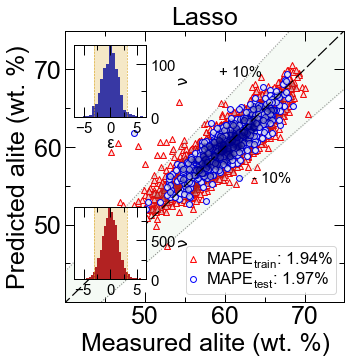

In [300]:
#load best model
avg_train_results = [0.79, 1.16, 1.94]
best_model = pickle.load(open(f'./saved_models/{phase}/all_inputs/model_{titles[1]}.pkl','rb')) 
parity_train_test(best_model, titles[1])

# Ridge

In [238]:
regressor = Ridge()
hyperparameter_grid= {'alpha': [0.00001, 0.0001,0.001, 0.1, 1]} 


# run randomized search
n_iter_search = 140
random_search = RandomizedSearchCV(estimator=regressor, param_distributions=hyperparameter_grid,
                                   n_iter=n_iter_search , cv=4, scoring ='neg_mean_absolute_percentage_error' , verbose = 3)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search_svr))

best_regressor = random_search.best_estimator_
print(best_regressor )
print('best parameters:' , random_search.best_params_)

The total space of parameters 5 is smaller than n_iter=140. Running 5 iterations. For exhaustive searches, use GridSearchCV.


Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV 1/4] END ......................alpha=1e-05;, score=-0.020 total time=   0.1s
[CV 2/4] END ......................alpha=1e-05;, score=-0.019 total time=   0.0s
[CV 3/4] END ......................alpha=1e-05;, score=-0.019 total time=   0.0s
[CV 4/4] END ......................alpha=1e-05;, score=-0.020 total time=   0.0s
[CV 1/4] END .....................alpha=0.0001;, score=-0.020 total time=   0.0s
[CV 2/4] END .....................alpha=0.0001;, score=-0.019 total time=   0.0s
[CV 3/4] END .....................alpha=0.0001;, score=-0.019 total time=   0.0s
[CV 4/4] END .....................alpha=0.0001;, score=-0.020 total time=   0.0s
[CV 1/4] END ......................alpha=0.001;, score=-0.020 total time=   0.0s
[CV 2/4] END ......................alpha=0.001;, score=-0.019 total time=   0.0s
[CV 3/4] END ......................alpha=0.001;, score=-0.019 total time=   0.0s
[CV 4/4] END ......................alpha=0.001;, 

RandomizedSearchCV(cv=4, estimator=Ridge(), n_iter=140,
                   param_distributions={'alpha': [1e-05, 0.0001, 0.001, 0.1,
                                                  1]},
                   scoring='neg_mean_absolute_percentage_error', verbose=3)

RandomizedSearchCV took 0.31 seconds for 140 candidates parameter settings.
Ridge(alpha=0.001)
best parameters: {'alpha': 0.001}


In [239]:
best_model = random_search.best_estimator_
from sklearn.model_selection import KFold
with open(f'./saved_models/{phase}/all_inputs/model_{titles[2]}.pkl', 'wb') as f:   # save best model
    pickle.dump(best_model,f)

kf = KFold(n_splits=4)
train_fold_results = []
val_fold_results = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    best_model.fit(X_train_fold, y_train_fold)
    y_val_pred = best_model.predict(X_val_fold)
    y_train_pred = best_model.predict(X_train_fold)

    train_fold_r2 = r2_score(y_train_fold, y_train_pred)
    train_fold_mae = mean_absolute_error(y_train_fold, y_train_pred)
    train_fold_mape = np.round((mean_absolute_percentage_error(y_train_fold,y_train_pred ))*100,2)

    val_fold_r2 = r2_score(y_val_fold, y_val_pred)
    val_fold_mae = mean_absolute_error(y_val_fold, y_val_pred)
    val_fold_mape = np.round((mean_absolute_percentage_error(y_val_fold,y_val_pred ))*100,2)

    train_fold_results.append((train_fold_r2, train_fold_mae, train_fold_mape))
    val_fold_results.append((val_fold_r2, val_fold_mae, val_fold_mape))
avg_train_results = [round(x,2) for x in list(np.mean(np.array(train_fold_results), axis=0))]  # Average values of R2, MAE and MAPE on train folds
avg_val_results =  [round(x,2) for x in list(np.mean(np.array(val_fold_results), axis=0))]    # Average values of R2, MAE and MAPE on val folds
print(f"Avg Training:  R^2 = {avg_train_results[0]}, MAE = {avg_train_results[1]}, MAPE = {avg_train_results[2]}%")
print(f"Avg Val:  R^2 = {avg_val_results[0]}, MAE = {avg_val_results[1]}, MAPE = {avg_val_results[2]}%")

Ridge(alpha=0.001)

Ridge(alpha=0.001)

Ridge(alpha=0.001)

Ridge(alpha=0.001)

Avg Training:  R^2 = 0.79, MAE = 1.16, MAPE = 1.94%
Avg Val:  R^2 = 0.78, MAE = 1.17, MAPE = 1.96%


Test: R^2 = 0.76, MAE = 1.18, MAPE = 1.97%


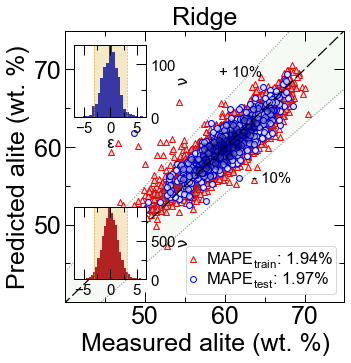

In [301]:
#load best model
avg_train_results = [0.79, 1.16, 1.94]
best_model = pickle.load(open(f'./saved_models/{phase}/all_inputs/model_{titles[2]}.pkl','rb')) 
parity_train_test(best_model, titles[2])

# Elastic Net

In [250]:
regressor = ElasticNet()
hyperparameter_grid= {'alpha': [0.00001, 0.0001,0.001, 0.1, 1]} 


# run randomized search
n_iter_search = 140
random_search = RandomizedSearchCV(estimator=regressor, param_distributions=hyperparameter_grid,
                                   n_iter=n_iter_search , cv=4, scoring ='neg_mean_absolute_percentage_error' , verbose = 3)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search_svr))

best_regressor = random_search.best_estimator_
print(best_regressor )
print('best parameters:' , random_search.best_params_)

The total space of parameters 5 is smaller than n_iter=140. Running 5 iterations. For exhaustive searches, use GridSearchCV.


Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV 1/4] END ......................alpha=1e-05;, score=-0.020 total time=   0.7s


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.082e+01, tolerance: 6.294e+00


[CV 2/4] END ......................alpha=1e-05;, score=-0.020 total time=   0.3s
[CV 3/4] END ......................alpha=1e-05;, score=-0.020 total time=   0.3s


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.561e+01, tolerance: 6.471e+00


[CV 4/4] END ......................alpha=1e-05;, score=-0.019 total time=   0.3s
[CV 1/4] END .....................alpha=0.0001;, score=-0.020 total time=   0.3s
[CV 2/4] END .....................alpha=0.0001;, score=-0.020 total time=   0.3s
[CV 3/4] END .....................alpha=0.0001;, score=-0.020 total time=   0.3s
[CV 4/4] END .....................alpha=0.0001;, score=-0.020 total time=   0.3s
[CV 1/4] END ......................alpha=0.001;, score=-0.022 total time=   0.3s
[CV 2/4] END ......................alpha=0.001;, score=-0.021 total time=   0.3s
[CV 3/4] END ......................alpha=0.001;, score=-0.021 total time=   0.3s
[CV 4/4] END ......................alpha=0.001;, score=-0.021 total time=   0.2s
[CV 1/4] END ........................alpha=0.1;, score=-0.029 total time=   0.1s
[CV 2/4] END ........................alpha=0.1;, score=-0.029 total time=   0.1s
[CV 3/4] END ........................alpha=0.1;, score=-0.029 total time=   0.2s
[CV 4/4] END ...............

RandomizedSearchCV(cv=4, estimator=ElasticNet(), n_iter=140,
                   param_distributions={'alpha': [1e-05, 0.0001, 0.001, 0.1,
                                                  1]},
                   scoring='neg_mean_absolute_percentage_error', verbose=3)

RandomizedSearchCV took 5.40 seconds for 140 candidates parameter settings.
ElasticNet(alpha=1e-05)
best parameters: {'alpha': 1e-05}


In [251]:
best_model = random_search.best_estimator_
with open(f'./saved_models/{phase}/all_inputs/model_{titles[3]}.pkl', 'wb') as f:   # save best model
    pickle.dump(best_model,f)
    
from sklearn.model_selection import KFold

kf = KFold(n_splits=4)
train_fold_results = []
val_fold_results = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    best_model.fit(X_train_fold, y_train_fold)
    y_val_pred = best_model.predict(X_val_fold)
    y_train_pred = best_model.predict(X_train_fold)

    train_fold_r2 = r2_score(y_train_fold, y_train_pred)
    train_fold_mae = mean_absolute_error(y_train_fold, y_train_pred)
    train_fold_mape = np.round((mean_absolute_percentage_error(y_train_fold,y_train_pred ))*100,2)

    val_fold_r2 = r2_score(y_val_fold, y_val_pred)
    val_fold_mae = mean_absolute_error(y_val_fold, y_val_pred)
    val_fold_mape = np.round((mean_absolute_percentage_error(y_val_fold,y_val_pred ))*100,2)

    train_fold_results.append((train_fold_r2, train_fold_mae, train_fold_mape))
    val_fold_results.append((val_fold_r2, val_fold_mae, val_fold_mape))
avg_train_results = [round(x,2) for x in list(np.mean(np.array(train_fold_results), axis=0))]  # Average values of R2, MAE and MAPE on train folds
avg_val_results =  [round(x,2) for x in list(np.mean(np.array(val_fold_results), axis=0))]    # Average values of R2, MAE and MAPE on val folds
print(f"Avg Training:  R^2 = {avg_train_results[0]}, MAE = {avg_train_results[1]}, MAPE = {avg_train_results[2]}%")
print(f"Avg Val:  R^2 = {avg_val_results[0]}, MAE = {avg_val_results[1]}, MAPE = {avg_val_results[2]}%")

ElasticNet(alpha=1e-05)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.082e+01, tolerance: 6.294e+00


ElasticNet(alpha=1e-05)

ElasticNet(alpha=1e-05)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.561e+01, tolerance: 6.471e+00


ElasticNet(alpha=1e-05)

Avg Training:  R^2 = 0.79, MAE = 1.16, MAPE = 1.94%
Avg Val:  R^2 = 0.78, MAE = 1.17, MAPE = 1.96%


Test: R^2 = 0.76, MAE = 1.18, MAPE = 1.98%


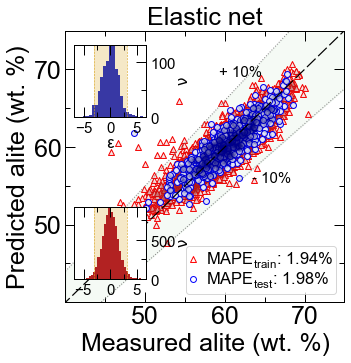

In [302]:
#load best model
avg_train_results = [0.79, 1.16, 1.94]
best_model = pickle.load(open(f'./saved_models/{phase}/all_inputs/model_{titles[3]}.pkl','rb')) 
parity_train_test(best_model, titles[3])

# Random forest

# Hyper parametric optimization

In [ ]:
regressor = RandomForestRegressor()
hyperparameter_grid  = {'bootstrap': [True],
 'max_depth': [10, 12, 15,20],
 'max_features': ['sqrt',0.75, 0.5],
 'min_samples_leaf': [1, 2, 3,4,6,8],
 'min_samples_split': [2,4, 5,7, 8,10],
 'n_estimators': [200, 300, 400, 600, 800],
 'ccp_alpha' : [0.0001, 0.001],
 }

# run randomized search
n_iter_search = 140
random_search = RandomizedSearchCV(estimator=regressor, param_distributions=hyperparameter_grid,
                                   n_iter=n_iter_search , cv=4, scoring ='neg_mean_absolute_percentage_error' , verbose = 3)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search_svr))

best_regressor = random_search.best_estimator_
print(best_regressor )
print('best parameters:' , random_search.best_params_)

In [315]:
Rfreg = RandomForestRegressor(
    n_estimators=300, 
    random_state=0, 
    max_depth=12, 
    n_jobs=-1, 
    ccp_alpha=0.0001, 
    max_features=0.75, 
    bootstrap=True, 
    min_samples_leaf=4, 
    min_samples_split=8
)
best_model=Rfreg.fit(X_train,y_train)
with open(f'./saved_models/{phase}/all_inputs/model_{titles[4]}.pkl', 'wb') as f:   # save best model
    pickle.dump(best_model,f)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [312]:
# best_model = random_search.best_estimator_
from sklearn.model_selection import KFold

kf = KFold(n_splits=4)
train_fold_results = []
val_fold_results = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    best_model.fit(X_train_fold, y_train_fold)
    y_val_pred = best_model.predict(X_val_fold)
    y_train_pred = best_model.predict(X_train_fold)

    train_fold_r2 = r2_score(y_train_fold, y_train_pred)
    train_fold_mae = mean_absolute_error(y_train_fold, y_train_pred)
    train_fold_mape = np.round((mean_absolute_percentage_error(y_train_fold,y_train_pred ))*100,2)

    val_fold_r2 = r2_score(y_val_fold, y_val_pred)
    val_fold_mae = mean_absolute_error(y_val_fold, y_val_pred)
    val_fold_mape = np.round((mean_absolute_percentage_error(y_val_fold,y_val_pred ))*100,2)

    train_fold_results.append((train_fold_r2, train_fold_mae, train_fold_mape))
    val_fold_results.append((val_fold_r2, val_fold_mae, val_fold_mape))
avg_train_results = [round(x,2) for x in list(np.mean(np.array(train_fold_results), axis=0))]  # Average values of R2, MAE and MAPE on train folds
avg_val_results =  [round(x,2) for x in list(np.mean(np.array(val_fold_results), axis=0))]    # Average values of R2, MAE and MAPE on val folds
print(f"Avg Training:  R^2 = {avg_train_results[0]}, MAE = {avg_train_results[1]}, MAPE = {avg_train_results[2]}%")
print(f"Avg Val:  R^2 = {avg_val_results[0]}, MAE = {avg_val_results[1]}, MAPE = {avg_val_results[2]}%")

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(ccp_alpha=0.0001, max_depth=12, max_features=0.75,
                      min_samples_leaf=4, min_samples_split=8, n_estimators=300,
                      n_jobs=-1, random_state=0)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(ccp_alpha=0.0001, max_depth=12, max_features=0.75,
                      min_samples_leaf=4, min_samples_split=8, n_estimators=300,
                      n_jobs=-1, random_state=0)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(ccp_alpha=0.0001, max_depth=12, max_features=0.75,
                      min_samples_leaf=4, min_samples_split=8, n_estimators=300,
                      n_jobs=-1, random_state=0)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(ccp_alpha=0.0001, max_depth=12, max_features=0.75,
                      min_samples_leaf=4, min_samples_split=8, n_estimators=300,
                      n_jobs=-1, random_state=0)

Avg Training:  R^2 = 0.91, MAE = 0.72, MAPE = 1.21%
Avg Val:  R^2 = 0.77, MAE = 1.2, MAPE = 2.02%


Test: R^2 = 0.77, MAE = 1.16, MAPE = 1.94%


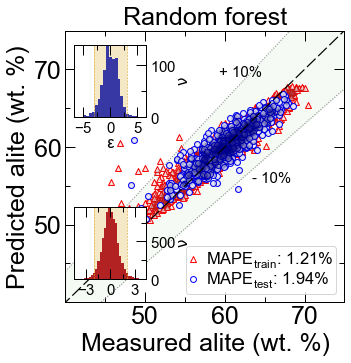

In [320]:
best_model = pickle.load(open(f'./saved_models/{phase}/all_inputs/model_{titles[4]}.pkl','rb')) 
parity_train_test(best_model, titles[4])

# XGBoost

In [ ]:
regressor = XGBRegressor()
hyperparameter_grid= {'alpha': [0.00001, 0.0001,0.001, 0.1, 1]} 


# run randomized search
n_iter_search = 140
random_search = RandomizedSearchCV(estimator=regressor, param_distributions=hyperparameter_grid,
                                   n_iter=n_iter_search , cv=4, scoring ='neg_mean_absolute_percentage_error' , verbose = 3)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search_svr))

best_regressor = random_search.best_estimator_
print(best_regressor )
print('best parameters:' , random_search.best_params_)

In [ ]:
best_model = XGBRegressor(
    random_state=5,
    n_estimators=500,           # Increased for better learning with a reduced rate
    learning_rate=0.03,         # Reduced to allow for more gradual learning
    max_depth=6,                # Decreased to reduce complexity
    min_child_weight=10,        # Increased to prevent overfitting
    subsample=0.8,              # Reduced to add randomness and prevent overfitting
    colsample_bytree=0.8,       # Reduced to add feature selection randomness
    reg_lambda=7,               # Increased regularization
    reg_alpha=3,                # Increased regularization
    n_jobs=-1
).fit(X_train,y_train)

get_score('Train',actual=y_train,predicted=best_model.predict(X_train))
with open(f'./saved_models/{phase}/all_inputs/model_{titles[5]}.pkl', 'wb') as f:   # save best model
    pickle.dump(best_model,f)

In [327]:
# best_model = random_search.best_estimator_
from sklearn.model_selection import KFold

kf = KFold(n_splits=4)
train_fold_results = []
val_fold_results = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    best_model.fit(X_train_fold, y_train_fold)
    y_val_pred = best_model.predict(X_val_fold)
    y_train_pred = best_model.predict(X_train_fold)

    train_fold_r2 = r2_score(y_train_fold, y_train_pred)
    train_fold_mae = mean_absolute_error(y_train_fold, y_train_pred)
    train_fold_mape = np.round((mean_absolute_percentage_error(y_train_fold,y_train_pred ))*100,2)

    val_fold_r2 = r2_score(y_val_fold, y_val_pred)
    val_fold_mae = mean_absolute_error(y_val_fold, y_val_pred)
    val_fold_mape = np.round((mean_absolute_percentage_error(y_val_fold,y_val_pred ))*100,2)

    train_fold_results.append((train_fold_r2, train_fold_mae, train_fold_mape))
    val_fold_results.append((val_fold_r2, val_fold_mae, val_fold_mape))
avg_train_results = [round(x,2) for x in list(np.mean(np.array(train_fold_results), axis=0))]  # Average values of R2, MAE and MAPE on train folds
avg_val_results =  [round(x,2) for x in list(np.mean(np.array(val_fold_results), axis=0))]    # Average values of R2, MAE and MAPE on val folds
print(f"Avg Training:  R^2 = {avg_train_results[0]}, MAE = {avg_train_results[1]}, MAPE = {avg_train_results[2]}%")
print(f"Avg Val:  R^2 = {avg_val_results[0]}, MAE = {avg_val_results[1]}, MAPE = {avg_val_results[2]}%")

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=10, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=5, ...)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=10, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=5, ...)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=10, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=5, ...)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=10, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=5, ...)

Avg Training:  R^2 = 0.94, MAE = 0.62, MAPE = 1.03%
Avg Val:  R^2 = 0.83, MAE = 1.03, MAPE = 1.73%


Test: R^2 = 0.82, MAE = 1.02, MAPE = 1.72%


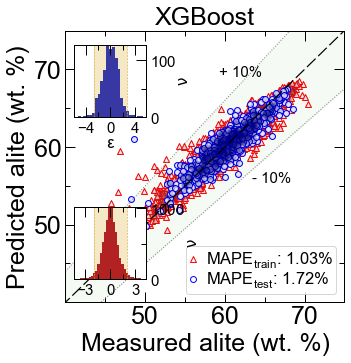

In [331]:
best_model = pickle.load(open(f'./saved_models/{phase}/all_inputs/model_{titles[5]}.pkl','rb'))
parity_train_test(best_model, titles[5])

In [11]:
titles = ['Linear regression', 'Lasso', 'Ridge', 'Elastic net', 'Random forest', 'XGBoost', 'SVR', 'GPR', 'NN']

# NN

# Reading data from HPC (NN predicting)

In [556]:
df = pd.read_excel('df_alite.xlsx')

y_test_pred = df['alite_pred'].to_list()
test_actual = df['alite_actual'].to_list()
train_actual = y_train['alite'].to_list()
y_train_pred = train_actual

# df = y_test.reset_index().rename(columns={'alite':'alite_actual'}, inplace = False)
# df['alite_pred'] = prediction_altie
# df.sort_values('index', ascending=True, inplace=True)
df
actual = df['alite_actual'].to_list()
ML_pred = df['alite_pred'].to_list()
prediction_altie = ML_pred

index  alite_actual  alite_pred
0       59         63.51   61.943020
1       61         61.67   61.708565
2       73         62.34   62.084850
3       74         61.53   60.661163
4       76         59.75   59.889378
..     ...           ...         ...
862   8648         53.53   54.240273
863   8666         62.61   63.268688
864   8667         61.14   60.854221
865   8670         59.24   60.484016
866   8677         63.66   60.602230

[867 rows x 3 columns]

# Training 30 models for quantifying prediction uncertainty


In [ ]:
X_train = pd.read_excel('X_train.xlsx')
y_train = pd.read_excel('y_train.xlsx')
X_test= pd.read_excel('X_test.xlsx')
y_test = pd.read_excel('y_test.xlsx')

In [347]:
training_scores = []   # 31 R2 scores 
test_scores_30models = []    # 31 R2 scores 
December_names = []
for i in range(len(X_test)):
    December_names.append(i+1)
December_backbone = pd.DataFrame(December_names)
seeds = 30
for inter in range(0,seeds):  # 30 models
    model = XGBRegressor(
    random_state = inter,subsample=0.999, reg_lambda=5,
    reg_alpha=1, n_estimators=300,
    min_child_weight=5, max_depth=8,
    learning_rate=0.05, colsample_bytree=1, n_jobs=-1
    ).fit(X_train,y_train)
    with open(f'./saved_models/alite/model_{seeds}.pkl', 'wb') as f:   # model 0 to 29. 
        pickle.dump(model,f)
    test_predictions_Dec = list(model.predict(X_test))
    training_scores.append(get_score('Training',actual=y_train,predicted=model.predict(X_train))) 
    test_scores_30models.append(get_score('Test',actual=y_test,predicted = test_predictions_Dec))
    Dec_pred_per_model = pd.DataFrame(test_predictions_Dec)
    December_backbone = pd.concat([December_backbone,Dec_pred_per_model], axis =1)

December_backbone = December_backbone.iloc[:,1:]
December_backbone.columns = [i for i in range(1,seeds+1)]

In [438]:
chronological = y_test.reset_index()
chronological = pd.concat([chronological, December_backbone], axis = 1)
chronological.sort_values('index', ascending=True, inplace=True)
chronological.drop(columns=['index', 'alite'], inplace = True)

In [419]:
with open('./December_backbone_alite', 'wb') as f:   
        pickle.dump(chronological,f)

In [539]:
December_backbone = pickle.load(open('./December_backbone_alite','rb')) 
mean = np.array(December_backbone.T.describe().T['mean'].to_list())
sigma = np.array(December_backbone.T.describe().T['std'].to_list())
two_sigma_max = np.array(mean + 2 * sigma) 
two_sigma_min = np.array(mean - 2 * sigma) 
three_sigma_max = np.array(mean + 3 * sigma) 
three_sigma_min = np.array(mean - 3 * sigma) 

In [ ]:
chronological.reset_index(inplace = True)
chronological.drop(columns=['index'], inplace = True)
chronological[31] = actual
calculation_backbone= chronological.T

In [535]:
total_seeds = 30
fractional_scores = pd.DataFrame(range(0,total_seeds), columns=['index_backbone'])
for i in calculation_backbone.columns:
    all_p_on_a_day = calculation_backbone[i].to_list()[:-1]
    a =  calculation_backbone[i].to_list()[-1]
    frac_score = []
    for j in all_p_on_a_day:
        # frac_score.append((j - a)/((j+a)/2))
        frac_score.append((abs((j - a)/a))*100)
    data = pd.DataFrame(frac_score,columns=[i])
    fractional_scores = pd.concat([fractional_scores,data], axis=1)
fractional_scores.drop(columns=['index_backbone'], inplace = True)  # has 31 fractional scores (at each prediction point) corresponding to 31 seeds

median_frc_scores = []
for i in list(fractional_scores.columns):
    # median_frc_scores.append(statistics.median(fractional_scores[i].to_list()))
    median_frc_scores.append(statistics.mean(fractional_scores[i].to_list()))
# *** run this before ploting fractional bias
std_error= fractional_scores.describe().T['std'].to_list()
median_plus_2std = [median_frc_scores[i] + 2*std_error[i] for i in range(len(std_error))] 
median_minus_2std = [median_frc_scores[i] - 2*std_error[i] for i in range(len(std_error))] 
median_plus_3std = [median_frc_scores[i] + 3*std_error[i] for i in range(len(std_error))] 
median_minus_3std = [median_frc_scores[i] - 3*std_error[i] for i in range(len(std_error))] 

# ***** run this before ploting predictions.
mean = calculation_backbone[:-1].describe().T['mean'].to_list()
std = calculation_backbone[:-1].describe().T['std'].to_list()
mean_plus_2std = [mean[i] + 2*std[i] for i in range(len(std))] 
mean_minus_2std = [mean[i] - 2*std[i] for i in range(len(std))] 
mean_plus_3std = [mean[i] + 3*std[i] for i in range(len(std))] 
mean_minus_3std = [mean[i] - 3*std[i] for i in range(len(std))] 

# Developing plant specific clinker equation 


In [38]:
names = ['$CaO$', '$SiO_2$', '$Al_2O_3$','$Fe_2O_3$', 'MgO', '$SO_3$', '$K_2O$', '$Na_2O$', 'Cl']

# Bogue predictions for the plant

In [551]:
testing_df = pd.concat([X_test, y_test], axis= 1)  #testing and training df same as PP, frm, hrm and clinker oxide
training_df = pd.concat([X_train,y_train], axis= 1)

In [552]:
y_bogue = testing_df.iloc[:,-10:].loc[:,['cao', 'sio2', 'al2o3', 'fe2o3', 'alite']].iloc[:,[-1]]
X_bogue = testing_df.iloc[:,-10:].loc[:,['cao', 'sio2', 'al2o3', 'fe2o3', 'alite']].iloc[:,:-1]

In [553]:
X_bogue.reset_index(inplace=True)
X_bogue.sort_values('index', ascending=True, inplace=True)

In [554]:
cao= X_bogue['cao'].to_list()
sio2= X_bogue['sio2'].to_list()
al2o3= X_bogue['al2o3'].to_list()
fe2o3 = X_bogue['fe2o3'].to_list()

In [555]:
bogue = []
for i in range(len(cao)):
    bogue.append(4.07 *cao[i] -7.60 *sio2[i] -6.72*al2o3[i]-1.42*fe2o3[i])

taylor = []
for i in range(len(cao)):
    taylor.append(-1.5545*fe2o3[i]+4.6412*cao[i]-8.8387*sio2[i]- 7.0946*al2o3[i])

    # 4.6412 ∙ CaO − 8.8387 ∙ SiO2 − 7.0946∙ Al2O3 − 1.5545∙ 𝐹𝑒2O3

In [545]:
bogue_mpe = MPE( actual,bogue)
bogue_mpe
taylor_mpe = MPE( actual, taylor)
taylor_mpe
ML_mpe = 1.24

7.45

20.68

# Develop Linear equation

In [26]:
# from xides dataset only

reg_alite = LinearRegression().fit(X_train,y_train)
get_score('Training',actual= y_train,predicted=reg_alite.predict(X_train))
get_score('Test',actual= y_test,predicted=reg_alite.predict(X_test))
predicted_linear=reg_alite.predict(X_test)

rounded = []
for i in range(X_train.shape[1]):
    m = reg_alite.coef_[0][i]
    rounded.append(round(m,2))
    
reg_alite.intercept_
rounded
MPE(y_test[y_test.columns[0]].to_list(), array_to_list(reg_alite.predict(X_test)))

Training 0.78 1.17 2.369


0.78

Test 0.79 1.146 2.052


0.79

array([-218.66903115])

[-0.09,
 0.16,
 -0.01,
 0.03,
 -0.01,
 -0.01,
 -0.0,
 -0.04,
 0.0,
 -0.0,
 0.0,
 -0.01,
 -0.0,
 0.02,
 0.02,
 -0.0,
 0.0,
 0.01,
 0.01,
 -0.0,
 -0.0,
 -0.02,
 0.0,
 -0.04,
 -0.0,
 -0.05,
 -0.0,
 -0.05,
 0.04,
 0.0,
 0.04,
 0.08,
 -0.52,
 0.44,
 1.52,
 -0.51,
 3.83,
 1.46,
 1.93,
 -2.83,
 -8.86,
 -12.52,
 7.78,
 -0.11,
 26.41,
 -7.93,
 -27.76,
 0.03,
 -0.01,
 -0.14,
 3.79,
 -2.55,
 -4.49,
 -0.51,
 0.54,
 5.95,
 -17.23,
 15.32,
 -62.28]

1.91

In [546]:
testing_df = pd.concat([X_test, y_test], axis= 1)  #testing and training df same as PP, frm, hrm and clinker oxide
training_df = pd.concat([X_train,y_train], axis= 1)
# test_actual = final[final.isin(testing_df)].dropna()['alite'].to_list()
# df = y_test.reset_index().rename(columns={'alite':'alite_actual'}, inplace = False)
# df['alite_pred'] = prediction_altie
# df.sort_values('index', ascending=True, inplace=True)
# df
# actual = df['alite_actual'].to_list()
# ML_pred = df['alite_pred'].to_list()

In [547]:
y_train_liner = training_df.iloc[:,[-10,-9, -8,-7,-1]].iloc[:,[-1]]
X_train_liner = training_df.iloc[:,[-10,-9, -8,-7,-1]].iloc[:,:-1]
y_test_liner = testing_df.iloc[:,[-10,-9, -8,-7,-1]].iloc[:,[-1]]
X_test_liner = testing_df.iloc[:,[-10,-9, -8,-7,-1]].iloc[:,:-1]

# Different cases

Only major clinker oxides

In [550]:
# Only major CO
reg_alite = LinearRegression(fit_intercept= False).fit(X_train_liner,y_train_liner )
get_score('Training',actual= y_train_liner,predicted=reg_alite.predict(X_train_liner))
get_score('Test',actual= y_test_liner,predicted=reg_alite.predict(X_test_liner))
predicted_linear=reg_alite.predict(X_test_liner)

rounded = []
for i in range(X_train_liner.shape[1]):
    m = reg_alite.coef_[0][i]
    rounded.append(round(m,2))
    
reg_alite.intercept_
rounded

df_linear = y_test_liner.reset_index().rename(columns={'alite':'alite_actual'}, inplace = False)
df_linear['alite_pred'] = predicted_linear
df_linear.sort_values('index', ascending=True, inplace=True)
df_linear
actual_linear = df_linear['alite_actual'].to_list()
linear_pred = df_linear['alite_pred'].to_list()
minor_no_i= linear_pred.copy()
mpe_minor_no_i = MPE(actual, minor_no_i)
mpe_minor_no_i

Training 0.47 1.883 5.794


0.47

Test 0.46 1.758 5.096


0.46

0.0

[2.99, -4.55, -7.35, 0.12]

index  alite_actual  alite_pred
525     60         59.73   61.351489
772     62         62.04   61.702627
720     74         61.53   60.799948
748     75         59.58   60.868129
472     77         60.61   59.413355
..     ...           ...         ...
118   8624         63.79   62.328430
267   8636         58.23   61.730312
703   8660         60.00   60.940902
484   8663         67.70   67.411683
230   8677         63.66   62.643701

[865 rows x 3 columns]

4.65

In [353]:
reg_alite = LinearRegression().fit(X_train_liner,y_train_liner )
get_score('Training',actual= y_train_liner,predicted=reg_alite.predict(X_train_liner))
get_score('Test',actual= y_test_liner,predicted=reg_alite.predict(X_test_liner))
predicted_linear=reg_alite.predict(X_test_liner)

rounded = []
for i in range(X_train_liner.shape[1]):
    m = reg_alite.coef_[0][i]
    rounded.append(round(m,2))
    
reg_alite.intercept_
rounded

df_linear = y_test_liner.reset_index().rename(columns={'alite':'alite_actual'}, inplace = False)
df_linear['alite_pred'] = predicted_linear
df_linear.sort_values('index', ascending=True, inplace=True)
actual_linear = df_linear['alite_actual'].to_list()
linear_pred = df_linear['alite_pred'].to_list()
minor_with_i= linear_pred.copy()
mpe_minor_with_i = MPE(actual, minor_with_i)
mpe_minor_with_i 

0.51

0.54

array([-159.11410103])

[4.84, -3.62, -4.47, 1.52]

4.96

In [144]:
y_train_liner = training_df.iloc[:,-10:].iloc[:,[-1]]
X_train_liner = training_df.iloc[:,-10:].iloc[:,:-1]
y_test_liner = testing_df.iloc[:,-10:].iloc[:,[-1]]
X_test_liner = testing_df.iloc[:,-10:].iloc[:,:-1]

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_liner)
X_test_s = scaler.transform(X_test_liner)
y_train_s  = scaler.fit_transform(y_train_liner)
y_test_s  = scaler.transform(y_test_liner)

In [ ]:
# LR on scalled data 

reg_alite = LinearRegression().fit(X_train_s,y_train_s)
get_score('Training',actual= y_train_s,predicted=reg_alite.predict(X_train_s))
get_score('Test',actual= y_test_s,predicted=reg_alite.predict(X_test_s))
predicted_linear=reg_alite.predict(X_test_s)

rounded = []
for i in range(X_train_s.shape[1]):
    m = reg_alite.coef_[0][i]
    rounded.append(round(m,2))
    
reg_alite.intercept_
rounded
MPE(y_test_s[y_test_s.columns[0]].to_list(), array_to_list(reg_alite.predict(X_test_s)))

In [356]:
reg_alite = LinearRegression(fit_intercept= False).fit(X_train_liner,y_train_liner )   
get_score('Training',actual= y_train_liner,predicted=reg_alite.predict(X_train_liner))
get_score('Test',actual= y_test_liner,predicted=reg_alite.predict(X_test_liner))
predicted_linear=reg_alite.predict(X_test_liner)

rounded = []
for i in range(X_train_liner.shape[1]):
    m = reg_alite.coef_[0][i]
    rounded.append(round(m,2))
    
reg_alite.intercept_
rounded

df_linear = y_test_liner.reset_index().rename(columns={'alite':'alite_actual'}, inplace = False)
df_linear['alite_pred'] = predicted_linear
df_linear.sort_values('index', ascending=True, inplace=True)
df_linear
actual_linear = df_linear['alite_actual'].to_list()
linear_pred = df_linear['alite_pred'].to_list()
linear_no_i= linear_pred.copy()
mpe_linear_no_i = MPE(actual, linear_no_i)
mpe_linear_no_i

0.54

0.57

0.0

[3.08, -4.72, -5.59, 0.09, -1.3, 2.81, -13.62, 4.78, -83.96]

index  alite_actual  alite_pred
0        0         55.35   58.089037
1        1         61.27   60.497190
2        2         64.01   62.151198
3        3         55.62   56.711115
4        4         62.27   61.225381
..     ...           ...         ...
862    862         63.33   64.871996
863    863         51.47   55.895664
864    864         59.45   59.670034
865    865         57.48   56.981102
866    866         60.75   59.671609

[867 rows x 3 columns]

4.98

In [145]:
reg_alite = LinearRegression().fit(X_train_liner,y_train_liner )
get_score('Training',actual= y_train_liner,predicted=reg_alite.predict(X_train_liner))
get_score('Test',actual= y_test_liner,predicted=reg_alite.predict(X_test_liner))
predicted_linear=reg_alite.predict(X_test_liner)

rounded = []
for i in range(X_train_liner.shape[1]):
    m = reg_alite.coef_[0][i]
    rounded.append(round(m,2))
    
reg_alite.intercept_
rounded

df_linear = y_test_liner.reset_index().rename(columns={'alite':'alite_actual'}, inplace = False)
df_linear['alite_pred'] = predicted_linear
df_linear.sort_values('index', ascending=True, inplace=True)
df_linear
actual_linear = df_linear['alite_actual'].to_list()
linear_pred = df_linear['alite_pred'].to_list()
mpe_LR= MPE(actual, linear_pred)
mpe_LR

Training 0.57 1.718 4.731


0.57

Test 0.54 1.628 4.306


0.54

array([-168.97124629])

[4.89, -3.5, -3.75, 2.41, 0.34, 4.05, -8.73, 5.85, -79.44]

index  alite_actual  alite_pred
525     60         59.73   61.629603
772     62         62.04   62.660335
720     74         61.53   61.332385
748     75         59.58   61.132553
472     77         60.61   60.573181
..     ...           ...         ...
118   8624         63.79   63.445234
267   8636         58.23   61.353677
703   8660         60.00   59.973737
484   8663         67.70   69.586214
230   8677         63.66   62.493406

[865 rows x 3 columns]

4.84

# Model predictions on a timescale

In [ ]:
y_a =             actual_linear[low:high]      
# y_m=              mean[low:high]             
# y_2sigma_max =    two_sigma_max[low:high]    
# y_2sigma_min =    two_sigma_min[low:high]   
# y_3sigma_max =    three_sigma_max[low:high]  
# y_3sigma_min =    three_sigma_min[low:high]

y_minor_no_i = minor_no_i[low:high]   
# y_minor_with_i = minor_with_i[low:high]   
# y_linear_no_i = linear_no_i[low:high]   

bogue_plot = bogue[low:high]
linear_pred_plot = linear_pred[low:high]  

In [ ]:
minimum = 50
maximum = 75

style = 'bold'
s = 13
matplotlib.rcParams['axes.linewidth'] = 1
w =2


# from matplotlib import pyplot as plt
# import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(5,5))

_= plt.scatter(actual,bogue,color = ['blue'] , s = 30, alpha = 0.2)
_= plt.scatter(actual_linear,linear_pred,color = ['black'] , s = 30, alpha = 0.3, marker= 'v')
_= plt.plot([minimum, minimum],[minimum, minimum], color = 'white', lw = 0)
_= plt.plot([minimum, maximum],[minimum, maximum], color = 'black', lw = 1)

# _= plt.xticks(np.arange(minimum, maximum + step, step=step), rotation = 0, fontweight = 'normal', fontsize = 15)
# _= plt.yticks(np.arange(minimum, maximum+ step, step=step), fontweight = 'normal', fontsize = 15)

_= plt.xticks(rotation = 0, fontweight = style, fontsize = s)
_= plt.yticks([50,60,70],[50,60,70],fontweight = style, fontsize = s)

# _= plt.xlim(left = minimum, right = maximum)
# _= plt.ylim(bottom = minimum, top = maximum)

# box = ('Test $R^2$=0.90\nTrain $R^2$=0.91')
# _= ax.text( 0.29,0.34,box, transform=ax.transAxes, linespacing=0.7 ,fontsize=s,verticalalignment='top', fontweight=style)
# box = ('MAPE=1.24')
# _= ax.text( 0.35,0.4,box, transform=ax.transAxes, linespacing=0.7 ,fontsize=s,verticalalignment='top', fontweight=style)
# _= plt.xlabel('Measured alite, $C_{3}S$ (%)', fontweight = style, fontsize = s)
# _= plt.ylabel('Predicted alite, $C_{3}S$ (%)', fontweight =style, fontsize = s)
# _= plt.title(title, fontweight = style, fontsize = s)
# _= plt.legend([f'Test($R^2$=0.90)', f'Train($R^2$=0.91)'],labelspacing = 0, loc = 'lower right', frameon = False,prop = {'weight' : style, 'size' : s})
_= ax.tick_params('both', length=10, width=w, which='major')
_= ax.tick_params('both', length=5, width=w, which='minor')

# # incet clinker equation
left, bottom, width, height = [0.15, 0.64, 0.22, 0.22]
ax2 = fig.add_axes([left, bottom, width, height])
p = np.array(linear_pred)
a = np.array(actual_linear)
std=np.std(p - a)
mean=np.mean(p - a)
xx=mean-2*std
yy = 0
y1,x,_ = ax2.hist(p - a, bins = int(1+3.3*np.log(len(p-a))) ,color='black',range = [-4*std, 4*std] )
rec = patches.Rectangle((xx,yy),4*std, max(y1), facecolor ='gray',edgecolor='gray', alpha = 0.2)
ax2.add_patch(rec)
ax2.set_ylim(0,max(y1))
ax2.xaxis.set_major_locator(plt.MaxNLocator(3))
xlabel_ax2 = ax2.get_xticklabels()
ax2.yaxis.tick_right()
# ax2.yaxis.set_tick_params(labelsize =10,weight = 'normal')
_= plt.xticks(fontweight = style)
_= plt.yticks(fontweight = style)
_= ax2.xaxis.set_tick_params(labelsize =15)  #11.8
_= ax2.yaxis.set_tick_params(labelsize =15)
_= ax2.tick_params('both', length=10, width=w, which='major')
_= ax2.tick_params('both', length=5, width=w, which='minor')
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('\u03BD',fontsize=s, fontweight = style, labelpad = 0)
ax2.set_xlabel(r'$\epsilon$',fontsize=s, fontweight = style, labelpad = 0)

# incet bogue
left, bottom, width, height = [0.65, 0.19, 0.22, 0.22]
ax2 = fig.add_axes([left, bottom, width, height])
p = np.array(bogue)
a = np.array(actual)
std=np.std(p - a)
mean=np.mean(p - a)
xx=mean-2*std
yy = 0
y1,x,_ = ax2.hist(p - a, bins = int(1+3.3*np.log(len(p-a))) ,color='blue',range = [-4*std, 4*std] )
rec = patches.Rectangle((xx,yy),4*std, max(y1), facecolor ='royalblue',edgecolor='royalblue', alpha = 0.2)
ax2.add_patch(rec)
ax2.set_ylim(0,max(y1))
ax2.xaxis.set_major_locator(plt.MaxNLocator(3))
xlabel_ax2 = ax2.get_xticklabels()
ax2.yaxis.tick_right()
# ax2.yaxis.set_tick_params(labelsize =10,weight = 'normal')
_= plt.xticks(fontweight = style)
_= plt.yticks(fontweight = style)
_= ax2.xaxis.set_tick_params(labelsize =15)  #11.8
_= ax2.yaxis.set_tick_params(labelsize =15)
_= ax2.tick_params('both', length=10, width=w, which='major')
_= ax2.tick_params('both', length=5, width=w, which='minor')
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('\u03BD',fontsize=s, fontweight = style, labelpad = 0)
ax2.set_xlabel(r'$\epsilon$',fontsize=s, fontweight = style, labelpad = 0)

plt.show()

In [ ]:
_= plt.scatter(test_actual,test_prediction,color = ['firebrick'] , s = 13)
_= plt.plot([minimum, minimum],[minimum, minimum], color = 'white', lw = 0)
_= plt.plot([minimum, maximum],[minimum, maximum], color = 'black', lw = 1)
# _= plt.xticks(np.arange(minimum, maximum + step, step=step), rotation = 45, fontweight = 'bold')
# _= plt.yticks(np.arange(minimum, maximum+ step, step=step), fontweight = 'bold')

_= plt.xticks(rotation = 0, fontweight = 'normal', fontsize = 15)
_= plt.yticks(fontweight = 'normal', fontsize = 15)

box = ('$|MPE|_{test}$ ='+f' {mpe}')
_= ax.text( 0.62,0.25,box, transform=ax.transAxes, linespacing=1 ,fontsize=15,verticalalignment='top', fontweight='normal')
_= plt.xlabel('Measured alite, $C_{3}S$ (%)', fontweight = 'normal', fontsize = 15)
_= plt.ylabel('Predicted alite, $C_{3}S$ (%)', fontweight = 'normal', fontsize = 15)
_= plt.title(title, fontweight = 'normal', fontsize = 16)
_= plt.legend([f'Test  ($R^2$ = 0.9)', f'Train ($R^2$ = 0.91)'],labelspacing = 0, loc = 'lower right', frameon = False,prop = {'weight' : 'normal', 'size' : 15})
_= ax.tick_params('both', length=10, width=1, which='major')
_= ax.tick_params('both', length=5, width=1, which='minor')

# incet
left, bottom, width, height = [0.15, 0.64, 0.22, 0.22]
ax2 = fig.add_axes([left, bottom, width, height])
p = np.array(test_prediction)
a = np.array(test_actual)
std=np.std(p - a)
mean=np.mean(p - a)
xx=mean-2*std
yy = 0
y1,x,_ = ax2.hist(p - a, bins = int(1+3.3*np.log(len(p-a))) ,color='black',range = [-4*std, 4*std] )
rec = patches.Rectangle((xx,yy),4*std, max(y1), facecolor ='r',edgecolor='r', alpha = 0.2)
ax2.add_patch(rec)
ax2.set_ylim(0,max(y1))
ax2.xaxis.set_major_locator(plt.MaxNLocator(3))
xlabel_ax2 = ax2.get_xticklabels()
ax2.yaxis.tick_right()
# ax2.yaxis.set_tick_params(labelsize =10,weight = 'normal')
_= plt.xticks(fontweight = 'normal')
_= plt.yticks(fontweight = 'normal')
_= ax2.xaxis.set_tick_params(labelsize =11.8)
_= ax2.yaxis.set_tick_params(labelsize =11.8)
_= ax2.tick_params('both', length=10, width=1, which='major')
_= ax2.tick_params('both', length=5, width=1, which='minor')
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('\u03BD',fontsize=15, fontweight = 'normal', labelpad = 0)
ax2.set_xlabel(r'$\epsilon$',fontsize=18, fontweight = 'normal', labelpad = 0)

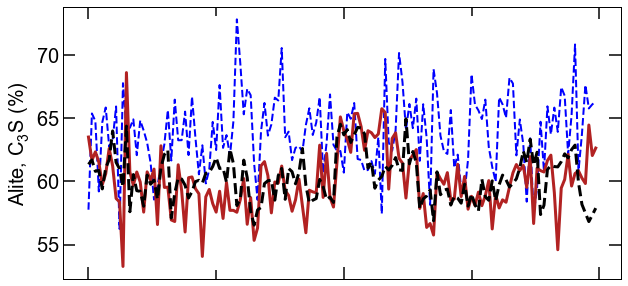

In [121]:
s = 20
x_stamp = []
for i in range(len(y_test)):
    x_stamp.append(i)
fig, ax = plt.subplots(figsize=(10,5))
low = 0
high = 148#len(y_test)
x =               x_stamp[low:high]
y_a =             actual[low:high]      
# y_m=              mean[low:high]             
# y_2sigma_max =    two_sigma_max[low:high]    
# y_2sigma_min =    two_sigma_min[low:high]   
# y_3sigma_max =    three_sigma_max[low:high]  
# y_3sigma_min =    three_sigma_min[low:high]

# y_minor_no_i = minor_no_i[low:high]   
# y_minor_with_i = minor_with_i[low:high]   
# y_linear_no_i = linear_no_i[low:high]   

bogue_plot = bogue[low:high]
linear_pred_plot = linear_pred[low:high]  
# taylor_plot = taylor[low:high]

# ax.set_ylim(9,17)

# ax.set_xlim(-38,897)
_= plt.plot(x,bogue_plot, color = 'blue',linewidth=2, label = 'Bogue',ls = '--') 
_= plt.plot(x,y_a, color = 'firebrick',linewidth=3, label = 'Ground truth')
# _= plt.plot(x,linear_pred_plot, color = 'blue',linewidth=2, label = 'Eq 1',ls = '--')
# _= plt.plot(x,y_linear_no_i, color = 'darkviolet',linewidth=2, label = 'Eq 2',ls = '--') 
# _= plt.plot(x,y_minor_with_i, color = 'black',linewidth=2 , label= 'Eq 3',ls = '--') 
_= plt.plot(x,linear_pred_plot, color = 'black',linewidth=3 , label= 'Clinker equation',ls = '--') 




# _= plt.legend(prop= {'weight':'normal', 'size':s}, labelspacing=0.1, frameon= True, loc = 'lower right')
_= plt.yticks(fontweight= 'normal', fontsize =s )
_= plt.xticks(fontweight='normal',fontsize=s)
_= plt.yticks(fontweight= 'normal', fontsize=s)
_= plt.tick_params(which = 'major', width= 1.5, length =12)
_= plt.tick_params(which = 'minor', width= 1.5, length =9)
_= plt.tick_params(axis='y', which='minor', left=False)
_= plt.tick_params(axis='y', which='minor', right=False)

# _= ax.set_xticks([0, 74, 148], labels = ['2020 January', '2020 February', '2020 March'], rotation = 0, fontsize=s, fontweight= 'normal')
_= ax.set_xticks([0, 74, 148], labels = ['', '', ''], rotation = 0, fontsize=0, fontweight= 'normal')

# _= plt.xlabel('Time', fontsize= s, fontweight = 'normal')
_= plt.ylabel( 'Alite, $C_{3}S$'+' '+'(%)', fontsize= s, fontweight = 'normal')

# _= ax.text(0.02,0.95, ' $|MPE|_{ML} = $'+f'{ML_mpe}'+'\n $|MPE|_{LR}$ = '+f'{mpe_LR}'+'\n $|MPE|_{Taylor} = $'+f'{taylor_mpe}'+'\n $|MPE|_{Bogue} = $'+f'{bogue_mpe}',  transform=ax.transAxes, linespacing=1 ,fontsize=s,verticalalignment='top', fontweight='normal', bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round', alpha = 0.5)) 
plt.show()

<Figure size 360x360 with 0 Axes>

<BarContainer object of 5 artists>

Text(0, 0.5, 'MAPE (%)')

Text(0.5, 0, 'Clinker equation')

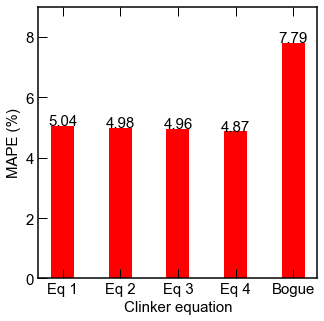

In [360]:
s = 15
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i], y[i]+0.01, round(y[i],2), ha = 'center', fontdict=dict(fontsize=s, fontweight = 'normal') )

error_list =  [mpe_LR,mpe_linear_no_i,mpe_minor_with_i,mpe_minor_no_i,bogue_mpe]
x_vals = ['Eq 1', 'Eq 2', 'Eq 3', 'Eq 4', 'Bogue']
plt.figure(figsize=(5,5))
plt.bar(x_vals,error_list, color ='red',width = 0.4)
 
plt.ylabel("MAPE (%)", fontweight = 'normal', fontsize= s)
plt.xlabel("Clinker equation", fontweight = 'normal', fontsize= s)
# plt.xticks(ind+width,['Alite\n$C_3$S',  'Belite\nC$_2$S',  'Ferrite\nC$_4$AF'] )
_= plt.yticks(fontweight= 'normal', fontsize =s )
_= plt.ylim(0,9)
_= plt.xticks(fontweight='normal',fontsize=s)
_= plt.yticks(fontweight= 'normal', fontsize=s)
_= plt.tick_params(which = 'major', width= 1, length =9)
_= plt.tick_params(which = 'minor', width= 1, length =6)
_= plt.tick_params(axis='y', which='minor', left= False)
_= plt.tick_params(axis='y', which='minor', right=False)
_= plt.tick_params(axis='y', which='major', left=True, direction = 'in')
_= plt.tick_params(axis='x', which='major', bottom=True)
_= plt.tick_params(axis='x', which='minor', bottom=False)
_= plt.tick_params(axis='x', which='minor', top=False)
addlabels([0,1,2,3,4],error_list )
plt.show()

In [361]:
mean = df['alite_pred'].to_list()
three_sigma_max = [mean[i]+0.6 for i in range(len(mean))]
three_sigma_min = [mean[i]-0.6 for i in range(len(mean))]

two_sigma_max   = [mean[i]+0.4 for i in range(len(mean))]
two_sigma_min = [mean[i]-0.4 for i in range(len(mean))]

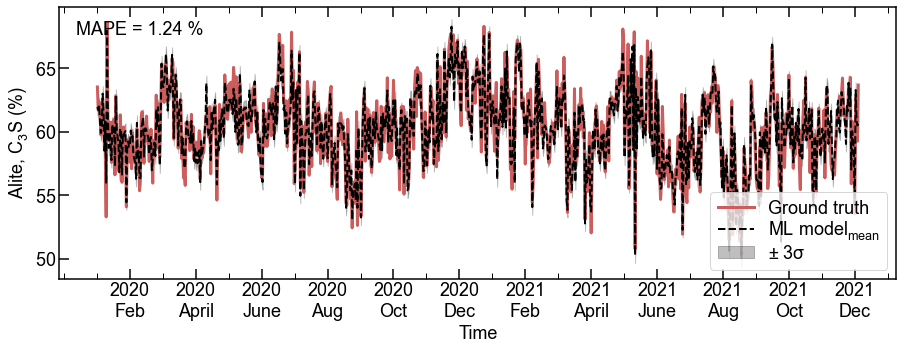

In [365]:
s = 18
x_stamp = []
for i in range(len(y_test)):
    x_stamp.append(i)
fig, ax = plt.subplots(figsize=(15,5))
low = 0
high = len(y_test)
x =               x_stamp[low:high]
y_a =             actual[low:high]      
y_m=              mean[low:high]             
y_2sigma_max =    two_sigma_max[low:high]    
y_2sigma_min =    two_sigma_min[low:high]   
y_3sigma_max =    three_sigma_max[low:high]  
y_3sigma_min =    three_sigma_min[low:high]  
bogue_plot = bogue[low:high]
linear_pred_plot = linear_pred[low:high]
# ax.set_xlim(-38,897)
a, b, c = int(len(x)/23),len(x), int((len(x)/23)*2)
_= ax.set_xticks([i for i in range(a,b,c)], labels = ['2020\nFeb', '2020\nApril', '2020\nJune', '2020\nAug', '2020\nOct', '2020\nDec','2021\nFeb', '2021\nApril', '2021\nJune', '2021\nAug', '2021\nOct', '2021\nDec'], rotation = 0, fontsize=s, fontweight= 'normal')
_= plt.plot(x,y_a, color = 'indianred',linewidth=3, label = 'Ground truth')
_= plt.plot(x,y_m, color = 'black',linewidth=2 , label= 'ML'+' '+'model' + '$_{mean}$',ls = '--') 
_= plt.fill_between(x, y_3sigma_min,y_3sigma_max, color = 'black', alpha = 0.25, label = '$\pm$'+' '+ '3'+'$\sigma$') 
# _= plt.plot(x,bogue_plot, color = 'blue',linewidth=2, label = 'Bogue')
# _= plt.plot(x,linear_pred_plot, color = 'olive',linewidth=2, label = 'LR')
_= plt.legend(prop= {'weight':'normal', 'size':s}, labelspacing=0.1, frameon= True, loc = 'lower right')
# _= plt.xticks(ticks = [0,500,1000,1500,2000,2500],labels=['5 December\n2021', '10 December\n2021','15 December\n2021','20 December\n2021','25 December\n2021','30 December\n2021',], rotation = 45, fontsize = 15, fontweight= 'normal')
_= plt.yticks(fontweight= 'normal', fontsize =s )
# _= plt.xlim(0,34)
_= plt.xticks(fontweight='normal',fontsize=s)
_= plt.yticks(fontweight= 'normal', fontsize=s)
_= plt.tick_params(which = 'major', width= 1.5, length =10)
_= plt.tick_params(which = 'minor', width= 1, length =6)
_= plt.tick_params(axis='y', which='minor', left=False)
_= plt.tick_params(axis='y', which='minor', right=False)

_= plt.xlabel('Time', fontsize= s, fontweight = 'normal')
_= plt.ylabel( 'Alite, $C_{3}S$' +' '+'(%)', fontsize= s, fontweight = 'normal')

_= ax.text(0.02,0.95, f'MAPE = {ML_mpe} %',  transform=ax.transAxes, linespacing=1 ,fontsize=s,verticalalignment='top', fontweight='normal') # , bbox=props
plt.show()

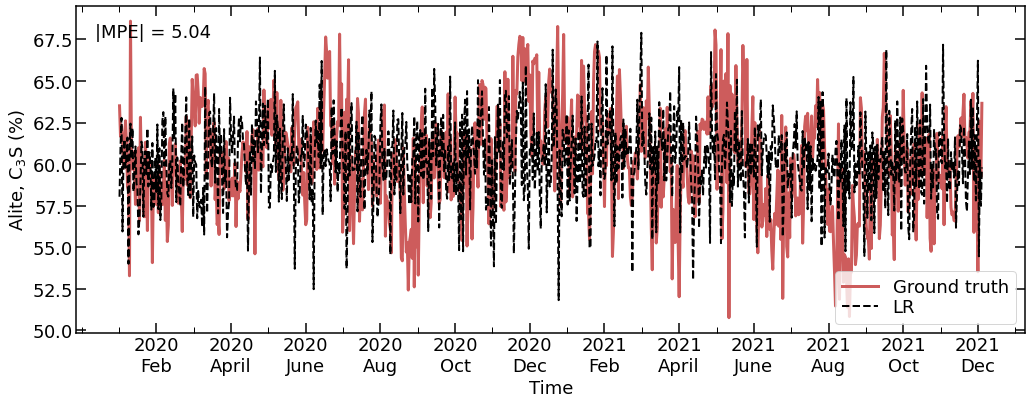

In [38]:
s = 18
x_stamp = []
for i in range(len(y_test)):
    x_stamp.append(i)
fig, ax = plt.subplots(figsize=(17, 6))
low = 0
high = len(y_test)
x =               x_stamp[low:high]
y_a =             actual[low:high]      
y_m=              mean[low:high]             
y_2sigma_max =    two_sigma_max[low:high]    
y_2sigma_min =    two_sigma_min[low:high]   
y_3sigma_max =    three_sigma_max[low:high]  
y_3sigma_min =    three_sigma_min[low:high]  
bogue_plot = bogue[low:high]
linear_pred_plot = linear_pred[low:high]
# ax.set_xlim(-38,897)
a, b, c = int(len(x)/23),len(x), int((len(x)/23)*2)
_= ax.set_xticks([i for i in range(a,b,c)], labels = ['2020\nFeb', '2020\nApril', '2020\nJune', '2020\nAug', '2020\nOct', '2020\nDec','2021\nFeb', '2021\nApril', '2021\nJune', '2021\nAug', '2021\nOct', '2021\nDec'], rotation = 0, fontsize=s, fontweight= 'normal')
_= plt.plot(x,y_a, color = 'indianred',linewidth=3, label = 'Ground truth')
# _= plt.plot(x,y_m, color = 'black',linewidth=2 , label= 'ML'+' '+'model' + '$_{mean}$',ls = '--') 
# _= plt.fill_between(x, y_3sigma_min,y_3sigma_max, color = 'black', alpha = 0.25, label = '$\pm$'+' '+ '3'+'$\sigma$') 
# _= plt.plot(x,bogue_plot, color = 'blue',linewidth=2, label = 'Bogue')
_= plt.plot(x,linear_pred_plot, color = 'black',linewidth=2, label = 'LR', ls = '--')
_= plt.legend(prop= {'weight':'normal', 'size':s}, labelspacing=0.1, frameon= True, loc = 'lower right')
# _= plt.xticks(ticks = [0,500,1000,1500,2000,2500],labels=['5 December\n2021', '10 December\n2021','15 December\n2021','20 December\n2021','25 December\n2021','30 December\n2021',], rotation = 45, fontsize = 15, fontweight= 'normal')
_= plt.yticks(fontweight= 'normal', fontsize =s )
# _= plt.xlim(0,34)
_= plt.xticks(fontweight='normal',fontsize=s)
_= plt.yticks(fontweight= 'normal', fontsize=s)
_= plt.tick_params(which = 'major', width= 1.5, length =10)
_= plt.tick_params(which = 'minor', width= 1, length =6)
_= plt.tick_params(axis='y', which='minor', left=False)
_= plt.tick_params(axis='y', which='minor', right=False)

_= plt.xlabel('Time', fontsize= s, fontweight = 'normal')
_= plt.ylabel( 'Alite, $C_{3}S$' +' '+'(%)', fontsize= s, fontweight = 'normal')

_= ax.text(0.02,0.95, f'|MPE| = {mpe_LR}',  transform=ax.transAxes, linespacing=1 ,fontsize=s,verticalalignment='top', fontweight='normal') # , bbox=props
plt.show()

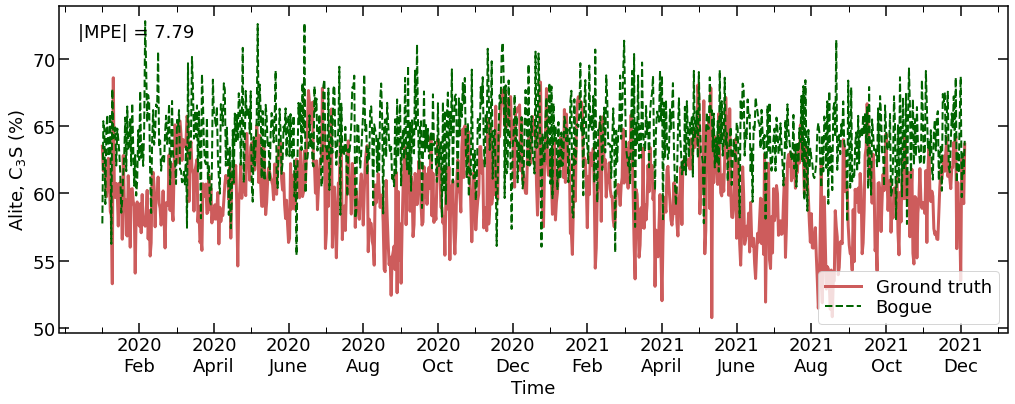

In [39]:
s = 18
x_stamp = []
for i in range(len(y_test)):
    x_stamp.append(i)
fig, ax = plt.subplots(figsize=(17, 6))
low = 0
high = len(y_test)
x =               x_stamp[low:high]
y_a =             actual[low:high]      
y_m=              mean[low:high]             
y_2sigma_max =    two_sigma_max[low:high]    
y_2sigma_min =    two_sigma_min[low:high]   
y_3sigma_max =    three_sigma_max[low:high]  
y_3sigma_min =    three_sigma_min[low:high]  
bogue_plot = bogue[low:high]
linear_pred_plot = linear_pred[low:high]
# ax.set_xlim(-38,897)
a, b, c = int(len(x)/23),len(x), int((len(x)/23)*2)
_= ax.set_xticks([i for i in range(a,b,c)], labels = ['2020\nFeb', '2020\nApril', '2020\nJune', '2020\nAug', '2020\nOct', '2020\nDec','2021\nFeb', '2021\nApril', '2021\nJune', '2021\nAug', '2021\nOct', '2021\nDec'], rotation = 0, fontsize=s, fontweight= 'normal')
_= plt.plot(x,y_a, color = 'indianred',linewidth=3, label = 'Ground truth')
# _= plt.plot(x,y_m, color = 'black',linewidth=2 , label= 'ML'+' '+'model' + '$_{mean}$',ls = '--') 
# _= plt.fill_between(x, y_3sigma_min,y_3sigma_max, color = 'black', alpha = 0.25, label = '$\pm$'+' '+ '3'+'$\sigma$') 
_= plt.plot(x,bogue_plot, color = 'darkgreen',linewidth=2, label = 'Bogue', ls = '--')
# _= plt.plot(x,linear_pred_plot, color = 'olive',linewidth=2, label = 'LR')
_= plt.legend(prop= {'weight':'normal', 'size':s}, labelspacing=0.1, frameon= True, loc = 'lower right')
# _= plt.xticks(ticks = [0,500,1000,1500,2000,2500],labels=['5 December\n2021', '10 December\n2021','15 December\n2021','20 December\n2021','25 December\n2021','30 December\n2021',], rotation = 45, fontsize = 15, fontweight= 'normal')
_= plt.yticks(fontweight= 'normal', fontsize =s )
# _= plt.xlim(0,34)
_= plt.xticks(fontweight='normal',fontsize=s)
_= plt.yticks(fontweight= 'normal', fontsize=s)
_= plt.tick_params(which = 'major', width= 1.5, length =10)
_= plt.tick_params(which = 'minor', width= 1, length =6)
_= plt.tick_params(axis='y', which='minor', left=False)
_= plt.tick_params(axis='y', which='minor', right=False)

_= plt.xlabel('Time', fontsize= s, fontweight = 'normal')
_= plt.ylabel( 'Alite, $C_{3}S$'+' '+'(%)', fontsize= s, fontweight = 'normal')

_= ax.text(0.02,0.95, f'|MPE| = {bogue_mpe}',  transform=ax.transAxes, linespacing=1 ,fontsize=s,verticalalignment='top', fontweight='normal') # , bbox=props
plt.show()

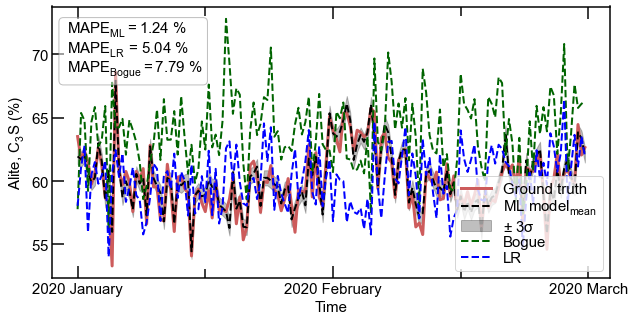

In [368]:
s = 15
x_stamp = []
for i in range(len(y_test)):
    x_stamp.append(i)
fig, ax = plt.subplots(figsize=(10, 5))
low = 0
high = 148#len(y_test)
x =               x_stamp[low:high]
y_a =             actual[low:high]      
y_m=              mean[low:high]             
y_2sigma_max =    two_sigma_max[low:high]    
y_2sigma_min =    two_sigma_min[low:high]   
y_3sigma_max =    three_sigma_max[low:high]  
y_3sigma_min =    three_sigma_min[low:high]
bogue_plot = bogue[low:high]
linear_pred_plot = linear_pred[low:high]  
taylor_plot = taylor[low:high]

# ax.set_ylim(9,17)

# ax.set_xlim(-38,897)
_= ax.set_xticks([0, 74, 148], labels = ['2020 January', '2020 February', '2020 March'], rotation = 0, fontsize=s, fontweight= 'normal')
_= plt.plot(x,y_a, color = 'indianred',linewidth=3, label = 'Ground truth')
_= plt.plot(x,y_m, color = 'black',linewidth=2 , label= 'ML'+' '+'model' + '$_{mean}$',ls = '--') 
_= plt.fill_between(x, y_3sigma_min,y_3sigma_max, color = 'black', alpha = 0.25, label = '$\pm$'+' '+ '3'+'$\sigma$') 
_= plt.plot(x,bogue_plot, color = 'darkgreen',linewidth=2, label = 'Bogue',ls = '--') 
# _= plt.plot(x,taylor_plot, color = 'darkviolet',linewidth=2, label = 'Taylor',ls = '--') 
_= plt.plot(x,linear_pred_plot, color = 'blue',linewidth=2, label = 'LR',ls = '--')

_= plt.legend(prop= {'weight':'normal', 'size':s}, labelspacing=0.1, frameon= True, loc = 'lower right')
_= plt.yticks(fontweight= 'normal', fontsize =s )
_= plt.xticks(fontweight='normal',fontsize=s)
_= plt.yticks(fontweight= 'normal', fontsize=s)
_= plt.tick_params(which = 'major', width= 1.5, length =12)
_= plt.tick_params(which = 'minor', width= 1.5, length =9)
_= plt.tick_params(axis='y', which='minor', left=False)
_= plt.tick_params(axis='y', which='minor', right=False)

_= plt.xlabel('Time', fontsize= s, fontweight = 'normal')
_= plt.ylabel( 'Alite, $C_{3}S$'+' '+'(%)', fontsize= s, fontweight = 'normal')

_= ax.text(0.02,0.95, ' $MAPE_{ML}= $'+f'{ML_mpe} %'+'\n $MAPE_{LR}$ = '+f'{mpe_LR} %'+'\n $MAPE_{Bogue} = $'+f'{bogue_mpe} %',  transform=ax.transAxes, linespacing=1 ,fontsize=s,verticalalignment='top', fontweight='normal', bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round', alpha = 0.5)) #'\n $|MPE|_{Taylor} = $'+f'{taylor_mpe}'+
plt.show()

(53.0, 69.0)

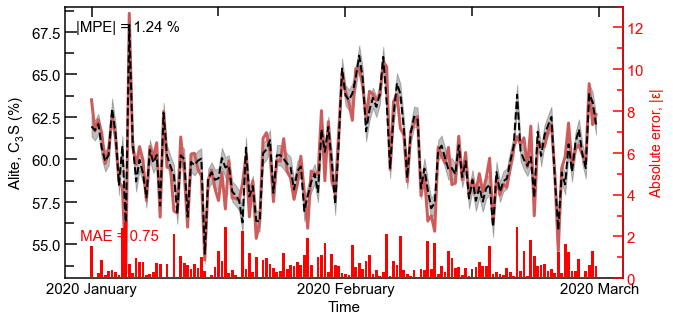

In [371]:
s = 15
x_stamp = []
for i in range(len(y_test)):
    x_stamp.append(i)
fig, ax = plt.subplots(figsize=(10, 5))

low = 0
high = 148#len(y_test)
x =               x_stamp[low:high]
y_a =             actual[low:high]      
y_m=              mean[low:high]        
y_2sigma_max =    two_sigma_max[low:high]    
y_2sigma_min =    two_sigma_min[low:high]   
y_3sigma_max =    three_sigma_max[low:high]  
y_3sigma_min =    three_sigma_min[low:high]  
errors = [abs(y_a[i] - y_m[i]) for i in range(len(y_m))]     
# bogue_plot = bogue[low:high]
# linear_pred_plot = linear_pred[low:high]


_= ax.set_xticks([0, 74, 148], labels = ['2020 January', '2020 February', '2020 March'], rotation = 0, fontsize=s, fontweight= 'normal')
_= plt.plot(x,y_a, color = 'indianred',linewidth=3, label = 'Ground truth')

_= plt.plot(x,y_m, color = 'black',linewidth=2 , label= 'ML'+' '+'model' + '$_{mean}$',ls = '--') 
_= plt.fill_between(x, y_3sigma_min,y_3sigma_max, color = 'black', alpha = 0.25, label = '$\pm$'+' '+ '3'+'$\sigma$') 


_= plt.yticks(fontweight= 'normal', fontsize =s )
# _= plt.xlim(0,34)
ax.set_ylim(53,69)

_= plt.xticks(fontweight='normal',fontsize=s)
_= plt.yticks(fontweight= 'normal', fontsize=s)
_= plt.tick_params(axis = 'y', which = 'major', width= 1.5, length =12)
_= plt.tick_params(axis = 'x', which = 'major', bottom = False)
_= plt.tick_params(which = 'minor', width= 1.5, length =9)
_= plt.tick_params(axis='y', which='minor', left=False)
_= plt.tick_params(axis='y', which='minor', right=False)
_= plt.xlabel('Time', fontsize= s, fontweight = 'normal')
_= plt.ylabel( 'Alite, $C_{3}S$'+' '+'(%)', fontsize= s, fontweight = 'normal')




_= ax.text(0.02,0.95, f'|MPE| = {ML_mpe} %',  transform=ax.transAxes, linespacing=1.3 ,fontsize=s,verticalalignment='top', fontweight='normal') # , bbox=props
_= ax.text(0.02,0.18, f' MAE = 0.75',  transform=ax.transAxes, linespacing=1.3 ,fontsize=s,verticalalignment='top', fontweight='normal', color = 'red')
_=ax2 = ax.twinx()
l =ax2.bar(x,errors, color = 'red', label = r'|$\epsilon$|') #, edgecolor = 'black'
_=ax2.set_ylim(0, 13)
_=plt.tick_params(axis = 'y', which = 'minor', right = 'True', color = 'red')
_=plt.tick_params(axis = 'y', which = 'major', right = 'True', color = 'red')
_=plt.yticks( fontsize=s, fontweight= 'normal', color = 'red')
_=ax2.set_frame_on(True)
_=ax2.patch.set_visible(False)
_=plt.setp(ax2.spines.values(), visible=False)
_=ax2.spines["right"].set_visible(True)
_=ax2.yaxis.label.set_color('red')
_=ax2.spines["right"].set_edgecolor('red')
_= plt.ylabel( r'Absolute error, |$\epsilon$|', fontsize= 14, fontweight = 'normal', color = 'red')
# _= ax.legend(prop= {'weight':'normal', 'size':s}, labelspacing=0.09, frameon= False, loc = 'lower right',bbox_to_anchor=(1, 0.197), bbox_transform=ax.transAxes)
# _= ax2.legend(prop= {'weight':'normal', 'size':s},bbox_to_anchor=(0.69, 0.1), bbox_transform=ax.transAxes)
# _= ax2.legend(prop= {'weight':'normal', 'size':s}, labelspacing=0.1, frameon= True, loc = 'lower right')
plt.show()


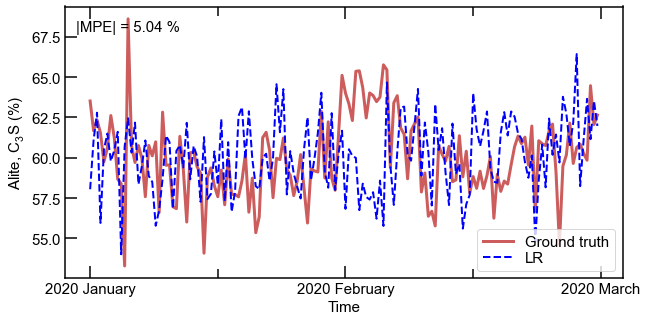

In [372]:
s = 15
x_stamp = []
for i in range(len(y_test)):
    x_stamp.append(i)
fig, ax = plt.subplots(figsize=(10, 5))
low = 0
high = 148#len(y_test)
x =               x_stamp[low:high]
y_a =             actual[low:high]      
y_m=              mean[low:high]             
y_2sigma_max =    two_sigma_max[low:high]    
y_2sigma_min =    two_sigma_min[low:high]   
y_3sigma_max =    three_sigma_max[low:high]  
y_3sigma_min =    three_sigma_min[low:high]  
bogue_plot = bogue[low:high]
linear_pred_plot = linear_pred[low:high]

# ax.set_ylim(7, 25)
_= ax.set_xticks([0, 74, 148], labels = ['2020 January', '2020 February', '2020 March'], rotation = 0, fontsize=s, fontweight= 'normal')
_= plt.plot(x,y_a, color = 'indianred',linewidth=3, label = 'Ground truth')

# _= plt.plot(x,y_m, color = 'black',linewidth=2 , label= 'ML'+' '+'model' + '$_{mean}$',ls = '--') 
# _= plt.fill_between(x, y_3sigma_min,y_3sigma_max, color = 'black', alpha = 0.25, label = '$\pm$'+' '+ '3'+'$\sigma$') 
# _= plt.plot(x,bogue_plot, color = 'darkgreen',linewidth=2, label = 'Bogue',ls = '--')
_= plt.plot(x,linear_pred_plot, color = 'blue',linewidth=2, label = 'LR',ls = '--')

_= plt.legend(prop= {'weight':'normal', 'size':s}, labelspacing=0.1, frameon= True, loc = 'lower right')
_= plt.yticks(fontweight= 'normal', fontsize =s )
# _= plt.xlim(0,34)
_= plt.xticks(fontweight='normal',fontsize=s)
_= plt.yticks(fontweight= 'normal', fontsize=s)
_= plt.tick_params(which = 'major', width= 1.5, length =12)
_= plt.tick_params(which = 'minor', width= 1.5, length =9)
_= plt.tick_params(axis='y', which='minor', left=False)
_= plt.tick_params(axis='y', which='minor', right=False)

_= plt.xlabel('Time', fontsize= s, fontweight = 'normal')
_= plt.ylabel( 'Alite, $C_{3}S$'+' '+'(%)', fontsize= s, fontweight = 'normal')

_= ax.text(0.02,0.95, f'|MPE| = {mpe_LR} %',  transform=ax.transAxes, linespacing=1 ,fontsize=s,verticalalignment='top', fontweight='normal') # , bbox=props
plt.show()

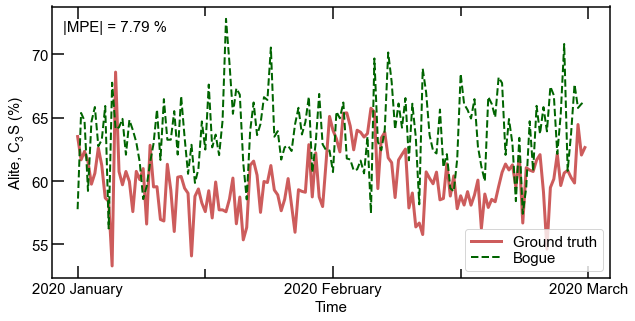

In [373]:
s = 15
x_stamp = []
for i in range(len(y_test)):
    x_stamp.append(i)
fig, ax = plt.subplots(figsize=(10, 5))
low = 0
high = 148#len(y_test)
x =               x_stamp[low:high]
y_a =             actual[low:high]      
y_m=              mean[low:high]             
y_2sigma_max =    two_sigma_max[low:high]    
y_2sigma_min =    two_sigma_min[low:high]   
y_3sigma_max =    three_sigma_max[low:high]  
y_3sigma_min =    three_sigma_min[low:high]  
bogue_plot = bogue[low:high]
linear_pred_plot = linear_pred[low:high]

# ax.set_ylim(7, 25)
_= ax.set_xticks([0, 74, 148], labels = ['2020 January', '2020 February', '2020 March'], rotation = 0, fontsize=s, fontweight= 'normal')
_= plt.plot(x,y_a, color = 'indianred',linewidth=3, label = 'Ground truth')

# _= plt.plot(x,y_m, color = 'black',linewidth=2 , label= 'ML'+' '+'model' + '$_{mean}$',ls = '--') 
# _= plt.fill_between(x, y_3sigma_min,y_3sigma_max, color = 'black', alpha = 0.25, label = '$\pm$'+' '+ '3'+'$\sigma$') 
_= plt.plot(x,bogue_plot, color = 'darkgreen',linewidth=2, label = 'Bogue',ls = '--')
# _= plt.plot(x,linear_pred_plot, color = 'blue',linewidth=2, label = 'LR',ls = '--')

_= plt.legend(prop= {'weight':'normal', 'size':s}, labelspacing=0.1, frameon= True, loc = 'lower right')
_= plt.yticks(fontweight= 'normal', fontsize =s )
# _= plt.xlim(0,34)
_= plt.xticks(fontweight='normal',fontsize=s)
_= plt.yticks(fontweight= 'normal', fontsize=s)
_= plt.tick_params(which = 'major', width= 1.5, length =12)
_= plt.tick_params(which = 'minor', width= 1.5, length =9)
_= plt.tick_params(axis='y', which='minor', left=False)
_= plt.tick_params(axis='y', which='minor', right=False)

_= plt.xlabel('Time', fontsize= s, fontweight = 'normal')
_= plt.ylabel('Alite, $C_{3}S$'+' '+'(%)', fontsize= s, fontweight = 'normal')

_= ax.text(0.02,0.95, f'|MPE| = {bogue_mpe} %',  transform=ax.transAxes, linespacing=1 ,fontsize=s,verticalalignment='top', fontweight='normal') # , bbox=props
plt.show()

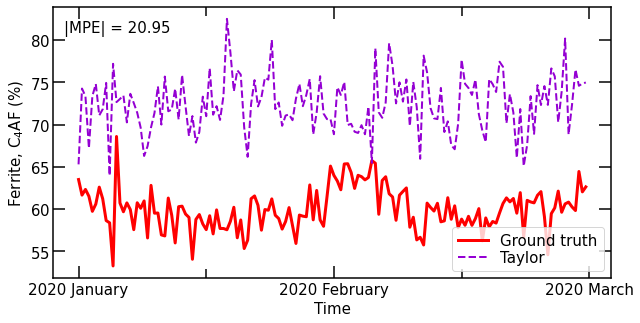

In [47]:
s = 15
x_stamp = []
for i in range(len(y_test)):
    x_stamp.append(i)
fig, ax = plt.subplots(figsize=(10, 5))
low = 0
high = 148#len(y_test)
x =               x_stamp[low:high]
y_a =             actual[low:high]      
y_m=              mean[low:high]             
y_2sigma_max =    two_sigma_max[low:high]    
y_2sigma_min =    two_sigma_min[low:high]   
y_3sigma_max =    three_sigma_max[low:high]  
y_3sigma_min =    three_sigma_min[low:high]  
bogue_plot = bogue[low:high]
taylor_plot = taylor[low:high]
linear_pred_plot = linear_pred[low:high]

# ax.set_ylim(7, 25)
_= ax.set_xticks([0, 74, 148], labels = ['2020 January', '2020 February', '2020 March'], rotation = 0, fontsize=s, fontweight= 'normal')
_= plt.plot(x,y_a, color = 'red',linewidth=3, label = 'Ground truth')

# _= plt.plot(x,y_m, color = 'black',linewidth=2 , label= 'ML'+' '+'model' + '$_{mean}$',ls = '--') 
# _= plt.fill_between(x, y_3sigma_min,y_3sigma_max, color = 'black', alpha = 0.25, label = '$\pm$'+' '+ '3'+'$\sigma$') 
# _= plt.plot(x,bogue_plot, color = 'darkgreen',linewidth=2, label = 'Bogue',ls = '--')
_= plt.plot(x,taylor_plot, color = 'darkviolet',linewidth=2, label = 'Taylor',ls = '--') 
# _= plt.plot(x,linear_pred_plot, color = 'blue',linewidth=2, label = 'LR',ls = '--')

_= plt.legend(prop= {'weight':'normal', 'size':s}, labelspacing=0.1, frameon= True, loc = 'lower right')
_= plt.yticks(fontweight= 'normal', fontsize =s )
# _= plt.xlim(0,34)
_= plt.xticks(fontweight='normal',fontsize=s)
_= plt.yticks(fontweight= 'normal', fontsize=s)
_= plt.tick_params(which = 'major', width= 1.5, length =12)
_= plt.tick_params(which = 'minor', width= 1.5, length =9)
_= plt.tick_params(axis='y', which='minor', left=False)
_= plt.tick_params(axis='y', which='minor', right=False)

_= plt.xlabel('Time', fontsize= s, fontweight = 'normal')
_= plt.ylabel( 'Ferrite, $C_{4}AF$'+' '+'(%)', fontsize= s, fontweight = 'normal')

_= ax.text(0.02,0.95, f'|MPE| = {taylor_mpe}',  transform=ax.transAxes, linespacing=1 ,fontsize=s,verticalalignment='top', fontweight='normal') # , bbox=props
plt.show()

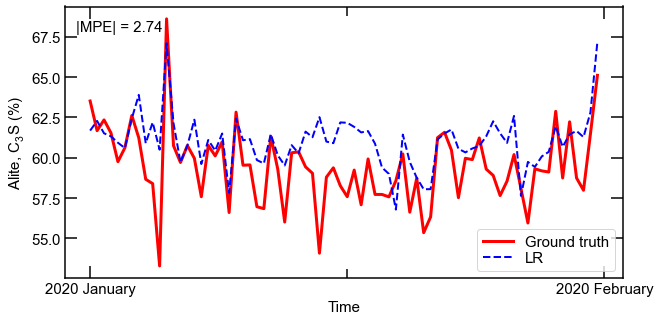

In [702]:
s = 15
x_stamp = []
for i in range(len(y_test)):
    x_stamp.append(i)
fig, ax = plt.subplots(figsize=(10, 5))
low = 0
high = 74#len(y_test)
x =               x_stamp[low:high]
y_a =             actual[low:high]      
y_m=              mean[low:high]             
y_2sigma_max =    two_sigma_max[low:high]    
y_2sigma_min =    two_sigma_min[low:high]   
y_3sigma_max =    three_sigma_max[low:high]  
y_3sigma_min =    three_sigma_min[low:high]
bogue_plot = bogue[low:high]
linear_pred_plot = linear_pred[low:high]  
# ax.set_xlim(-38,897)
_= ax.set_xticks([0, 74], labels = ['2020 January', '2020 February'], rotation = 0, fontsize=s, fontweight= 'normal')
_= plt.plot(x,y_a, color = 'red',linewidth=3, label = 'Ground truth')
# _= plt.plot(x,y_m, color = 'black',linewidth=2 , label= 'ML'+' '+'model' + '$_{mean}$',ls = '--') 
# _= plt.fill_between(x, y_3sigma_min,y_3sigma_max, color = 'black', alpha = 0.25, label = '$\pm$'+' '+ '3'+'$\sigma$') 
# _= plt.plot(x,bogue_plot, color = 'darkgreen',linewidth=2, label = 'Bogue',ls = '--')
_= plt.plot(x,linear_pred_plot, color = 'blue',linewidth=2, label = 'LR',ls = '--')

_= plt.legend(prop= {'weight':'normal', 'size':s}, labelspacing=0.1, frameon= True, loc = 'lower right')
_= plt.yticks(fontweight= 'normal', fontsize =s )
# _= plt.xlim(0,34)
_= plt.xticks(fontweight='normal',fontsize=s)
_= plt.yticks(fontweight= 'normal', fontsize=s)
_= plt.tick_params(which = 'major', width= 1.5, length =12)
_= plt.tick_params(which = 'minor', width= 1.5, length =9)
_= plt.tick_params(axis='y', which='minor', left=False)
_= plt.tick_params(axis='y', which='minor', right=False)

_= plt.xlabel('Time', fontsize= s, fontweight = 'normal')
_= plt.ylabel( 'Alite, $C_{3}S$'+' '+'(%)', fontsize= s, fontweight = 'normal')

_= ax.text(0.02,0.95, f'|MPE| = {mpe_LR}',  transform=ax.transAxes, linespacing=1 ,fontsize=s,verticalalignment='top', fontweight='normal') # , bbox=props
plt.show()

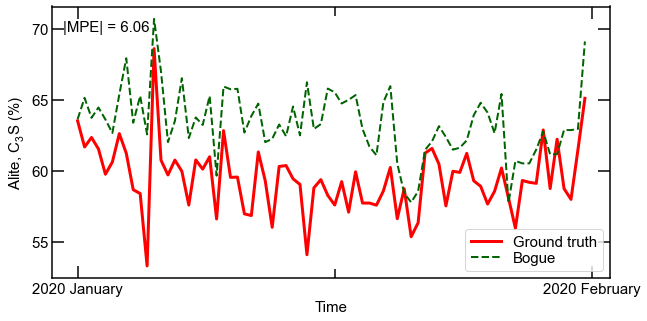

In [704]:
s = 15
x_stamp = []
for i in range(len(y_test)):
    x_stamp.append(i)
fig, ax = plt.subplots(figsize=(10, 5))
low = 0
high = 74#len(y_test)
x =               x_stamp[low:high]
y_a =             actual[low:high]      
y_m=              mean[low:high]             
y_2sigma_max =    two_sigma_max[low:high]    
y_2sigma_min =    two_sigma_min[low:high]   
y_3sigma_max =    three_sigma_max[low:high]  
y_3sigma_min =    three_sigma_min[low:high]
bogue_plot = bogue[low:high]
linear_pred_plot = linear_pred[low:high]  
# ax.set_xlim(-38,897)
_= ax.set_xticks([0, 74], labels = ['2020 January', '2020 February'], rotation = 0, fontsize=s, fontweight= 'normal')
_= plt.plot(x,y_a, color = 'red',linewidth=3, label = 'Ground truth')
# _= plt.plot(x,y_m, color = 'black',linewidth=2 , label= 'ML'+' '+'model' + '$_{mean}$',ls = '--') 
# _= plt.fill_between(x, y_3sigma_min,y_3sigma_max, color = 'black', alpha = 0.25, label = '$\pm$'+' '+ '3'+'$\sigma$') 
_= plt.plot(x,bogue_plot, color = 'darkgreen',linewidth=2, label = 'Bogue',ls = '--') 
# _= plt.plot(x,linear_pred_plot, color = 'blue',linewidth=2, label = 'LR',ls = '--')

_= plt.legend(prop= {'weight':'normal', 'size':s}, labelspacing=0.1, frameon= True, loc = 'lower right')
_= plt.yticks(fontweight= 'normal', fontsize =s )
# _= plt.xlim(0,34)
_= plt.xticks(fontweight='normal',fontsize=s)
_= plt.yticks(fontweight= 'normal', fontsize=s)
_= plt.tick_params(which = 'major', width= 1.5, length =12)
_= plt.tick_params(which = 'minor', width= 1.5, length =9)
_= plt.tick_params(axis='y', which='minor', left=False)
_= plt.tick_params(axis='y', which='minor', right=False)

_= plt.xlabel('Time', fontsize= s, fontweight = 'normal')
_= plt.ylabel( 'Alite, $C_{3}S$'+' '+'(%)', fontsize= s, fontweight = 'normal')

_= ax.text(0.02,0.95, f'|MPE| = {bogue_mpe}',  transform=ax.transAxes, linespacing=1 ,fontsize=s,verticalalignment='top', fontweight='normal') # , bbox=props
plt.show()

(52.0, 78.0)

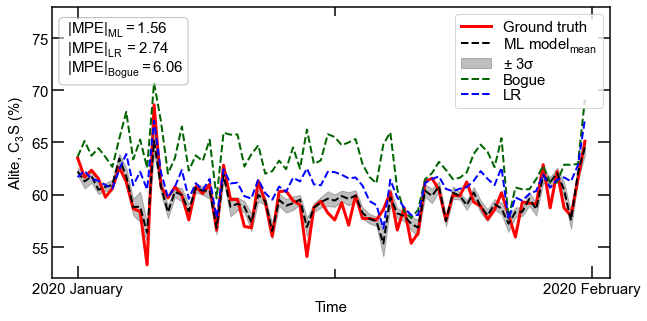

In [738]:
s = 15
x_stamp = []
for i in range(len(y_test)):
    x_stamp.append(i)
fig, ax = plt.subplots(figsize=(10, 5))
low = 0
high = 74#len(y_test)
x =               x_stamp[low:high]
y_a =             actual[low:high]      
y_m=              mean[low:high]             
y_2sigma_max =    two_sigma_max[low:high]    
y_2sigma_min =    two_sigma_min[low:high]   
y_3sigma_max =    three_sigma_max[low:high]  
y_3sigma_min =    three_sigma_min[low:high]
bogue_plot = bogue[low:high]
linear_pred_plot = linear_pred[low:high]  

ax.set_ylim(52,78)

# ax.set_xlim(-38,897)
_= ax.set_xticks([0, 74], labels = ['2020 January', '2020 February'], rotation = 0, fontsize=s, fontweight= 'normal')
_= plt.plot(x,y_a, color = 'red',linewidth=3, label = 'Ground truth')
_= plt.plot(x,y_m, color = 'black',linewidth=2 , label= 'ML'+' '+'model' + '$_{mean}$',ls = '--') 
_= plt.fill_between(x, y_3sigma_min,y_3sigma_max, color = 'black', alpha = 0.25, label = '$\pm$'+' '+ '3'+'$\sigma$') 
_= plt.plot(x,bogue_plot, color = 'darkgreen',linewidth=2, label = 'Bogue',ls = '--') 
_= plt.plot(x,linear_pred_plot, color = 'blue',linewidth=2, label = 'LR',ls = '--')

_= plt.legend(prop= {'weight':'normal', 'size':s}, labelspacing=0.1, frameon= True, loc = 'upper right')
_= plt.yticks(fontweight= 'normal', fontsize =s )
_= plt.xticks(fontweight='normal',fontsize=s)
_= plt.yticks(fontweight= 'normal', fontsize=s)
_= plt.tick_params(which = 'major', width= 1.5, length =12)
_= plt.tick_params(which = 'minor', width= 1.5, length =9)
_= plt.tick_params(axis='y', which='minor', left=False)
_= plt.tick_params(axis='y', which='minor', right=False)

_= plt.xlabel('Time', fontsize= s, fontweight = 'normal')
_= plt.ylabel( 'Alite, $C_{3}S$'+' '+'(%)', fontsize= s, fontweight = 'normal')

_= ax.text(0.02,0.95, ' $|MPE|_{ML} = 1.56$ '+'\n $|MPE|_{LR}$ = '+f'{mpe_LR}'+'\n $|MPE|_{Bogue} = $'+f'{bogue_mpe}',  transform=ax.transAxes, linespacing=1 ,fontsize=s,verticalalignment='top', fontweight='normal', bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round', alpha = 0.5)) 
plt.show()

# Labels for SHAP

In [297]:
X = pd.concat([training_df, testing_df])
all =X.iloc[:,-10:-1]

In [310]:
means = []
this = all.describe().T['mean']
for i in this:
    means.append(round(i,1))

manual_limits_shap = []
a = all.describe().T['min']
b = all.describe().T['max']
for i in range(len(a)):
    lo = round(a[i], 1)
    hi = round(b[i], 1)
    manual_limits_shap.append((lo,hi))

In [311]:
captions_shap = ['$CaO$', '$SiO_2$', '$Al_2O_3$','$Fe_2O_3$', 'MgO', '$SO_3$', '$K_2O$', '$Na_2O$', 'Cl']

In [328]:
new_captions = [
'(63, 67)',
 '(20, 22)',
 '[4.7, 5.9]',
 '[3.2, 4]',
 '[2, 4.1]',
 '[0.1, 0.8]',
 '[0.4, 0.8]',
 '[0, 0.4]',
 '[0, 0.1]']

In [ ]:
new_captions= []
for i in range(len(manual_limits_shap)):
    new_captions.append(captions_shap[i]+f' [{manual_limits_shap[i][0]}, {means[i]}, {manual_limits_shap[i][1]}]')

# SHAP for ML model with clinker oxides as input 

 98%|===================| 1357/1381 [00:21<00:00]        

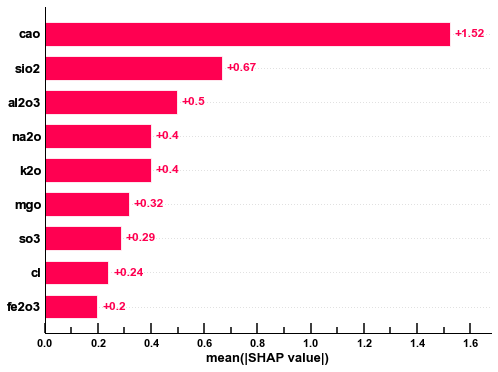

In [597]:
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)

In [606]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

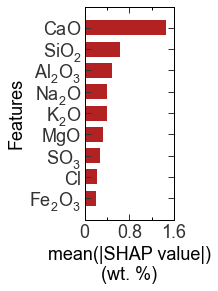

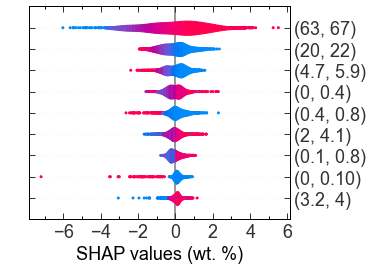

In [667]:
sz = 18

new_captions = ['$CaO$', '$SiO_2$', '$Al_2O_3$','$Fe_2O_3$', 'MgO', '$SO_3$', '$K_2O$', '$Na_2O$', 'Cl']

plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

_= shap.summary_plot(shap_values,show = False, 
                plot_type='bar',
                max_display = 15,
                color_bar = False,
                color= "firebrick",
                feature_names = new_captions,
                features = X_test,      #Changed from X_train to X_test_scx as we are explaining all the predictions in test set
                plot_size=[2.5,4]  # Change this size as per requirement
                )
_= plt.ylabel('Features', fontsize = sz, fontweight = 'normal')
fig=plt.gca()



_= fig.spines['top'].set_visible(True) 
_= fig.spines['right'].set_visible(True)
_= fig.spines['left'].set_visible(True)

visible_ticks = {
"top": True,
}
_= plt.tick_params(axis="x", which="both", **visible_ticks)
_= plt.tick_params(axis="y", which="both", **visible_ticks)
_= plt.tick_params(axis="y", which="major", direction = 'in', left = True)
_= plt.tick_params(axis="y", which="major", direction = 'in', right = True) #mean(|SHAP value|) (wt. %)
_= plt.xlabel('mean(|SHAP value|)\n(wt. %)', fontsize= sz, fontweight= 'normal')
X= [0,0.8,1.6]
_= plt.xticks(X,X,fontsize = sz, fontweight= 'normal')
_= plt.yticks(fontsize = sz, fontweight= 'normal')
_= plt.tick_params(which = 'major', width= 1, length =6)
_= plt.tick_params(which = 'minor', width= 1, length =3)
# plt.yaxis.tick_right()
plt.savefig('/Users/sheikhjunaidfayaz/Documents/Papers/Innovandi/Phase_prediction/Figures/shapbaralite.tiff',format='tiff', dpi=1200)
plt.show()


#Beeswarm code 
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False

new_captions = [
'(63, 67)',
 '(20, 22)',
 '(4.7, 5.9)',
 '(3.2, 4)',
 '(2, 4.1)',
 '(0.1, 0.8)',
 '(0.4, 0.8)',
 '(0, 0.4)',
 '(0, 0.10)']

_= shap.summary_plot(shap_values, show = False, 
                plot_type='violin',
                max_display = 15,
                color_bar = False,
                features = X_test,     #Changed the features to X_test_scx instead of X_train
                feature_names = new_captions,
                plot_size=[5,4])

_= plt.ylabel('Features', fontsize = sz, fontweight = 'normal')
fig=plt.gca()
_= fig.spines['top'].set_visible(True) 
_= fig.spines['right'].set_visible(True)
_= fig.spines['left'].set_visible(True)

visible_ticks = {
"top": True,
}
_= plt.tick_params(axis="x", which="both", **visible_ticks)
_= plt.tick_params(axis="y", which="both", **visible_ticks)
_= plt.tick_params(axis="y", which="major", direction = 'in', left = True)
_= plt.tick_params(axis="y", which="major", direction = 'in', right = True)
_= plt.xlabel('SHAP values (wt. %)', fontsize= sz, fontweight= 'normal')
_= plt.xticks(fontsize = sz, fontweight= 'normal')
_= plt.yticks(fontsize = sz, fontweight= 'normal')
_= plt.tick_params(which = 'major', width= 1, length =6)
_= plt.tick_params(which = 'minor', width= 1, length =3)
_= plt.ylabel(' ')
plt.savefig('/Users/sheikhjunaidfayaz/Documents/Papers/Innovandi/Phase_prediction/Figures/shapviolinalite.tiff',format='tiff', dpi=1200)
plt.show()

.....................................................End........................................................